# SNF Network-based credit risk models in P2P lending markets
Goal: See whether the predictive accuracy of the ML or DL models improve when we include the centrality parameters. So its about checking the AUC values on models trained with and without the centrality measures.

jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

# Libraries

## install missing packages

In [1]:
def install_missing_packages(package_names):
    """
    Install Missing Packages

    This function checks if a list of packages is already installed and installs any missing packages using pip.

    Parameters:
    - package_names (list): A list of package names to be installed.

    Returns:
    - None

    Note: This function requires the `subprocess` and `importlib` modules to be imported.

    Example Usage:
    install_missing_packages(['h2o', 'numpy', 'pandas'])
    """
    import importlib
    import subprocess


    for package_name in package_names:
        try:
            importlib.import_module(package_name)
            print(f"{package_name} package is already installed")
        except ImportError:
            print(f"{package_name} package not found, installing with pip...")
            subprocess.call(['pip', 'install', package_name])


In [2]:
# TODO YOU NEED TO HAVE R installed
package_list = ['h2o', 'rpy2', 'reportlab', 'fpdf', 'tabulate']
install_missing_packages(package_list)

h2o package is already installed
rpy2 package is already installed
reportlab package is already installed
fpdf package is already installed
tabulate package is already installed


## general libraries

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import webbrowser
import pandas as pd
import importlib
import subprocess
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import importlib
import subprocess

import os
import hashlib

import json


In [4]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from tabulate import tabulate

## h2o models

In [5]:
"""
H2O Models

This module provides a set of utility functions for working with H2O models. H2O is an open-source machine learning platform that provides a distributed environment for building and deploying machine learning models.

Functions:
- load_model(model_path): Load an H2O model from the specified path and return the model object.
- save_model(model, model_path): Save the given H2O model to the specified path.
- predict(model, data): Generate predictions using the specified H2O model on the given data.
- evaluate(model, data): Evaluate the performance of the specified H2O model on the given data and return relevant metrics.
- get_model_details(model): Get detailed information about the specified H2O model, including its parameters and performance statistics.
- get_feature_importance(model): Get the feature importance scores for the specified H2O model, indicating the importance of each feature in the model's predictions.

Note: These functions require the H2O Python library to be installed and imported.

For more information on H2O, visit the official documentation at https://docs.h2o.ai/.
"""

import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGeneralizedLinearEstimator, H2ORandomForestEstimator, H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch
import h2o.estimators.glm
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [6]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

## DeLong

In [7]:
"""
DeLong Test

This module implements the DeLong test, a statistical test used to compare the performance of two predictive models by comparing the areas under their receiver operating characteristic (ROC) curves. The DeLong test is commonly used in medical research and other fields to assess the statistical significance of differences in model performance.

Functions:
- delong_test(y_true, y_pred_model1, y_pred_model2): Perform the DeLong test to compare the predictive performance of two models.
    - y_true: The true labels or outcomes.
    - y_pred_model1: The predicted probabilities or scores from model 1.
    - y_pred_model2: The predicted probabilities or scores from model 2.
    Returns the p-value indicating the significance of the difference in performance between the two models.

Note: This implementation assumes that the models' predictions are provided as probabilities or scores rather than discrete class labels. It also assumes that the models' predictions are for a binary classification task.

For more information on the DeLong test, refer to the original paper by DeLong et al. (1988) titled "Comparing the Areas Under Two or More Correlated Receiver Operating Characteristic Curves: A Nonparametric Approach" or other relevant literature.
"""

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
# import R's "pROC" package
pROC = importr('pROC')

# Functions1: Data processing

## Read and write data

In [8]:
def read_df_from_disk(directory, filename, parameters):
    """
    Given a directory name, a file name, and a list of parameters,
    reads the data from the file with the specified name and returns it as a Pandas DataFrame.

    Args:
        directory (str): The name of the directory to read the file from.
        filename (str): The name of the file to read.
        parameters (list): A list of parameters that were included in the filename.

    Returns:
        pandas.DataFrame: The data from the file as a Pandas DataFrame.

    Example:
        >>> directory = 'data'
        >>> filename = 'param1_param2_example.csv'
        >>> parameters = ['param1', 'param2']
        >>> df = read_df_from_disk(directory, filename, parameters)
    """
    # navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())
    
    # navigate into directory
    dir_path = os.path.join(parent_dir, directory)
    
    # merge directory path with file name
    file_path = os.path.join(dir_path, parameters + "_" + filename)
    
    # read dataframe from file
    dataframe = pd.read_csv(file_path)
    
    return dataframe


In [9]:
def read_list_from_disk(directory, filename, parameters):
    """
    Given a directory name, a file name, and a list of parameters,
    reads the data from the file with the specified name and returns it as a list.

    Args:
        directory (str): The name of the directory to read the file from.
        filename (str): The name of the file to read.
        parameters (list): A list of parameters that were included in the filename.

    Returns:
        list: The data from the file as a list.

    Example:
        >>> directory = 'data'
        >>> filename = 'param1_param2_example.txt'
        >>> parameters = ['param1', 'param2']
        >>> lst = read_list_from_disk(directory, filename, parameters)
    """
    # Navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())

    # Navigate into directory
    dir_path = os.path.join(parent_dir, directory)

    # Merge directory path with file name, including parameters in the file name
    file_path = os.path.join(dir_path, "_".join(parameters) + "_" + filename)

    # Read list from file
    with open(file_path, 'r') as f:
        lst = [line.strip() for line in f]
    
    return lst


In [10]:
def calculate_hash(string):
    """Calculate SHA-256 hash of a given string"""
    hash_object = hashlib.sha256(string.encode())
    hex_dig = hash_object.hexdigest()
    return hex_dig
hash_result = calculate_hash("hello world")
print(hash_result)
# Output:  b94d27b9934d3e08a52e52d7da7dabfac484efe37a5380ee9088f7ace2efcde9


b94d27b9934d3e08a52e52d7da7dabfac484efe37a5380ee9088f7ace2efcde9


In [11]:
# function to search for models specific files
import os

def search_file_in_directory(directory, filename):
    """
    Search for a specific file in a directory.
    
    Parameters:
    directory (str): The directory to search in.
    filename (str): The name of the file to search for.

    Returns:
    bool: Whether the file was found.
    """
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.name == filename:
                print(f'File found: {entry.name}')
                return True
    print(f'File not found: {filename}')
    return False


## H20 
related functions

In [12]:
def pandas_to_h2o(data):
    # Convert Pandas DataFrame to H2OFrame
    h2o_df = h2o.H2OFrame(data)
    return h2o_df

def h2o_to_pandas(h2o_df):
    # Convert H2OFrame to Pandas DataFrame
    pandas_df = h2o_df.as_data_frame()

    return pandas_df

In [13]:
def convert_binary_to_categorical(data, binary_columns):
    """
    Convert binary columns in a DataFrame to categorical data type.

    :param data: A pandas DataFrame containing the data.
    :param binary_columns: A list of column names that are binary.
    :return: A new pandas DataFrame with binary columns converted to categorical data type.
    """
    data_categorical = data.copy()

    for column in binary_columns:
        data_categorical[column] = data_categorical[column].astype('category')

    return data_categorical

In [14]:
def convert_to_h2o_frame(pandas_data,binary_columns):
    """
    Convert a pandas DataFrame or Series to an H2O Frame, preserving categorical columns.

    :param pandas_data: pandas DataFrame or Series to be converted
    :return: Converted H2O Frame
    """

    # Convert pandas Series to DataFrame
    if isinstance(pandas_data, pd.Series):
        pandas_data = pandas_data.to_frame()

    # Convert pandas DataFrame to H2O Frame
    h2o_frame = h2o.H2OFrame(pandas_data)

    # Set factor levels for categorical columns in the H2O Frame
    for column in h2o_frame.columns:
        if column in binary_columns:
            h2o_frame[column] = h2o_frame[column].asfactor()

    return h2o_frame

In [15]:
def exclude_columns(data: pd.DataFrame, exclude_list: list) -> pd.DataFrame:
    """
    Exclude specified columns from a Pandas DataFrame.

    Parameters:
    data (pandas.DataFrame): The input Pandas DataFrame.
    exclude_list (list): The list of column names to exclude.

    Returns:
    pandas.DataFrame: A new DataFrame with the specified columns removed.

    """
    new_data = data.drop(exclude_list, axis=1)

    return new_data

In [16]:
def load_h2o_model_from_disk(directory, filename):
    """
    Given a directory name and a file name, loads an H2O model from disk.

    Args:
        directory (str): The name of the directory where the model is saved.
        filename (str): The name of the file where the model is saved.

    Returns:
        H2OEstimator: The loaded H2O estimator object.

    Example:
        >>> directory = 'models'
        >>> filename = 'rf_model'
        >>> loaded_model = load_h2o_model_from_disk(directory, filename)
        >>> predictions = loaded_model.predict(data)
    """
    # Navigate up one level from cwd
    parent_dir = os.path.dirname(os.getcwd())

    # Navigate into directory
    dir_path = os.path.join(parent_dir, directory)

    # Merge directory path with file name
    file_path = os.path.join(dir_path, filename)
    file_path = os.path.join(file_path, filename)
    

    # Load model from file
    loaded_model = h2o.load_model(file_path)
    
    return loaded_model


# Parameters1

## Parameters for data pre-process

In [17]:
## data parameters

data_directory = "data" # where the data is stored

In [18]:
preprocessed_filename = "preprocessed_shuffled" #goes to the shffuled data set

In [19]:
directory = 'data'
file_name = 'Bondora_sample(24000)_with_centrality.csv'
parameter_string = "pandas_washes"

# Auto ML

## Init the H2O package:

In [20]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         7 mins 27 secs
H2O_cluster_timezone:       Europe/Zurich
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.4
H2O_cluster_version_age:    2 months and 15 days
H2O_cluster_name:           H2O_from_python_yil1_oxaqk8
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6.707 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.17 final
--------------------------  -----------------------------

# Read back data and convert to H20
Read back the dataset (after cleaning) and convert to H2O df

## Read back data

In [21]:
preprocessed_filename

'preprocessed_shuffled'

In [22]:
data_categorical = read_df_from_disk(directory = data_directory,
                                     filename = preprocessed_filename, 
                                     parameters = parameter_string)
binary_columns = read_list_from_disk(directory = data_directory,
                                     filename = preprocessed_filename, 
                                     parameters = "binary columns")
target_column = "default"
feature_columns = [col for col in data_categorical.columns if col != target_column]
#print(binary_columns)
#print(len(binary_columns))

In [23]:
print(data_categorical.head())
print(type(data_categorical))

   default  new       Age  Gender  Interest  MonthlyPayment  DebtToIncome  \
0        0    1  0.634615       0  0.392055        0.699456      0.834713   
1        0    1  0.192308       0  0.291110        0.693792      0.000000   
2        0    0  0.423077       0  0.197004        0.587526      0.625892   
3        0    0  0.134615       0  0.521980        0.418453      0.108193   
4        0    1  0.615385       0  0.363400        0.631606      0.000000   

   NoOfPreviousLoansBeforeLoan  AmountOfPreviousLoansBeforeLoan      time  \
0                     0.000000                         0.000000  0.280459   
1                     0.000000                         0.000000  0.855214   
2                     0.153846                         0.163233  0.370908   
3                     0.076923                         0.014718  0.224772   
4                     0.000000                         0.000000  0.740803   

   ...  katz  authority           hub  pagerank_shuffled  \
0  ...   0.0  

## Train test split

In [24]:
X = data_categorical.drop(target_column, axis=1)
y = data_categorical[target_column]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.4,
                                                    random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                y_test,
                                                test_size=0.5,
                                                random_state=42)

In [25]:
X_train.copy().iloc[:,-20:]

no.previous.repay.00  no.previous.repay.01  previous.repay.l  A  B  C  \
8063                      1                     0           0.00000  0  0  1   
4812                      1                     0           0.00000  1  0  0   
2126                      1                     0           0.00000  0  0  1   
20503                     1                     0           0.00000  1  0  0   
15863                     1                     0           0.00000  0  1  0   
...                     ...                   ...               ... .. .. ..   
21575                     1                     0           0.00000  0  0  1   
5390                      0                     0           0.75122  0  0  0   
860                       1                     0           0.00000  0  0  1   
15795                     1                     0           0.00000  0  0  1   
23654                     1                     0           0.00000  0  0  1   

       pagerank  betweenness  closeness  eigenvector      katz     authority  \
8063   0.000000          0.0   0.032052          NaN  0.000000  0.000000e+00   
4812   0.000000          0.0   0.027383          NaN  0.000000  0.000000e+00   
2126   0.000000          0.0   0.001437          NaN  0.000000  0.000000e+00   
20503  0.205827          0.0        NaN          NaN  0.076921  7.045160e-87   
15863  0.000000          0.0   0.014420          NaN  0.000000  0.000000e+00   
...         ...          ...        ...          ...       ...           ...   
21575  0.317804          0.0        NaN          NaN  0.106411  5.334708e-83   
5390   0.000000          0.0   0.035732          NaN  0.000000  0.000000e+00   
860    0.000000          0.0   0.036884          NaN  0.000000  0.000000e+00   
15795  0.069807          0.0        NaN          NaN  0.095726  6.009113e-56   
23654  0.123723          0.0        NaN          NaN  0.046349  4.326897e-73   

                hub  pagerank_shuffled  betweenness_shuffled  \
8063   1.450147e-94           0.000000                   0.0   
4812   6.836651e-95           0.072116                   0.0   
2126   1.523836e-52           0.000000                   0.0   
20503  0.000000e+00           0.754861                   0.0   
15863  2.493049e-61           0.025147                   0.0   
...             ...                ...                   ...   
21575  0.000000e+00           0.118575                   0.0   
5390   2.126107e-87           0.046740                   0.0   
860    1.096428e-58           0.000000                   0.0   
15795  0.000000e+00           0.170213                   0.0   
23654  0.000000e+00           0.028315                   0.0   

       closeness_shuffled  eigenvector_shuffled  katz_shuffled  \
8063                  NaN                   NaN       0.032320   
4812             0.008196                   NaN       0.000000   
2126             0.018443                   NaN       0.018299   
20503            0.040617                   NaN       0.000000   
15863            0.046317                   NaN       0.000000   
...                   ...                   ...            ...   
21575                 NaN                   NaN       0.000000   
5390             0.069236                   NaN       0.019816   
860              0.026148                   NaN       0.000000   
15795                 NaN                   NaN       0.019335   
23654            0.043040                   NaN       0.000000   

       authority_shuffled   hub_shuffled  
8063         8.897694e-77   6.282860e-93  
4812         3.237512e-44   0.000000e+00  
2126         5.736236e-95  3.672094e-121  
20503        0.000000e+00   0.000000e+00  
15863        0.000000e+00   0.000000e+00  
...                   ...            ...  
21575        1.263573e-62   2.982453e-29  
5390         6.132651e-37  3.338669e-102  
860          1.024834e-65   4.944755e-77  
15795        0.000000e+00   0.000000e+00  
23654        3.308121e-77   6.026703e-77  

[14400

## Convert to H20
also some simple tests

In [26]:
X_train = convert_to_h2o_frame(X_train, binary_columns)
X_test = convert_to_h2o_frame(X_test, binary_columns)
X_val = convert_to_h2o_frame(X_val, binary_columns)

y_train = convert_to_h2o_frame(y_train, 'default')
y_test = convert_to_h2o_frame(y_test, 'default')
y_val = convert_to_h2o_frame(y_val, 'default')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
print(type(X_train))
print(type(X_test))
print(type(X_val))
print(type(y_train))
print(type(y_test))
print(type(y_val))

# Function2: Load models and compare

In [27]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.rinterface_lib.callbacks
import contextlib
import io

# Import R's "pROC" package
pROC = importr('pROC')

@contextlib.contextmanager
def no_print():
    """
    Context manager to suppress console output.
    """
    original_writeconsole_regular = rpy2.rinterface_lib.callbacks.consolewrite_print
    rpy2.rinterface_lib.callbacks.consolewrite_print = lambda x: None
    try:
        yield
    finally:
        rpy2.rinterface_lib.callbacks.consolewrite_print = original_writeconsole_regular


def delong_test(model1, model2, X_test, y_test):
    """
    Performs the DeLong test to compare the performance of two models.

    Parameters:
    model1: First h2o model for comparison.
    model2: Second h2o model for comparison.
    X_test: h2o DataFrame of features used for testing.
    y_test: h2o DataFrame of target variable used for testing.

    Returns:
    None. Prints the results of the DeLong test.

    Example:
    delong_test(model_with6, model_without6, X_test, y_test)
    """

    # Generate predictions
    pred1 = model1.predict(X_test.cbind(y_test)).as_data_frame()
    pred2 = model2.predict(X_test.cbind(y_test)).as_data_frame()

    # Get predicted probabilities and true labels
    y_scores1 = pred1['p1'].values
    y_scores2 = pred2['p1'].values
    y_true = y_test.as_data_frame().values.flatten()

    # Create R objects
    r_y_scores1 = robjects.FloatVector(y_scores1)
    r_y_scores2 = robjects.FloatVector(y_scores2)
    r_y_true = robjects.IntVector(y_true)

    with no_print():
        roc1 = pROC.roc(r_y_true, r_y_scores1)
        roc2 = pROC.roc(r_y_true, r_y_scores2)
        roc_test = pROC.roc_test(roc1, roc2, method="delong")


    # Extract hypothesis and p-value
    hypothesis = roc_test.rx2('alternative')[0]
    p_value = roc_test.rx2('p.value')[0]

    return hypothesis, p_value


# Example usage:
# delong_test(model_with6, model_without6, X_test, y_test)

In [28]:
def load_one_model(model_directory, model_name, hyper_param, exclude_list):
    """
    Load a trained H2O model from disk.
    
    Parameters:
    model_directory (str): The directory where the model is stored.
    model_name (str): The name of the model.
    hyper_param (dict): The hyperparameters used to train the model.
    exclude_list (list): A list of features that were excluded during model training.

    Returns:
    model: The loaded H2O model.
    """
    data_set_parameters = str(sorted(
        exclude_list)) + data_directory + preprocessed_filename + file_name
    model_parameters = data_set_parameters + model_name + str(hyper_param)
    model_parameters_hash = calculate_hash(model_parameters)

    model = load_h2o_model_from_disk(directory=model_directory,
                                     filename=model_parameters_hash)

    #print(model)
    return model

In [29]:
def load_a_group_of_model(exclude_LIST, model_directory, model_name,
                          hyper_param):
    """
    This function loads a group of H2O models from a specified directory.

    Parameters:
    exclude_LIST: A list of lists where each sublist contains the features to be excluded during the model load.
    model_directory: A string representing the directory where the H2O model files are saved.
    model_name: A string representing the base name of the model files.
    hyper_param: A dictionary containing the hyperparameters used for the model.

    Returns:
    h2o_models: A list of H2O model objects that have been loaded.
    """
    h2o_models = []

    for exclude_list in exclude_LIST:
        # For each list of features to be excluded, load the corresponding model and append it to the list.
        # The function load_one_model() is assumed to take the directory, model name, hyperparameters, and exclude list as arguments,
        # and returns a loaded H2O model.
        h2o_models.append(
            load_one_model(model_directory, model_name, hyper_param,
                           exclude_list))

    # Return the list of loaded models.
    return h2o_models

In [30]:
from h2o import H2OFrame

def model_compare_within_group(model_group, X_test, y_test, paired=True):
    """
    This function evaluates a group of models on a given test set, and returns several evaluation metrics for each model.
    If the 'paired' parameter is set to True, the function will also perform a DeLong test to compare the performance of each pair of models.

    Parameters:
    model_group: A list of trained H2O models to be evaluated.
    X_test: An H2OFrame representing the predictor variables in the test set.
    y_test: An H2OFrame representing the response variable in the test set.
    paired: A Boolean indicating whether to perform a DeLong test comparing the performance of each pair of models.

    Returns:
    confusion_matrices: A list of confusion matrices, one for each model.
    roc_curves: A list of ROC curves, one for each model.
    auc_s: A list of AUC scores, one for each model.
    delong_results: A list of tuples, each containing the null hypothesis and p-value from a DeLong test comparing a pair of models.
    """
    confusion_matrices = []
    roc_curves = []
    auc_s = []
    delong_results = []

    # Loop over models and compute metrics
    for model in model_group:
        # Performance
        performance = model.model_performance(X_test.cbind(y_test))

        # Get confusion matrix
        confusion_matrix = performance.confusion_matrix()
        confusion_matrices.append(confusion_matrix)

        # Get ROC curve
        roc_curve = performance.roc()
        roc_curves.append(roc_curve)

        # Get AUC value
        auc = performance.auc()
        auc_s.append(auc)

    # If paired is True, perform DeLong test on each pair of models
    if paired:
        for i in range(0, len(model_group), 2):
            model1 = model_group[i]
            model2 = model_group[i + 1]
            hypothesis, p_value = delong_test(model1, model2, X_test, y_test)
            delong_results.append((hypothesis, p_value))
        return confusion_matrices, roc_curves, auc_s, delong_results
    else:
        return confusion_matrices, roc_curves, auc_s


## load_pairs_and_compare

Keep this part, do not remove

import time


def load_pairs_and_compare(X_test,
                           y_test,
                           exclude_LIST,
                           models_and_hyperparams,
                           model_directory,
                           graph_directory,
                           model_to_analyse,
                           paired=True):
    """
    This function loads pairs of models specified in models_and_hyperparams, 
    compares the performance of each pair using model_compare_within_group, and saves ROC curves in a PDF file.

    Parameters:
    X_test: The test data (features).
    y_test: The test data (labels).
    exclude_LIST: A list, each sublist of which contains the features to be excluded when loading the model.
    models_and_hyperparams: A list of dictionaries, each of which contains the model type, model name, and hyperparameters.
    model_directory: A string representing the directory where the H2O model files are saved.
    graph_directory: A string representing the directory where the ROC curve graphs will be saved.
    model_to_analyse: A list of model names to analyze.
    paired: A boolean indicating whether to perform DeLong's test on each pair of models (default is True).

    Returns:
    result_list: A list, each sublist of which contains the model_id of the model, the hyperparameters, and the result of the DeLong test.
    graph_filepath: The file path of the PDF file containing the ROC curve graphs.
    """
    result_list = []
    problematic_pairs = [
    ]  # List to keep track of problematic hyperparameters and indices

    counter = 0
    for model_dict in models_and_hyperparams:  # Loop over different model types
        counter += 1
        if counter % 10 == 0:
            time.sleep(
                2.5
            )  # Add a delay every 10 models to avoid overloading the system

        model_name = model_dict['model_name']
        if model_name not in model_to_analyse:
            continue

        # Prepare to save ROC curves as a PDF file
        graph_directory_path = os.path.join(graph_directory, "ROC_curves",
                                            str(preprocessed_filename))

        # Create the directory if it doesn't exist
        os.makedirs(graph_directory_path, exist_ok=True)

        graph_filepath = os.path.join(graph_directory_path,
                                      f"{model_name}.pdf")
        pdf = PdfPages(graph_filepath)

        hyper_params = model_dict['hyper_params']

        # Generate all combinations of hyperparameters
        keys, values = zip(*hyper_params.items())
        hyper_param_combinations = [
            dict(zip(keys, v)) for v in itertools.product(*values)
        ]

        for i, hyper_param in enumerate(
                hyper_param_combinations):  #loop: hyper parameters combination

            model_group = load_a_group_of_model(exclude_LIST, model_directory,
                                                model_name, hyper_param)

            try:
                # Evaluate the performance of the group of models and plot ROC curves
                if paired:
                    confusion_matrices, roc_curves, auc_s, delong_results = model_compare_within_group(
                        model_group, X_test, y_test)
                else:
                    confusion_matrices, roc_curves, auc_s = model_compare_within_group(
                        model_group, X_test, y_test, paired=False)
                # Add results to result list
                for i in range(0, len(model_group), 2):
                    model1 = model_group[i]
                    model2 = model_group[i + 1]
                    if paired:
                        delong_result = delong_results[i // 2]
                        hypothesis, p_value = delong_result
                        #!!! model_id, hyper_param, auc, hypothesis, p_value
                        result_list.append([
                            model1.model_id, hyper_param, auc_s[i], hypothesis,
                            p_value
                        ])
                        result_list.append([
                            model2.model_id, hyper_param, auc_s[i + 1],
                            hypothesis, p_value
                        ])
                    else:
                        result_list.append(
                            [model1.model_id, hyper_param, auc_s[i]])
                        result_list.append(
                            [model1.model_id, hyper_param, auc_s[i + 1]])
                # Plot ROC curves
                for i, roc_curve in enumerate(roc_curves):
                    linestyle = '-' if i % 2 == 0 else '-.'
                    color = f'C{i // 2}'  # Use color cycle C0, C1, C2, ...
                    plt.plot(roc_curve[0],
                             roc_curve[1],
                             linestyle=linestyle,
                             color=color)  # Add AUC value to the label)

                #plt.title(f"Model: {model_name}, Hyperparameters: {hyper_param}")
                plt.title(
                    f"Model: {model_name}\nHyperparameters: {hyper_param}"
                    #\nPreprocessed File: {preprocessed_filename}
                )

                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                
                # Create a custom legend for model pairs
                if paired:
                    legend_elements = [
                        Patch(
                            facecolor=f'C{i}',
                            edgecolor=f'C{i}',
                            label=
                            f"Model Pair {i+1}, Hypothesis: {delong_results[i][0]}, p-value: {delong_results[i][1]}"
                        ) for i in range(0, len(delong_results))
                    ]
                    # Set the legend
                    auc_legend_elements = [
                        Line2D([0], [0],
                               color=f'C{i // 2}',
                               linestyle='-' if i % 2 == 0 else '-.',
                               label=f"Model {i+1}: AUC = {auc_s[i]:.2f}")
                        for i in range(len(auc_s))
                    ]

                    auc_legend_elements = [
                        Line2D([0], [0],
                               color=f'C{i // 2}',
                               linestyle='-' if i % 2 == 0 else '-.',
                               label=f"Model {i+1}: AUC = {auc_s[i]:.2f}")
                        for i in range(len(auc_s))
                    ]

                    plt.legend(handles=legend_elements + auc_legend_elements,
                               loc="lower right")

                pdf.savefig()
                plt.clf()

            except Exception as e:
                print(
                    f"Error with hyperparameters: {hyper_param} and index: {i}. Exception: {e}"
                )
                problematic_pairs.append((hyper_param, i, e))

            print(str(hyper_param) + "finished!!!")

        pdf.close()

    if problematic_pairs:
        print(
            f"Problems encountered with the following hyperparameters and indices: {problematic_pairs}"
        )
    else:
        print("No problems encountered during model comparison.")

    return problematic_pairs, result_list, graph_filepath

In [36]:
import time


def load_pairs_and_compare(X_test,
                           y_test,
                           exclude_LIST,
                           models_and_hyperparams,
                           model_directory,
                           graph_directory,
                           model_to_analyse,
                           paired=True):
    """
    This function loads pairs of models specified in models_and_hyperparams, 
    compares the performance of each pair using model_compare_within_group, and saves ROC curves in a PDF file.

    Parameters:
    X_test: The test data (features).
    y_test: The test data (labels).
    exclude_LIST: A list, each sublist of which contains the features to be excluded when loading the model.
    models_and_hyperparams: A list of dictionaries, each of which contains the model type, model name, and hyperparameters.
    model_directory: A string representing the directory where the H2O model files are saved.
    graph_directory: A string representing the directory where the ROC curve graphs will be saved.
    model_to_analyse: A list of model names to analyze.
    paired: A boolean indicating whether to perform DeLong's test on each pair of models (default is True).

    Returns:
    result_list: A list, each sublist of which contains the model_id of the model, the hyperparameters, and the result of the DeLong test.
    graph_filepath: The file path of the PDF file containing the ROC curve graphs.
    """
    result_list = []
    problematic_pairs = [
    ]  # List to keep track of problematic hyperparameters and indices

    counter = 0
    for model_dict in models_and_hyperparams:  # Loop over different model types
        """
        counter += 1
        if counter % 10 == 0:
            time.sleep(
                2.5
            )  # Add a delay every 10 models to avoid overloading the system

        """
        model_name = model_dict['model_name']
        if model_name not in model_to_analyse:
            continue

        # Prepare to save ROC curves as a PDF file
        graph_directory_path = os.path.join(graph_directory, "ROC_curves",
                                            str(preprocessed_filename))

        # Create the directory if it doesn't exist
        os.makedirs(graph_directory_path, exist_ok=True)

        graph_filepath = os.path.join(graph_directory_path,
                                      f"{model_name}.pdf")
        pdf = PdfPages(graph_filepath)

        hyper_params = model_dict['hyper_params']

        # Generate all combinations of hyperparameters
        keys, values = zip(*hyper_params.items())
        hyper_param_combinations = [
            dict(zip(keys, v)) for v in itertools.product(*values)
        ]

        for i, hyper_param in enumerate(
                hyper_param_combinations):  #loop: hyper parameters combination

            model_group = load_a_group_of_model(exclude_LIST, model_directory,
                                                model_name, hyper_param)

            try:

                if paired:
                    confusion_matrices, roc_curves, auc_s, delong_results = model_compare_within_group(
                        model_group, X_test, y_test)
                # Initialize an index to track model pairs
                pair_index = 0

                while pair_index < len(model_group):
                    model1 = model_group[pair_index]
                    model2 = model_group[pair_index + 1]

                    if paired:
                        delong_result = delong_results[pair_index // 2]
                        hypothesis, p_value = delong_result
                        result_list.append([
                            model1.model_id, hyper_param, auc_s[pair_index],
                            hypothesis, p_value
                        ])
                        result_list.append([
                            model2.model_id, hyper_param,
                            auc_s[pair_index + 1], hypothesis, p_value
                        ])
                    else:
                        result_list.append(
                            [model1.model_id, hyper_param, auc_s[pair_index]])
                        result_list.append([
                            model2.model_id, hyper_param, auc_s[pair_index + 1]
                        ])

                    # Plot ROC curves for this pair of models
                    for j in range(pair_index, pair_index + 2):
                        roc_curve = roc_curves[j]
                        linestyle = '-' if j % 2 == 0 else '-.'
                        alpha = 0.5 if j % 2 == 0 else 1  # This should be indented properly
                        color = f'C{j // 2}'  # Use color cycle C0, C1, C2, ...
                        plt.plot(roc_curve[0],
                                 roc_curve[1],
                                 linestyle=linestyle,
                                 color=color,
                                 alpha=alpha)  # Add AUC value to the label)

                    #plt.title(
                    #f"Model: {model_name}\nHyperparameters: {hyper_param}")
                    plt.xlabel("False Positive Rate")
                    plt.ylabel("True Positive Rate")
                    plt.xlim([0, 1.2])
                    plt.ylim([0, 1.2])

                    # Create a custom legend for model pairs
                    if paired:
                        legend_elements = [
                            Patch(
                                facecolor=f'C{pair_index // 2}',
                                edgecolor=f'C{pair_index // 2}',
                                label=
                                f"Model Pair {pair_index // 2 + 1}, Hypothesis: {delong_results[pair_index // 2][0]}, p-value: {format(delong_results[pair_index // 2][1], '.2e')}",
                                #f"Model Pair {pair_index // 2 + 1}, Hypothesis: {delong_results[pair_index // 2][0]}, p-value: {delong_results[pair_index // 2][1]}",
                                alpha=0.5 if j % 2 == 0 else 1)
                        ]

                        auc_legend_elements = [
                            Line2D([0], [0],
                                   color=f'C{pair_index // 2}',
                                   linestyle='-' if j % 2 == 0 else '-.',
                                   label=f"Model {j+1}: AUC = {auc_s[j]:.2f}")
                            for j in range(pair_index, pair_index + 2)
                        ]
                        plt.legend(handles=legend_elements +
                                   auc_legend_elements,
                                   loc="lower right")

                    pdf.savefig()
                    plt.clf()

                    # Move to the next pair
                    pair_index += 2

            except Exception as e:
                print(
                    f"Error with hyperparameters: {hyper_param} and index: {i}. Exception: {e}"
                )
                problematic_pairs.append((hyper_param, i, e))

            print(str(hyper_param) + "finished!!!")

        pdf.close()

    if problematic_pairs:
        print(
            f"Problems encountered with the following hyperparameters and indices: {problematic_pairs}"
        )
    else:
        print("No problems encountered during model comparison.")

    return problematic_pairs, result_list, graph_filepath

## Feature_importance

In [37]:
def feature_importance(X_test,
                       y_test,
                       exclude_LIST,
                       models_and_hyperparams,
                       model_directory,
                       graph_directory,
                       model_to_analyse,
                       exclude_feature=None,
                       paired=True):
    problematic_pairs = []

    for model_dict in models_and_hyperparams:

        model_name = model_dict['model_name']
        if model_name not in model_to_analyse:
            continue

        graph_directory_path = os.path.join(graph_directory,
                                            "feature_importance",
                                            str(preprocessed_filename))

        os.makedirs(graph_directory_path, exist_ok=True)

        graph_filepath = os.path.join(graph_directory_path,
                                      f"{model_name}.pdf")
        pdf = PdfPages(graph_filepath)

        hyper_params = model_dict['hyper_params']

        keys, values = zip(*hyper_params.items())
        hyper_param_combinations = [
            dict(zip(keys, v)) for v in itertools.product(*values)
        ]

        for i, hyper_param in enumerate(hyper_param_combinations):

            model_group = load_a_group_of_model(exclude_LIST, model_directory,
                                                model_name, hyper_param)

            feature_names = X_train.columns

            feature_importances = {
                name: [0] * len(model_group)
                for name in feature_names if name not in exclude_feature
            }

            for i, model in enumerate(model_group):
                try:
                    varimp = model.varimp(use_pandas=True)
                    for index, row in varimp.iterrows():
                        feature = row['variable']
                        if feature in feature_importances:
                            feature_importances[feature][i] = row[
                                'scaled_importance']
                except AttributeError as e:
                    problematic_pairs.append((hyper_param, e))
                    continue

            fig, ax = plt.subplots(figsize=(40, 10))
            bar_width = 0.15
            for i, (feature,
                    importances) in enumerate(feature_importances.items()):
                for j, importance in enumerate(importances):
                    ax.bar(i + j * bar_width,
                           importance,
                           bar_width,
                           color=f'C{j // 2}',
                           label=f'Model {j+1}'
                           if feature == feature_names[0] else "")
                    if j % 2 == 1:
                        ax.bar(i + j * bar_width,
                               importance,
                               bar_width,
                               color=f'C{j // 2}',
                               hatch='///',
                               alpha=0.75)

            ax.set_xticks([
                i + bar_width * (len(model_group) // 2)
                for i in range(len(feature_importances))
            ])
            ax.set_xticklabels(list(feature_importances.keys()),
                               rotation=90,
                               fontsize=8)

            #ax.set_title(
                #f"Model: {model_name}\nHyperparameters: {hyper_param}\nPreprocessed File: {preprocessed_filename}"
            #)

            legend_patches = [
                mpatches.Patch(color=f'C{i // 2}',
                               alpha=0.25 if i % 2 else 1.0,
                               hatch='////' if i % 2 else None,
                               label=f'Model {i+1}')
                for i in range(len(model_group))
            ]

            plt.legend(handles=legend_patches)

            pdf.savefig()

        pdf.close()
        if problematic_pairs:
            print(
                f"Problems encountered with the following hyperparameters and indices: {problematic_pairs}"
            )
        else:
            print("No problems encountered during model comparison.")
    return problematic_pairs, graph_filepath

## Print the model report

In [38]:
from fpdf import FPDF

# 创建自定义的PDF类
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Model Information', 0, 1, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, text):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, text)
        self.ln(10)


In [39]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas


def create_pdf(models, pdf):
    # 创建一个新的canvas对象
    #c = canvas.Canvas(filename, pagesize=letter)

    # 为每个模型创建一个摘要并添加到PDF

    for i, model in enumerate(models):
        pdf.add_page()

        # 打印model信息
        pdf.chapter_title(f'Model {i+1} Details')
        pdf.chapter_body(str(model))

        # 打印coefficients_table信息
        pdf.chapter_title(f'Model {i+1} Coefficients Table')
        coefficients_table = model._model_json['output']['coefficients_table']

        if coefficients_table is not None:
            num_rows = len(coefficients_table.cell_values[0])
            num_cols = len(coefficients_table.cell_values)

            if num_rows > 0 and num_cols > 0:
                # 检查系数表的列数是否足够
                max_cols = min(6, num_cols)
                headers = coefficients_table.col_header[:max_cols]
                table_data = [
                    coefficients_table.cell_values[col][:max_cols]
                    for col in range(num_cols)
                ]
                coefficients_table_str = tabulate(table_data,
                                                  headers=headers,
                                                  tablefmt='grid')
                pdf.chapter_body(coefficients_table_str)
            else:
                pdf.chapter_body(
                    "No coefficients table available for this model.")
        else:
            pdf.chapter_body("No coefficients table available for this model.")

In [40]:
def print_model_report(X_test, y_test, exclude_LIST, models_and_hyperparams,
                       model_directory, graph_directory, model_to_analyse):

    for model_dict in models_and_hyperparams:  # Loop over different model types

        model_name = model_dict['model_name']
        if model_name not in model_to_analyse:
            continue

        # Prepare to save ROC curves as a PDF file
        graph_directory_path = os.path.join(graph_directory, "model_report",
                                            str(preprocessed_filename))

        # Create the directory if it doesn't exist
        os.makedirs(graph_directory_path, exist_ok=True)

        graph_filepath = os.path.join(graph_directory_path,
                                      f"{model_name}.pdf")

        hyper_params = model_dict['hyper_params']

        # Generate all combinations of hyperparameters
        keys, values = zip(*hyper_params.items())
        hyper_param_combinations = [
            dict(zip(keys, v)) for v in itertools.product(*values)
        ]

        pdf = PDF()
        for i, hyper_param in enumerate(
                hyper_param_combinations):  #loop: hyper parameters combination

            model_group = load_a_group_of_model(exclude_LIST, model_directory,
                                                model_name, hyper_param)
            # 为模型组创建一个PDF摘要
            create_pdf(model_group, pdf)

        pdf.output(graph_filepath, 'F')

    return graph_filepath

# Parameters2: Relevant to models

In [41]:
exclude_features_distribution = read_list_from_disk(
    directory=data_directory,
    filename=preprocessed_filename,
    parameters="exclude_features_distribution")
exclude_features_distribution

In [42]:
exclude_features_selectionMethod= read_list_from_disk(
    directory=data_directory,
    filename=preprocessed_filename,
    parameters="exclude_features_selectionMethod")
exclude_features_selectionMethod

In [43]:
exclude_features_distribution
exclude_features_selectionMethod

exclude_LIST = [
    #This is EXCLUDE list!!!
    #When you change this list, it must keep two dimentions, and contains only strings
    #All initial columns - uninformative features
    list(
        set([
            'pagerank', 'betweenness', 'closeness', 'eigenvector', 'katz',
            'authority', 'hub', 'pagerank_shuffled', 'betweenness_shuffled',
            'closeness_shuffled', 'eigenvector_shuffled', 'katz_shuffled',
            'authority_shuffled', 'hub_shuffled'
        ] + exclude_features_distribution + exclude_features_selectionMethod)),
    #Initial columns - uninformative features + informative graph features
    list(
        set([
            'pagerank_shuffled', 'betweenness_shuffled', 'closeness_shuffled',
            'eigenvector_shuffled', 'katz_shuffled', 'authority_shuffled',
            'hub_shuffled'
        ] + exclude_features_distribution + exclude_features_selectionMethod)),
    #All initial columns - uninformative features
    list(
        set([
            'pagerank', 'betweenness', 'closeness', 'eigenvector', 'katz',
            'authority', 'hub', 'pagerank_shuffled', 'betweenness_shuffled',
            'closeness_shuffled', 'eigenvector_shuffled', 'katz_shuffled',
            'authority_shuffled', 'hub_shuffled'
        ] + exclude_features_distribution + exclude_features_selectionMethod)),
    #Initial columns - uninformative features + shuffled  graph features
    list(
        set([
            'pagerank', 'betweenness', 'closeness', 'eigenvector', 'katz',
            'authority', 'hub'
        ] + exclude_features_distribution + exclude_features_selectionMethod))
]

In [44]:
exclude_LIST[3]

## Models and Hyperparams
This cell must be updated manually!!!!!!!!!!!

In [45]:
"""
Define Models and Hyperparameters

This section defines a list of models along with their corresponding hyperparameters. Each model is represented by a dictionary containing the following keys:

- 'model': The model class or constructor.
- 'model_name': A string representing the name or identifier of the model.
- 'hyper_params': A dictionary specifying the hyperparameter grid for the model.
- 'params': Additional parameters for the model.

The list 'models_and_hyperparams' contains multiple such dictionaries, each representing a different model with its hyperparameters.

After defining the list, the function 'write_list_to_disk' is called to write the 'models_and_hyperparams' list to a file on disk.

Parameters:
- None

Returns:
- None

Example Usage:
Define the models and hyperparameters, and write them to a file:
    write_list_to_disk(
        lst=models_and_hyperparams,
        directory=model_directory,
        filename="models_and_hyperparams",
        parameters=""
    )
"""

# Define Models and Hyperparameters
models_and_hyperparams = [
    # Existing models...
    {
        'model': H2OGeneralizedLinearEstimator,
        'model_name': "GLM",
        'hyper_params': {
            'alpha': [0, 0.2, 0.4, 0.6, 0.8, 1],
            'lambda': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
        },
        'params': {
            'family': 'binomial'
        }
    },
    {
        'model': H2ORandomForestEstimator,
        'model_name': "RF",
        'hyper_params': {
            'ntrees': [50, 100, 150, 200, 250],
            'max_depth': [5, 10, 15, 20]
        },
        'params': {}
    },
    {
        'model': H2ODeepLearningEstimator,
        'model_name': "DL",
        'hyper_params': {
            'hidden': [[50, 50], [100, 100], [200, 200], [100, 200, 100],
                       [200, 100, 200]],
            'epochs': [10, 50, 100],
        },
        'params': {}
    },
    # New models...
    {
        'model': H2OXGBoostEstimator,
        'model_name': "XGB",
        'hyper_params': {
            'ntrees': [100, 200],
            'max_depth': [5, 15],
            'learn_rate': [0.01, 0.1, 0.2],
            'sample_rate': [0.6, 0.8, 1.0],
        },
        'params': {}
    },
    {
        'model': H2OGradientBoostingEstimator,
        'model_name': "GBM",
        'hyper_params': {
            'ntrees': [100, 200],
            'max_depth': [5, 15],
            'learn_rate': [0.01, 0.1, 0.2],
            'sample_rate': [0.6, 0.8, 1.0],
        },
        'params': {}
    }
]

In [46]:
model_directory = "model"

model_to_analyse = ["GLM",'RF', 'DL']

graph_directory = os.path.dirname(os.getcwd()) + '/graph'
graph_directory

# Load and evaluate
we have read back the test and train data. now we read back the trained model

This part load the models.\
Our aim is to compare the performance of two models sharing same hyper parameters but based on with6 and withou6.\
Currently, I have not finished the code to compare multiple groups of models.\
I plan to finish the code for comparsion, and then apply this part to multiple groups.\
Currently, I use model_with6 and model_without6 to represent two models.\

In [88]:
problematic_pairs, result_list, graph_filepath = load_pairs_and_compare(
    X_val,
    y_val,
    exclude_LIST,
    models_and_hyperparams,
    model_directory,
    graph_directory,
    model_to_analyse,
    paired=True)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 50, 'max_depth': 5}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 50, 'max_depth': 10}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 50, 'max_depth': 15}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 50, 'max_depth': 20}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 100, 'max_depth': 5}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 100, 'max_depth': 10}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 100, 'max_depth': 15}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 100, 'max_depth': 20}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 150, 'max_depth': 5}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 150, 'max_depth': 10}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 150, 'max_depth': 15}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 150, 'max_depth': 20}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 200, 'max_depth': 5}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 200, 'max_depth': 10}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 200, 'max_depth': 15}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 200, 'max_depth': 20}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 250, 'max_depth': 5}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 250, 'max_depth': 10}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 250, 'max_depth': 15}finished!!!
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



███████████████████████████████████████████████████████| (done) 100%
{'ntrees': 250, 'max_depth': 20}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [50, 50], 'epochs': 10}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [50, 50], 'epochs': 50}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [50, 50], 'epochs': 100}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [100, 100], 'epochs': 10}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [100, 100], 'epochs': 50}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [100, 100], 'epochs': 100}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [200, 200], 'epochs': 10}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [200, 200], 'epochs': 50}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [200, 200], 'epochs': 100}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [100, 200, 100], 'epochs': 10}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [100, 200, 100], 'epochs': 50}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [100, 200, 100], 'epochs': 100}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [200, 100, 200], 'epochs': 10}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [200, 100, 200], 'epochs': 50}finished!!!
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



██████████████████████████████████████████████| (done) 100%
{'hidden': [200, 100, 200], 'epochs': 100}finished!!!
No problems encountered during model comparison.


<Figure size 640x480 with 0 Axes>

In [83]:
problematic_pairs

[]

In [84]:
problematic_pairs = []  

No problems encountered during model comparison.


/var/folders/p7/yz9l_v5n4cx5x7hgbnl67by40000gn/T/ipykernel_99559/2334423729.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(40, 10))


No problems encountered during model comparison.


([],
 '/Users/yil1/GitHub/P2P-Model-Bondora/graph/feature_importance/preprocessed_shuffled/DL.pdf')

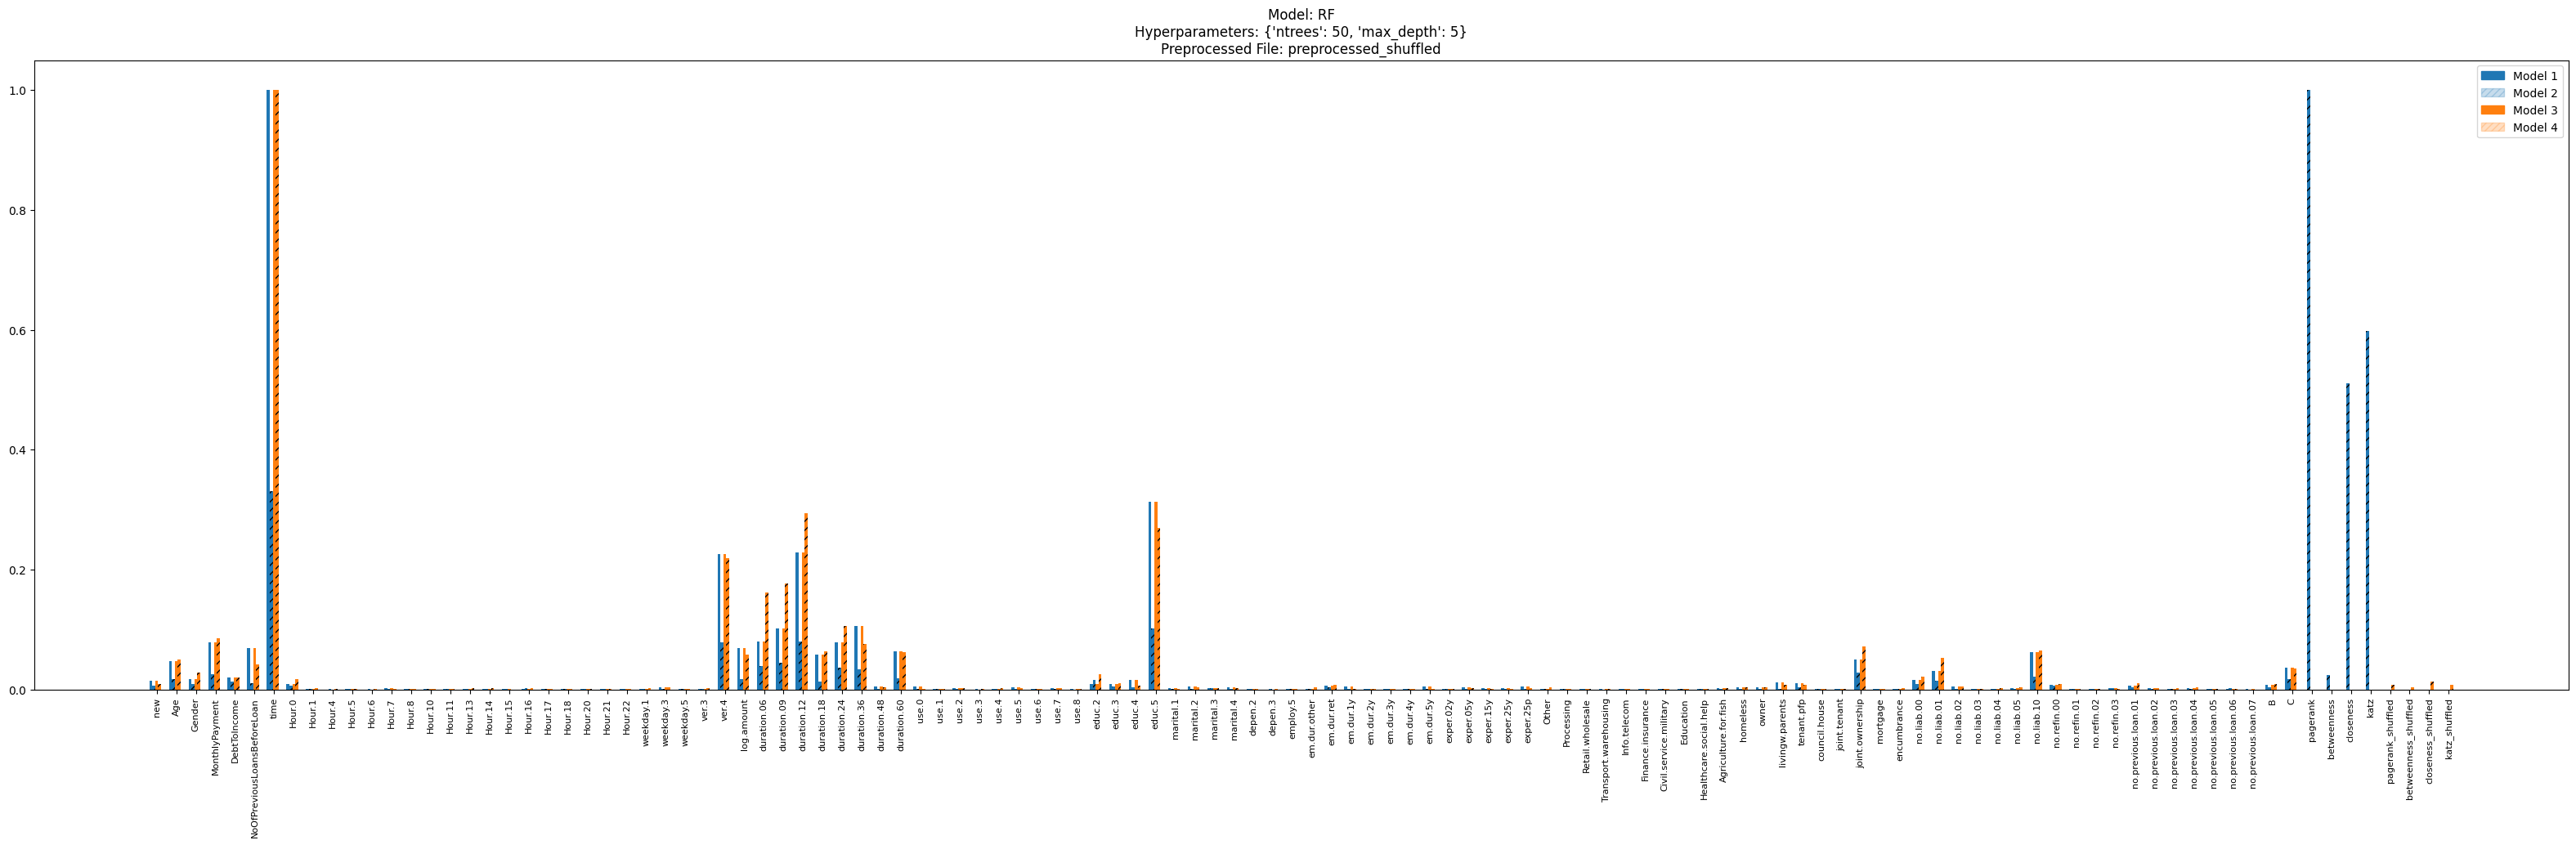

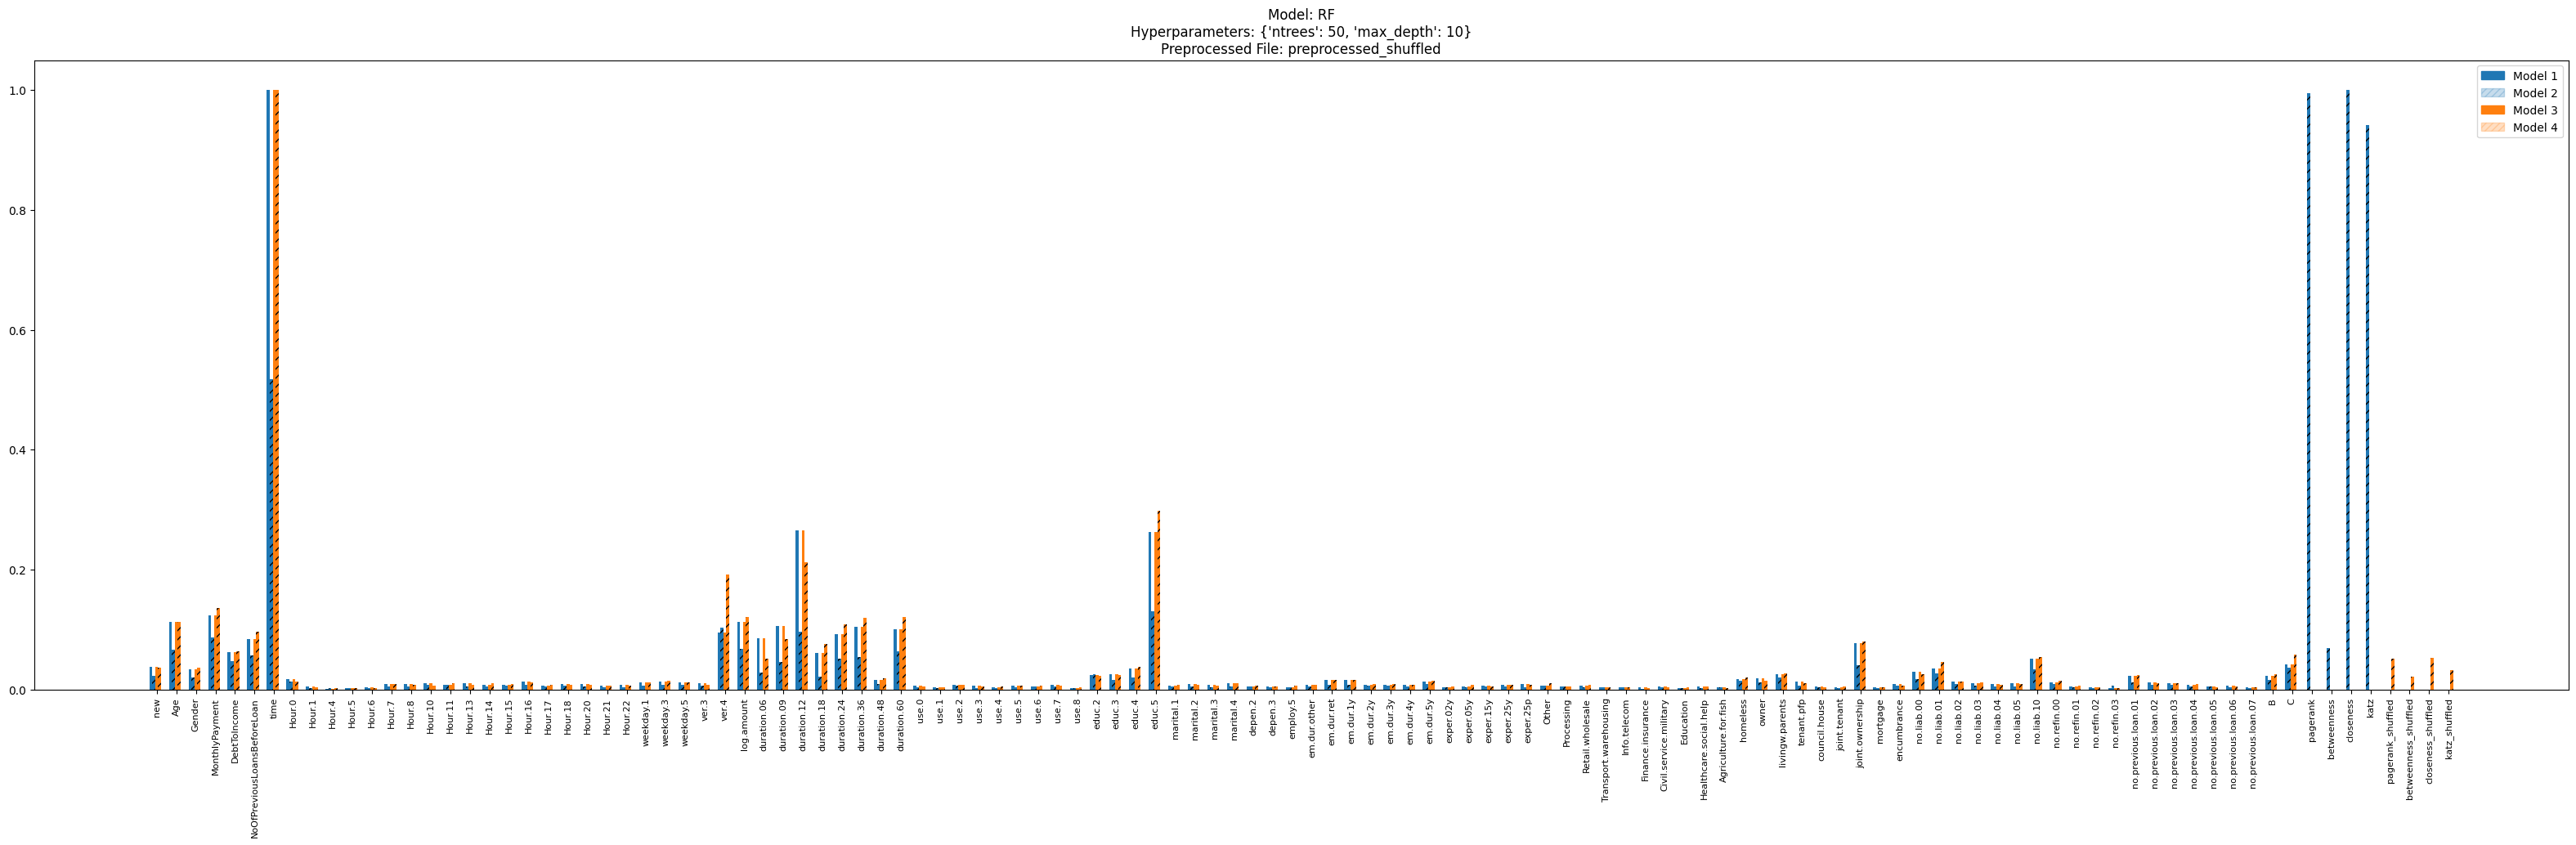

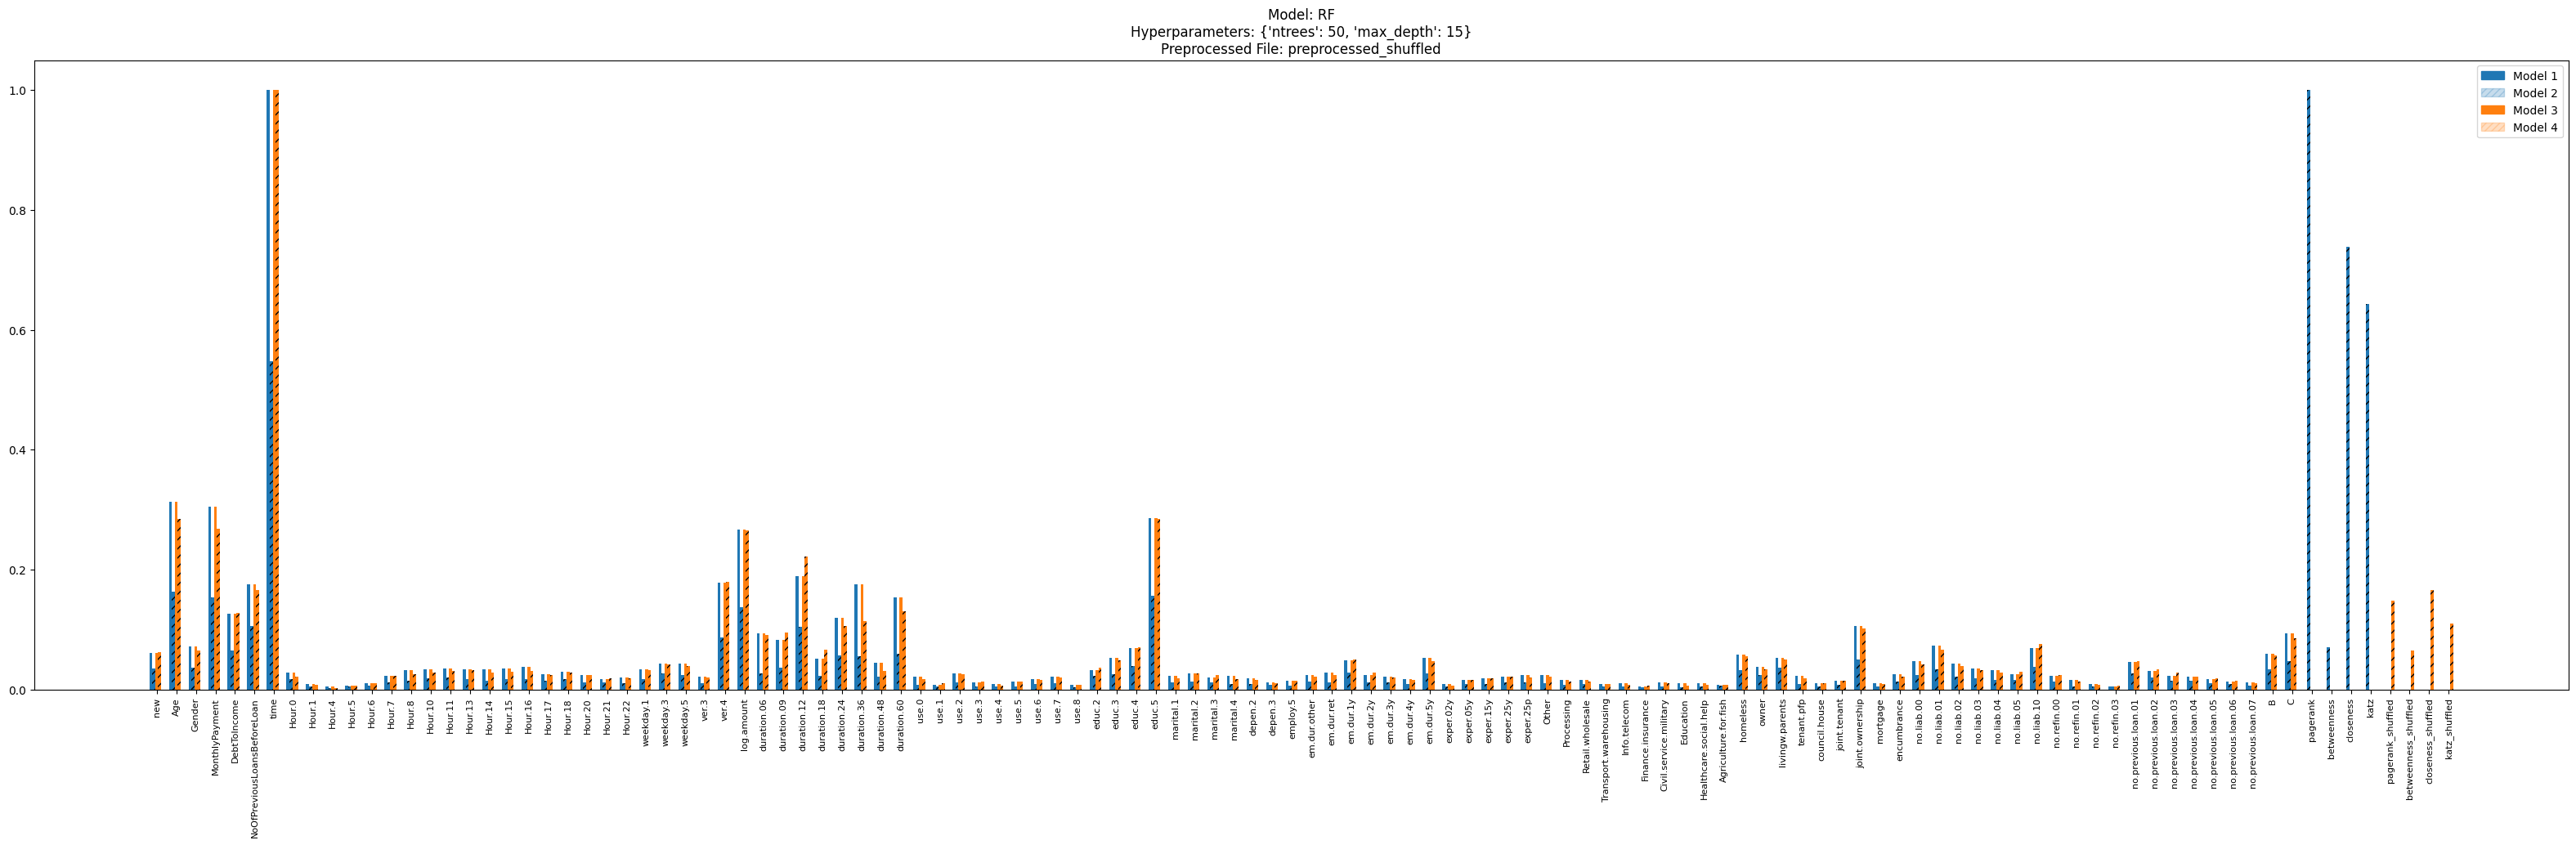

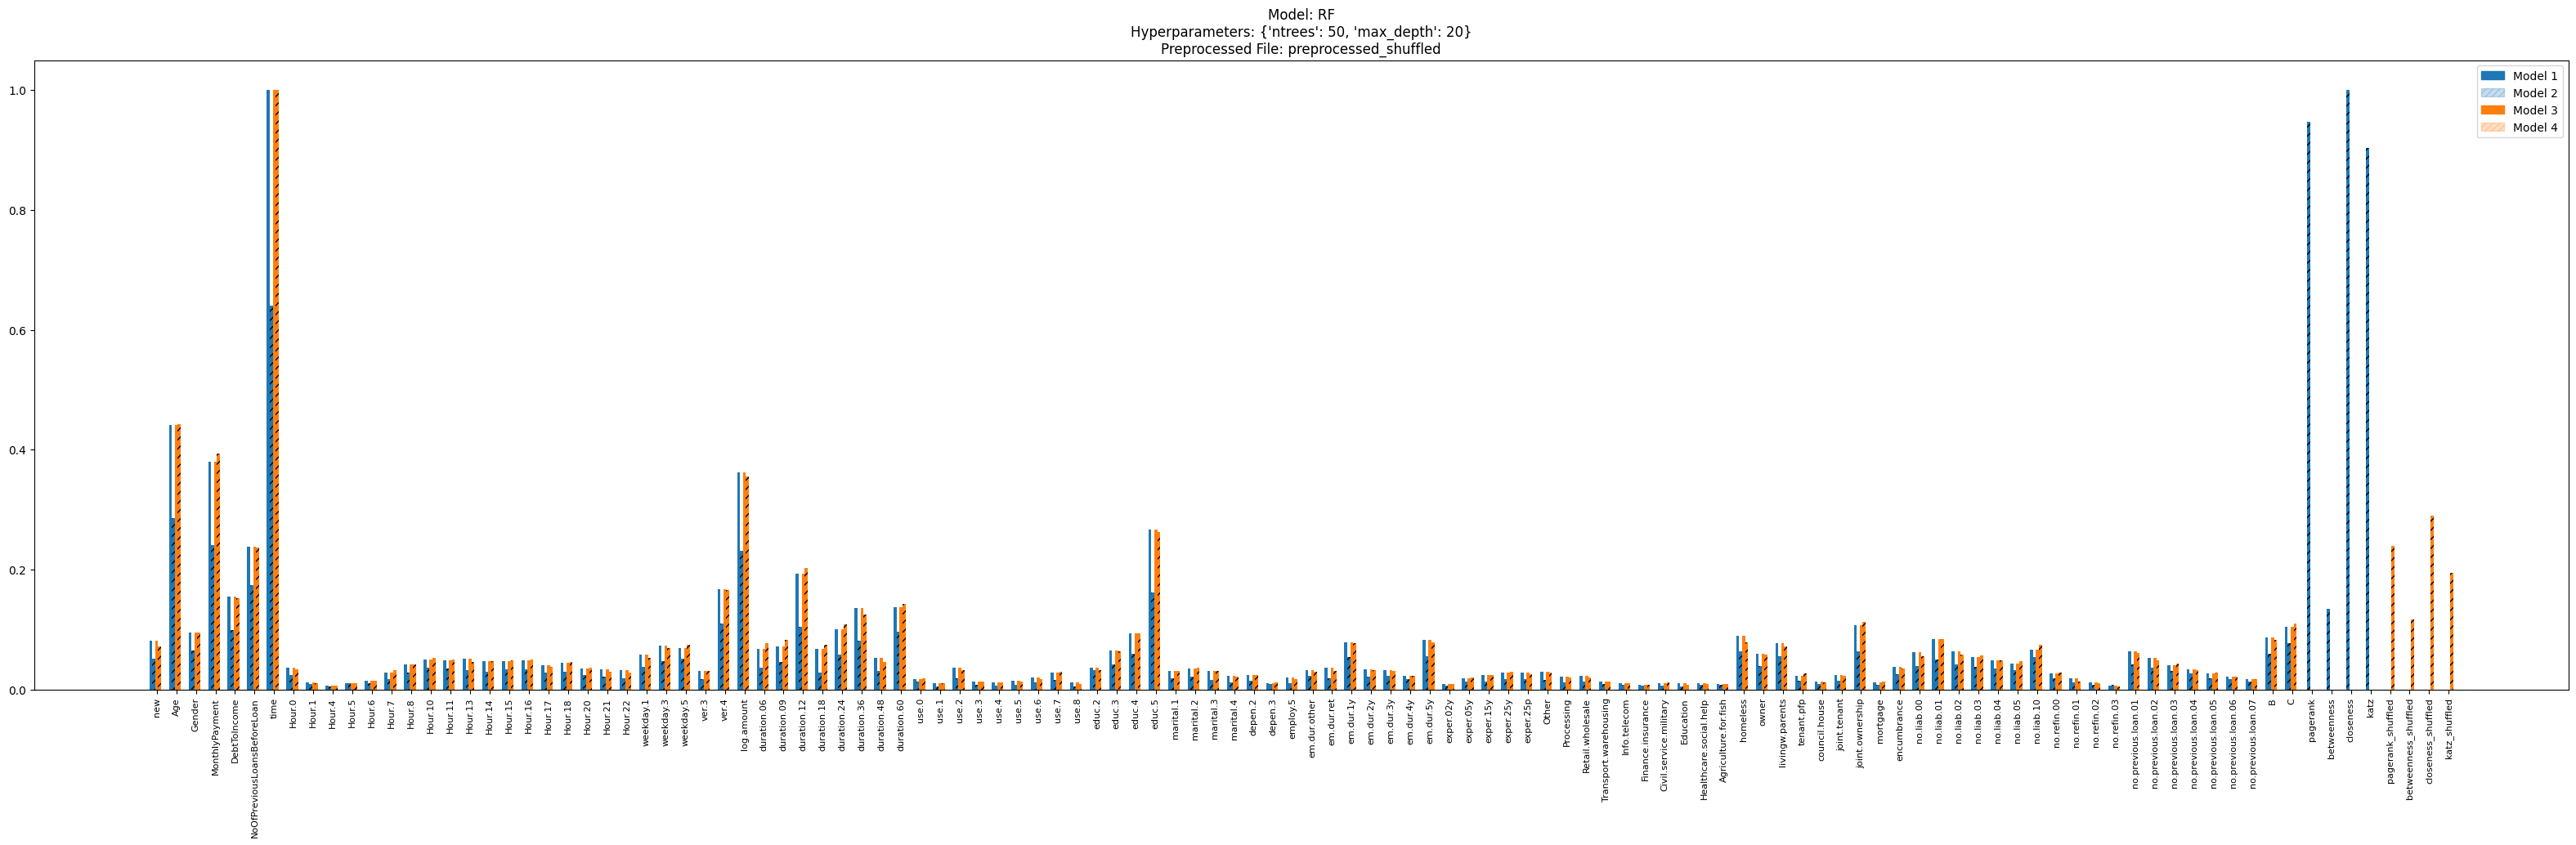

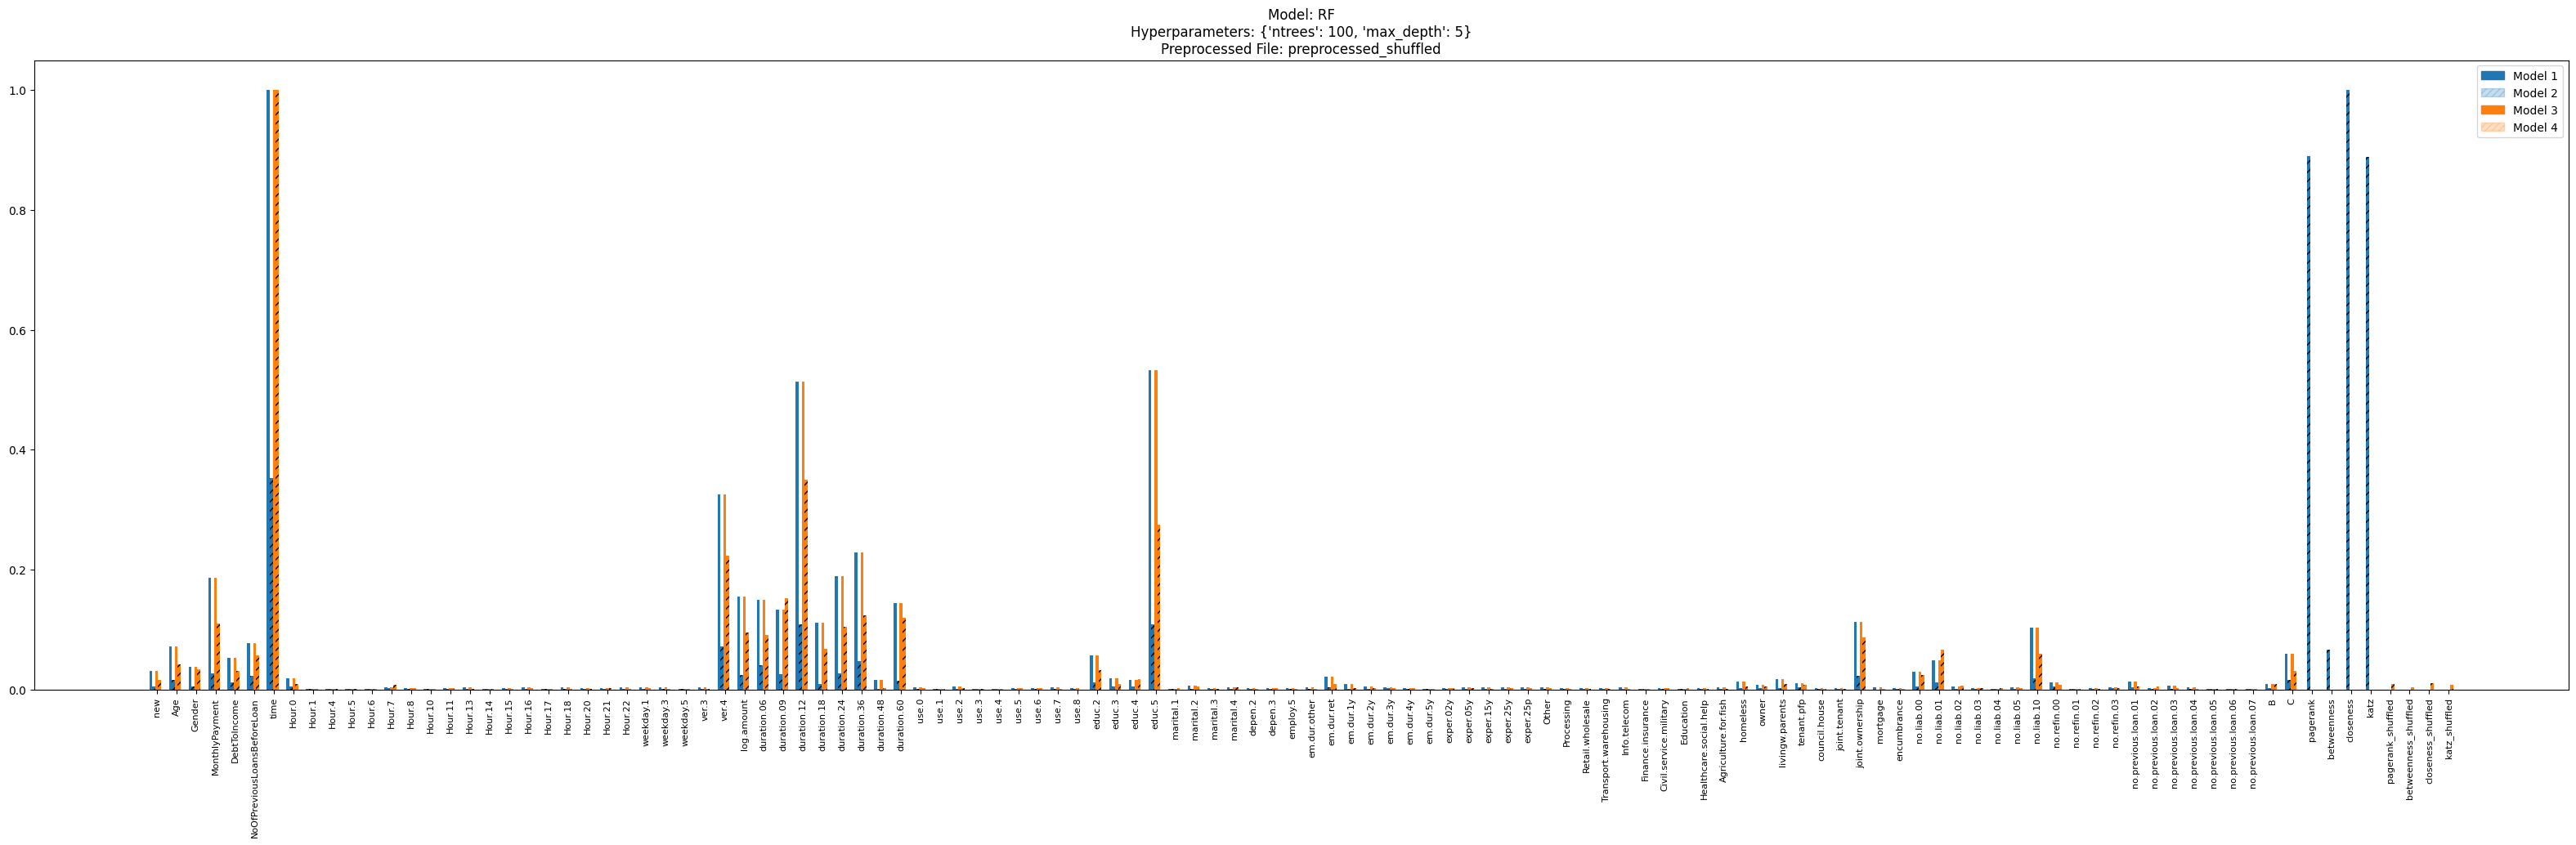

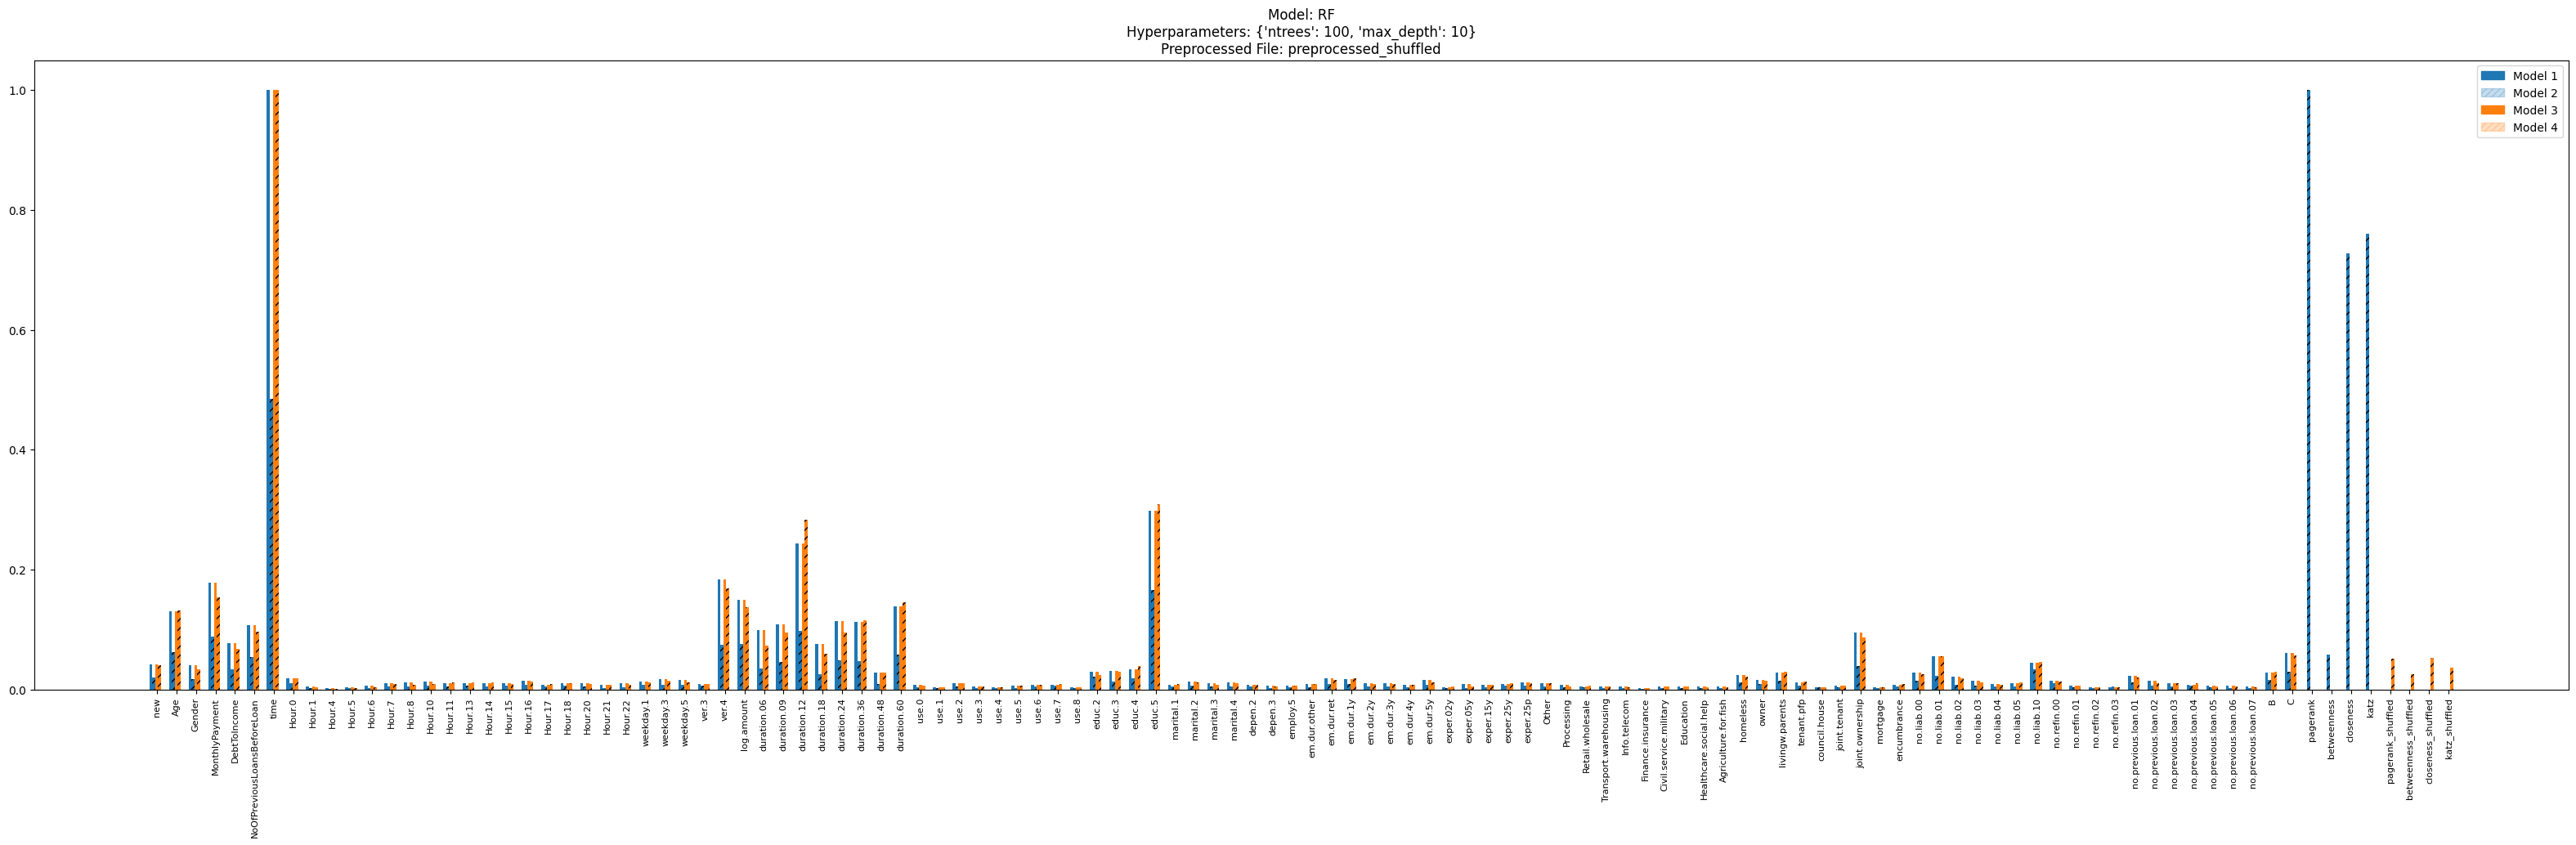

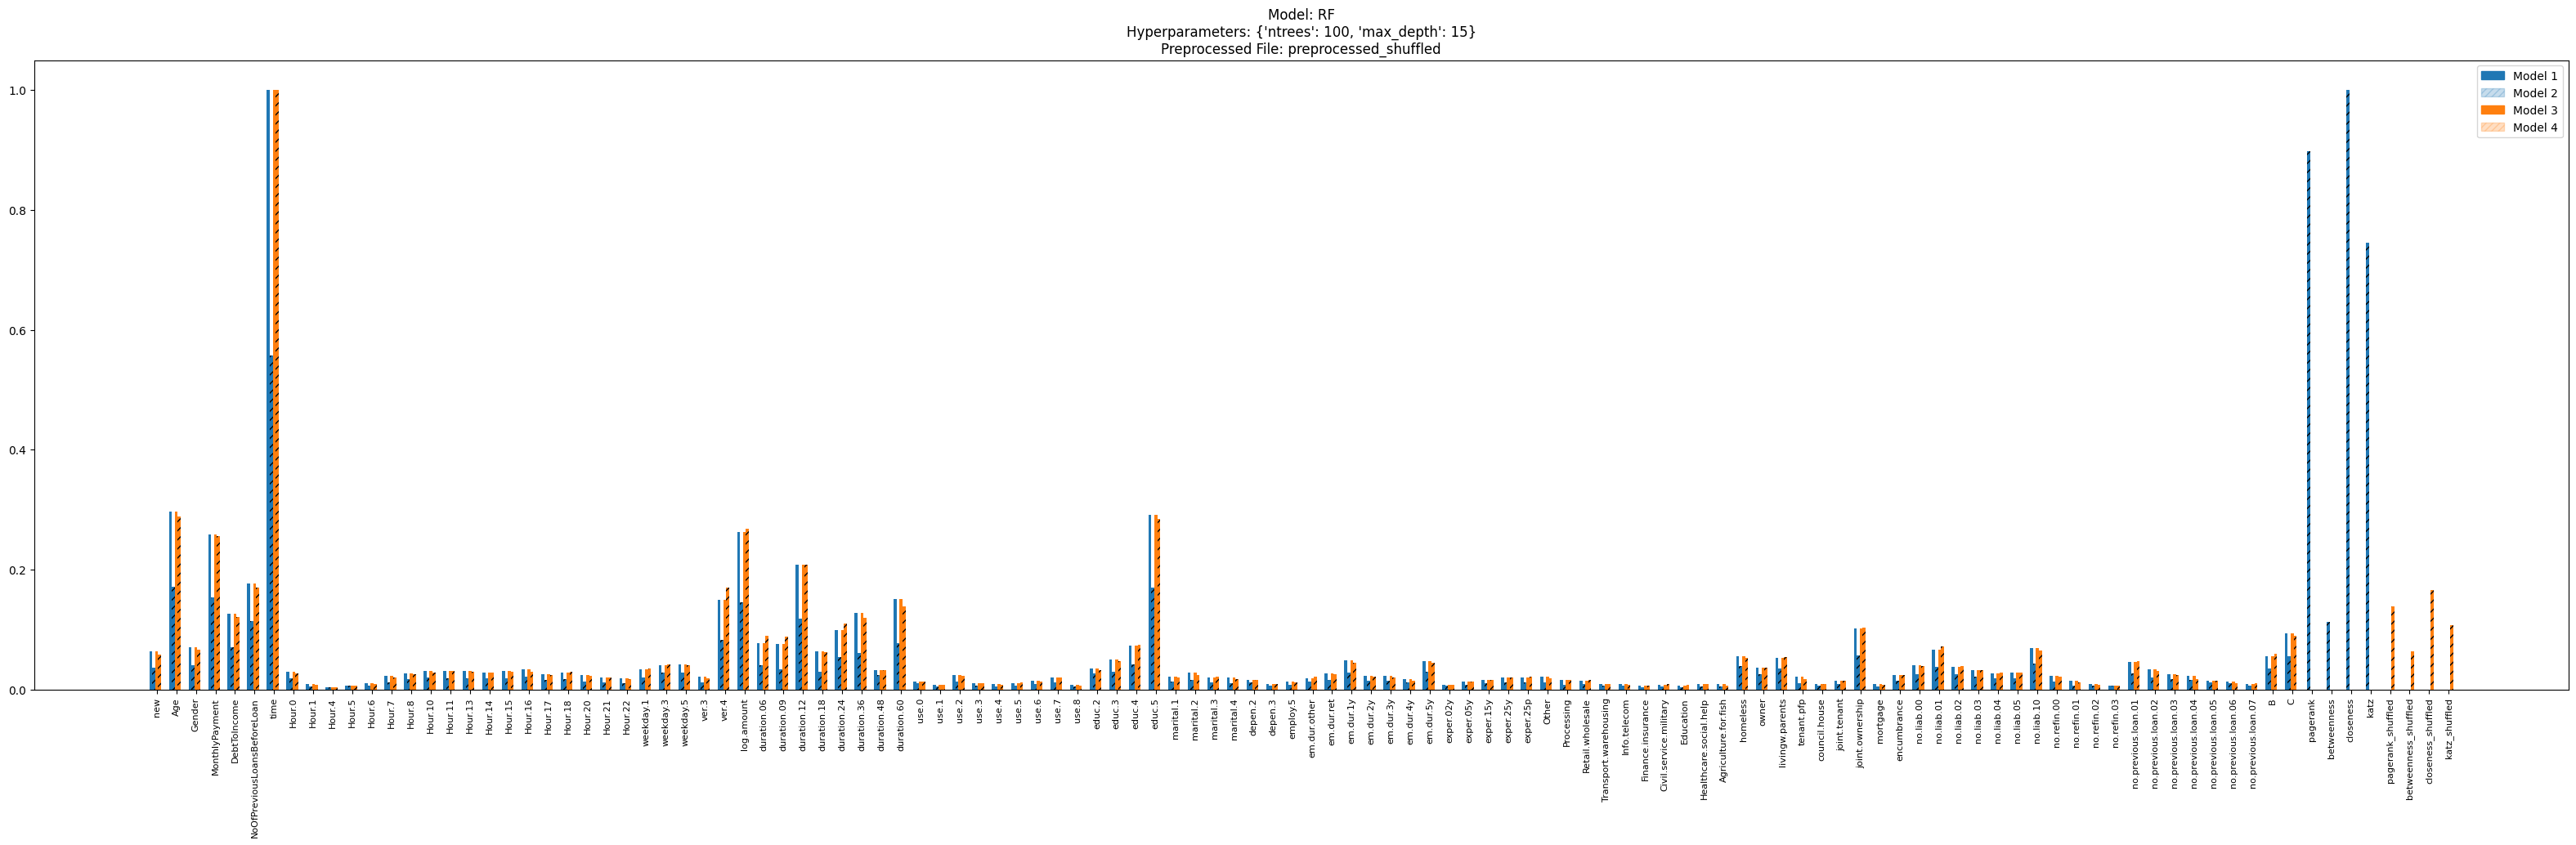

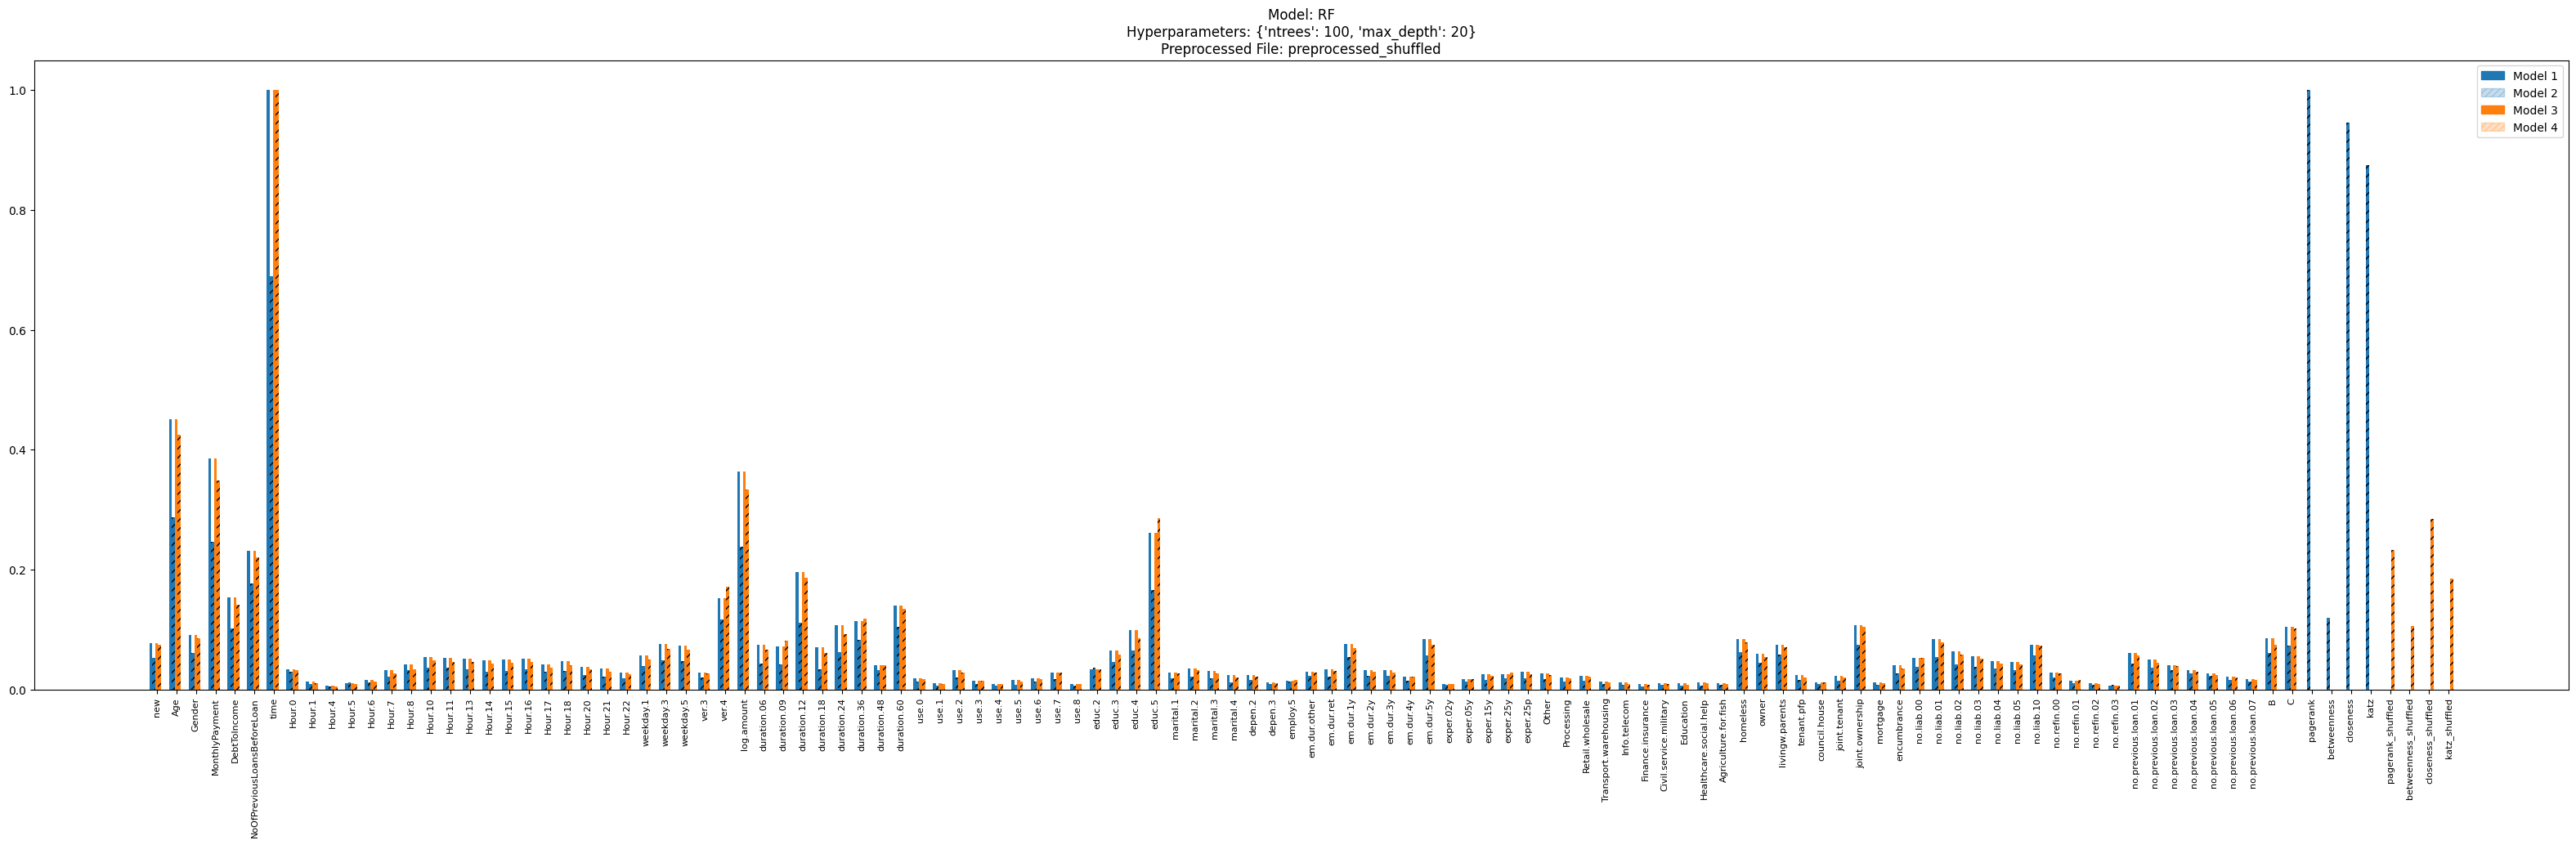

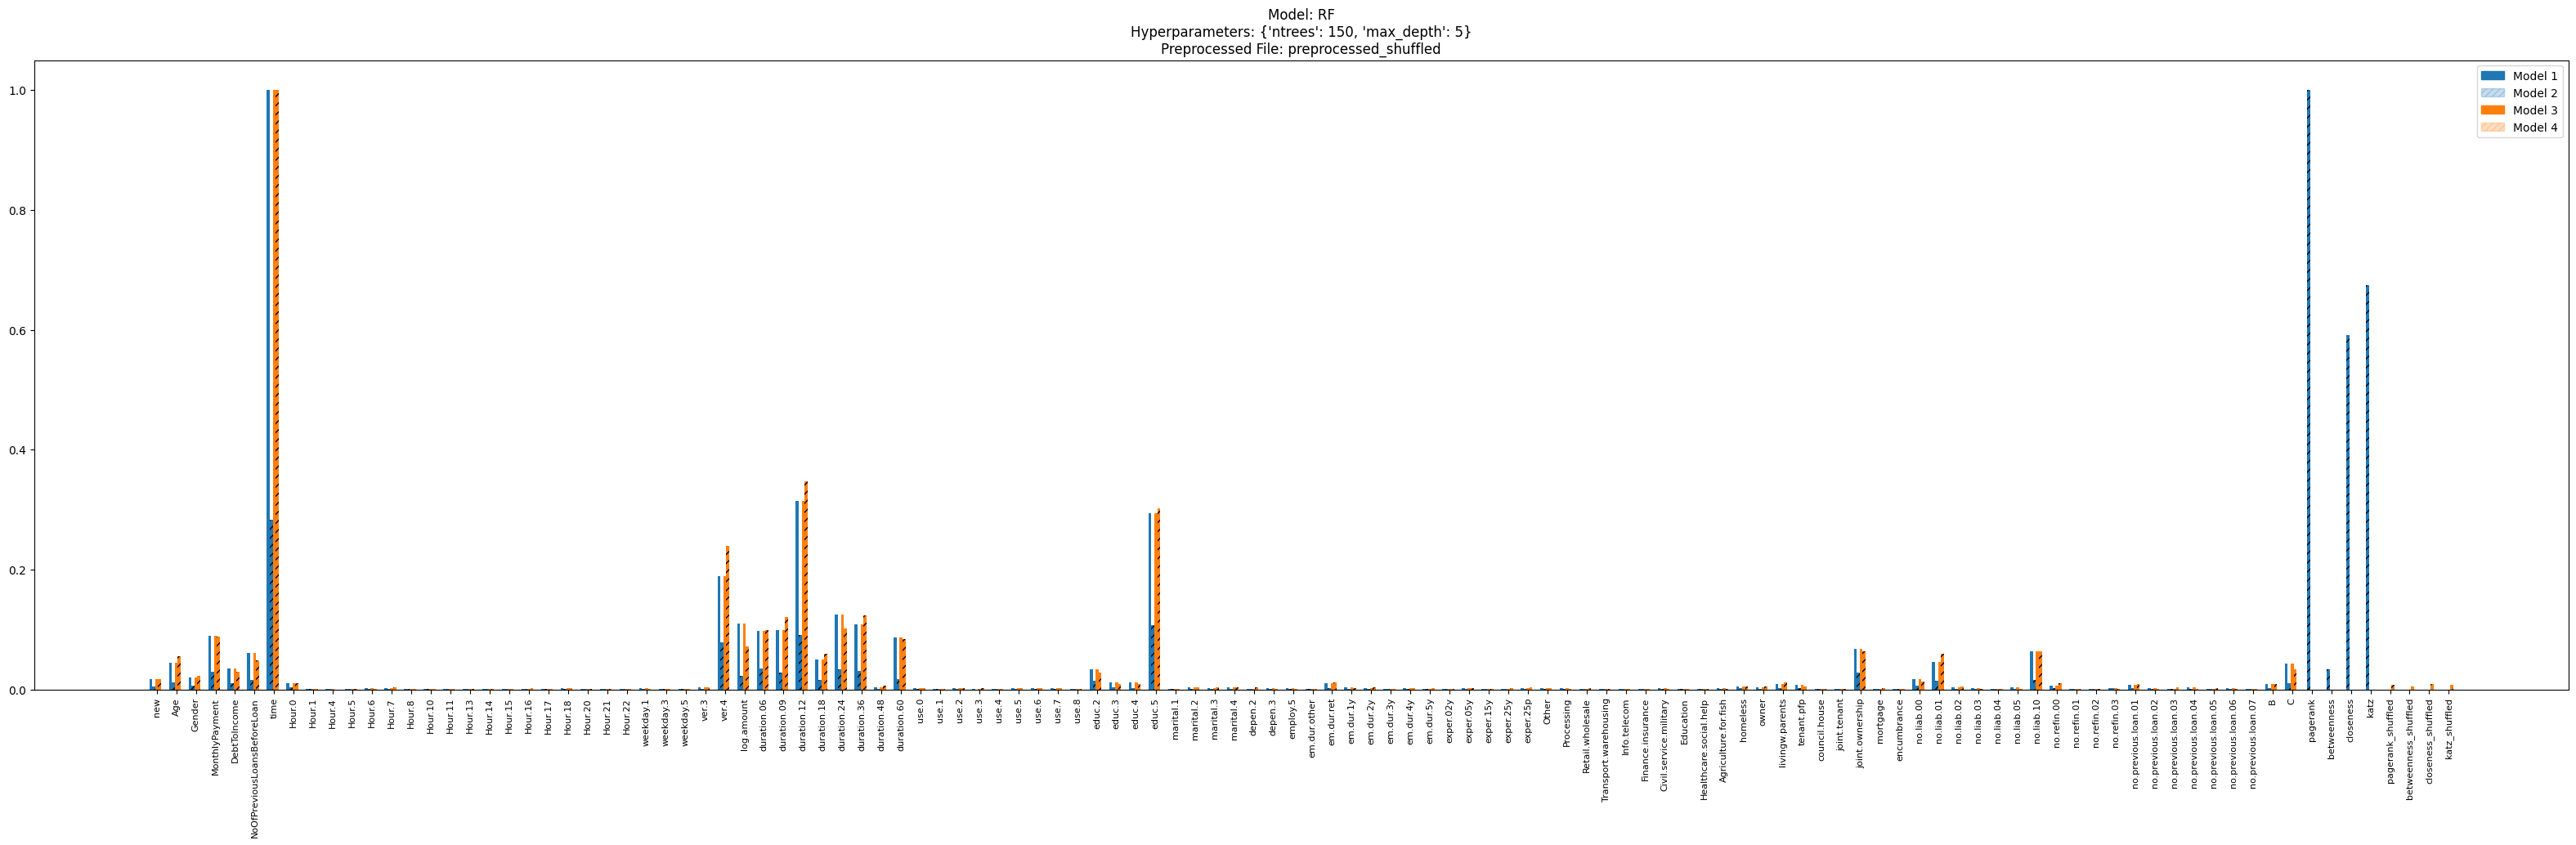

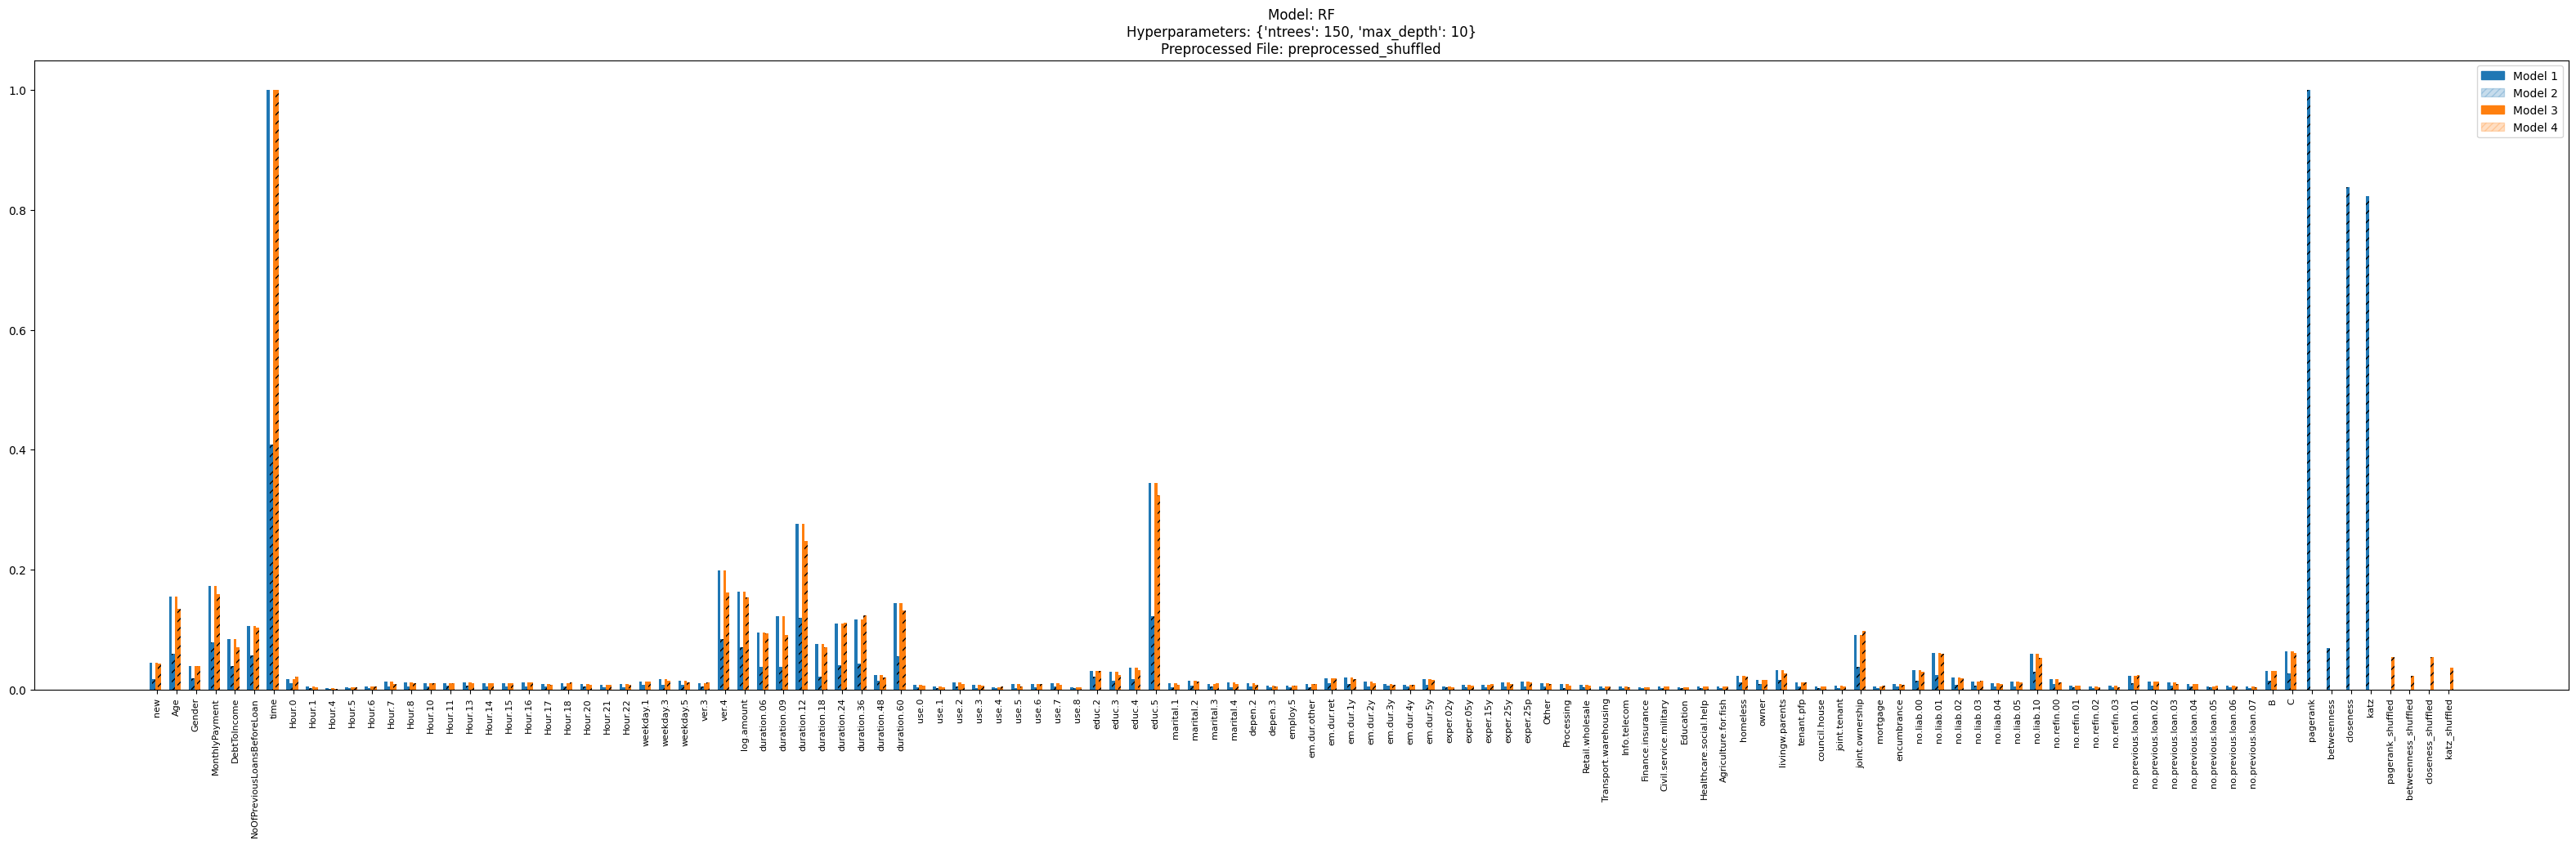

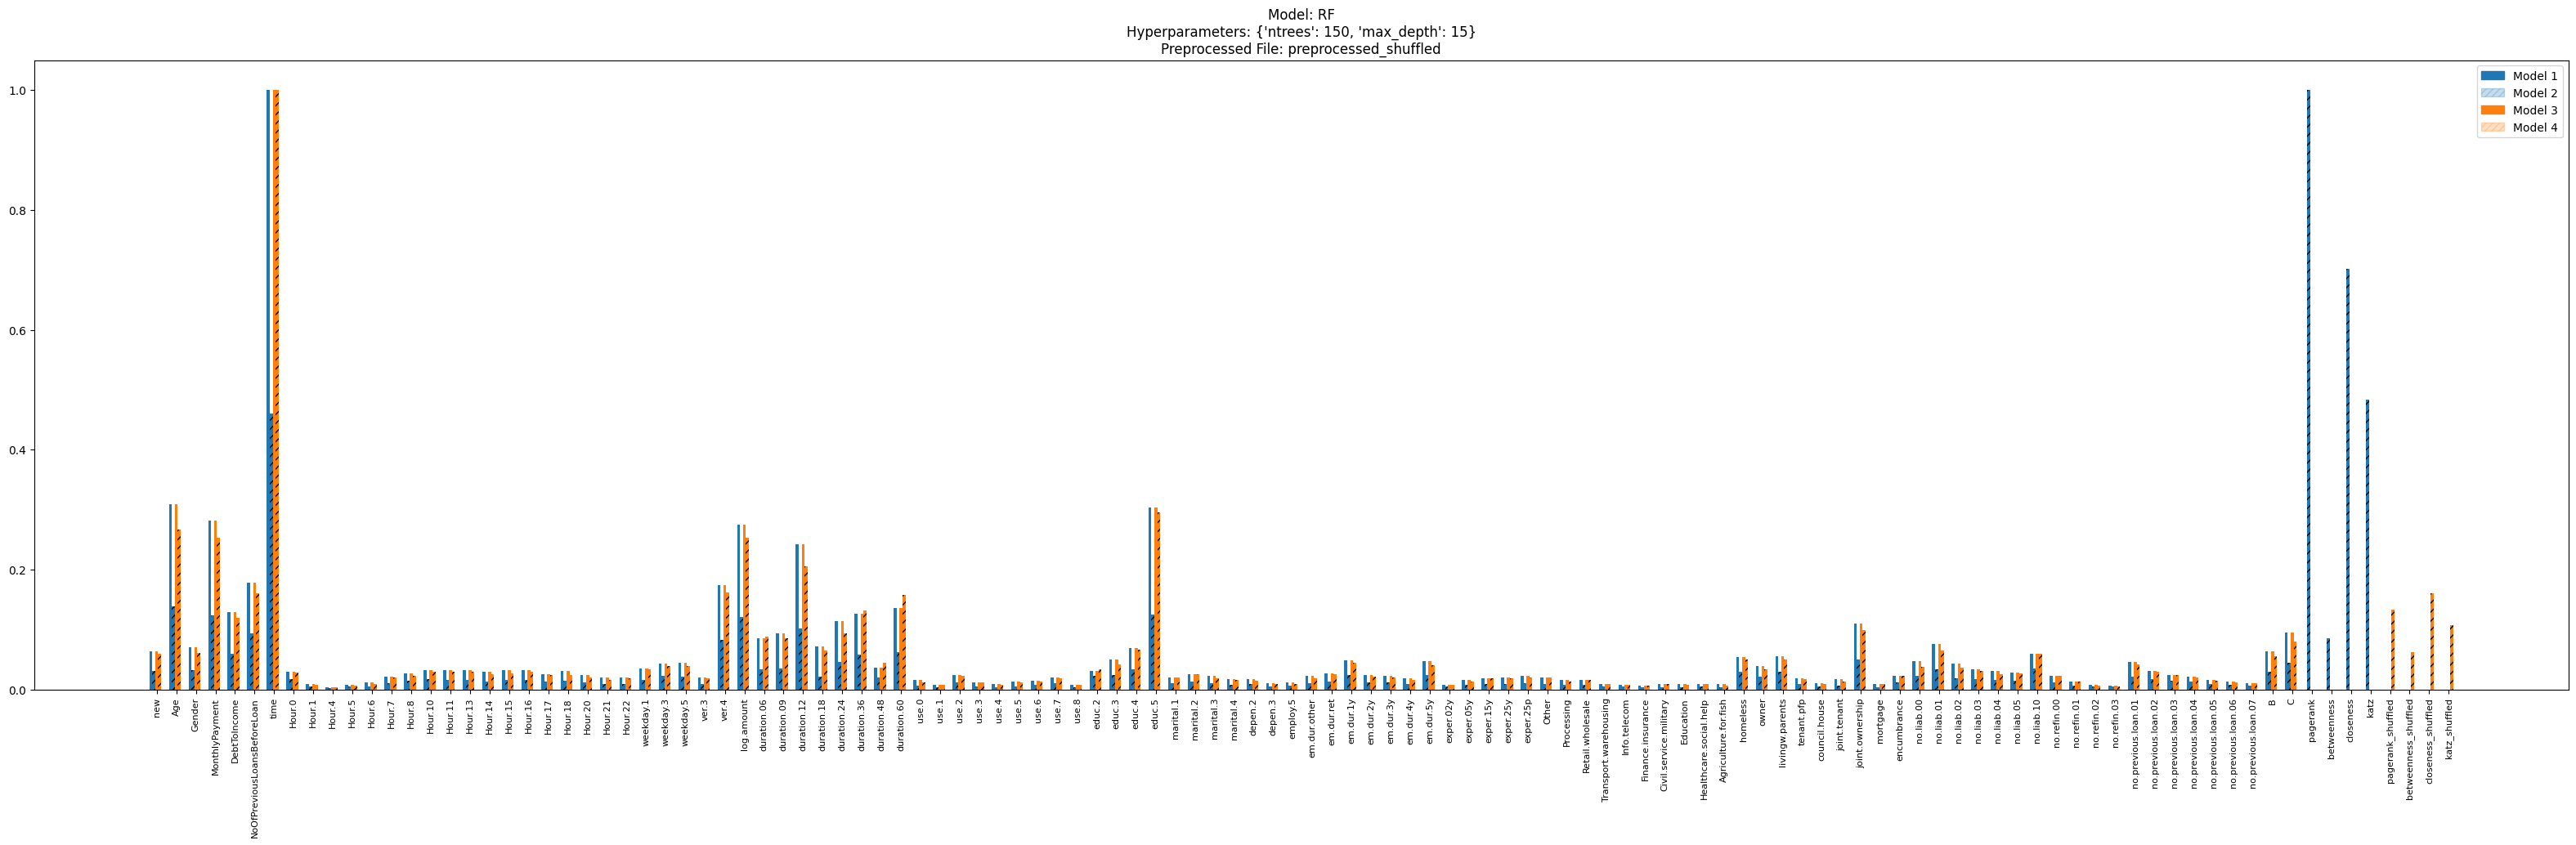

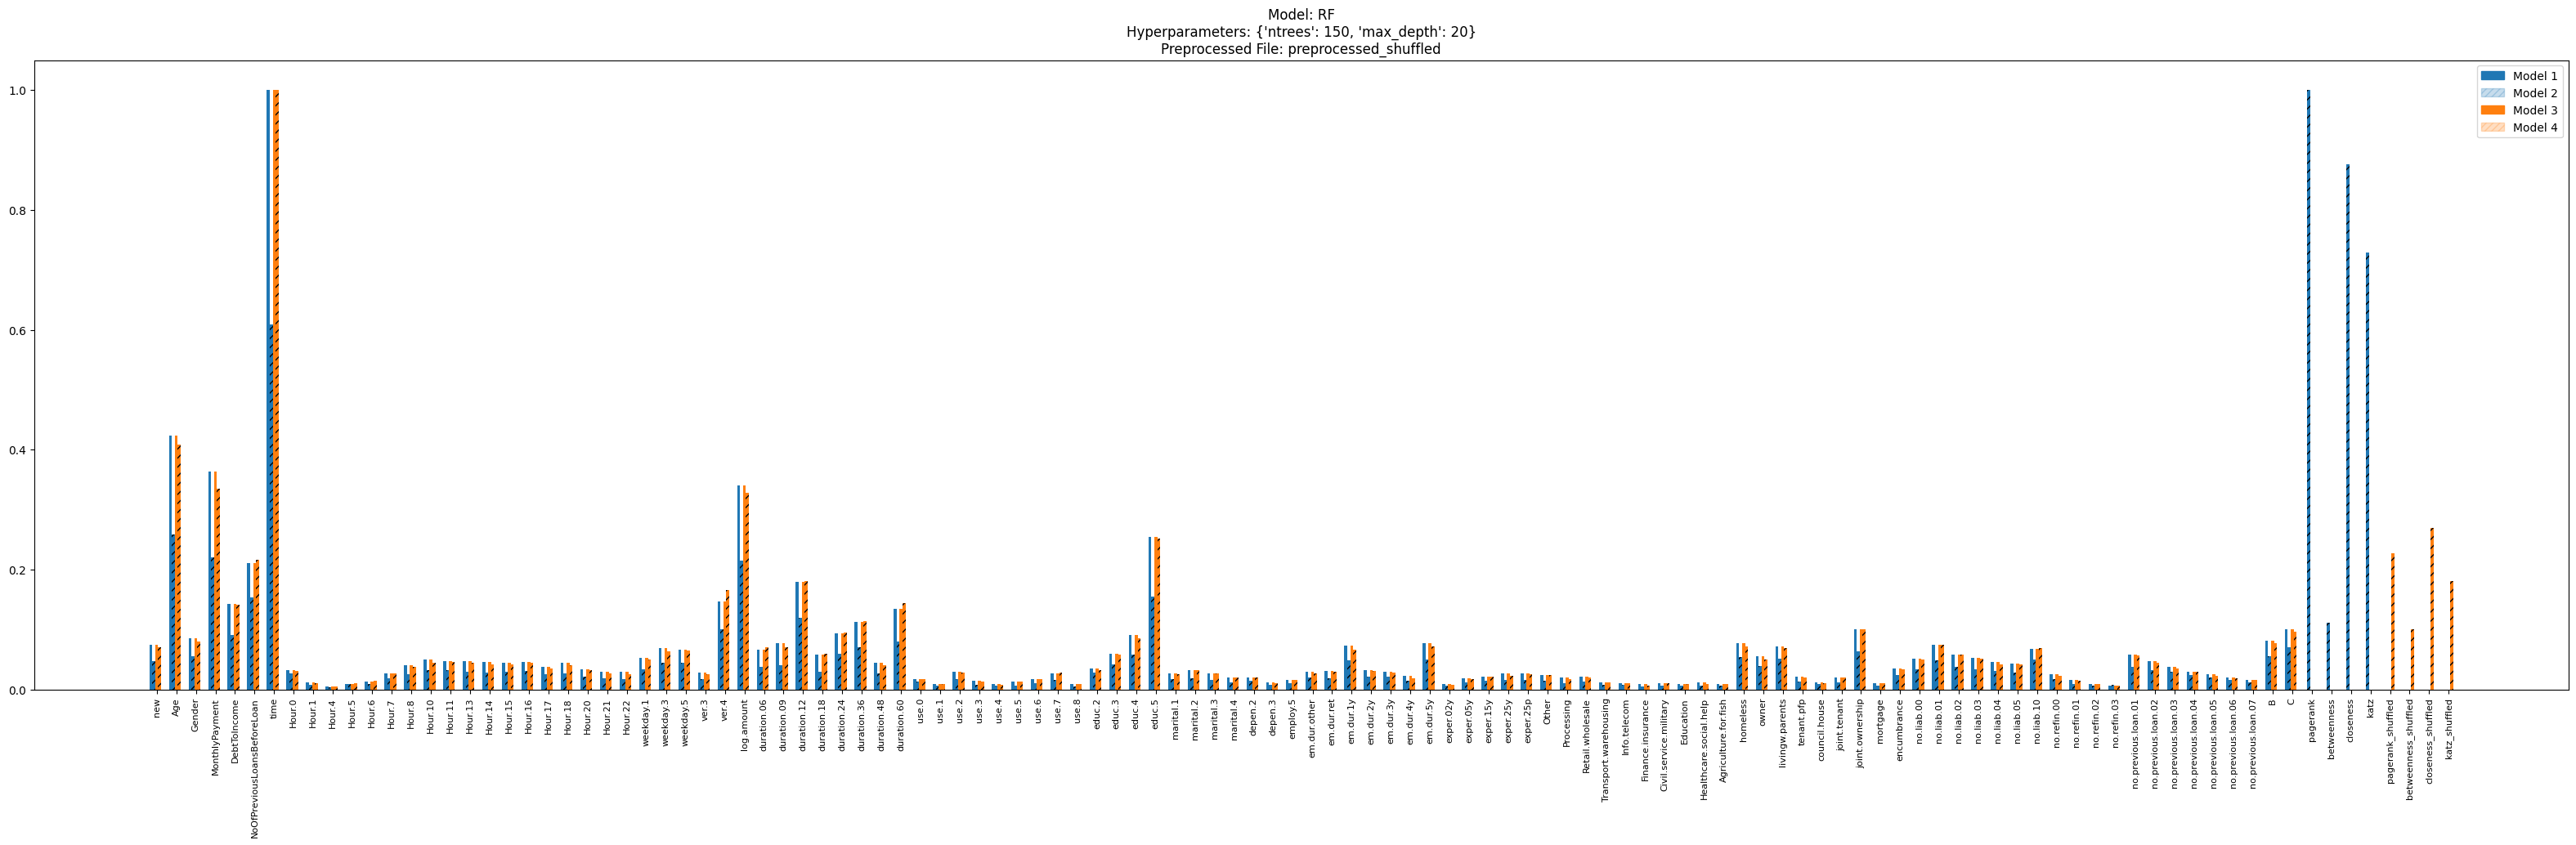

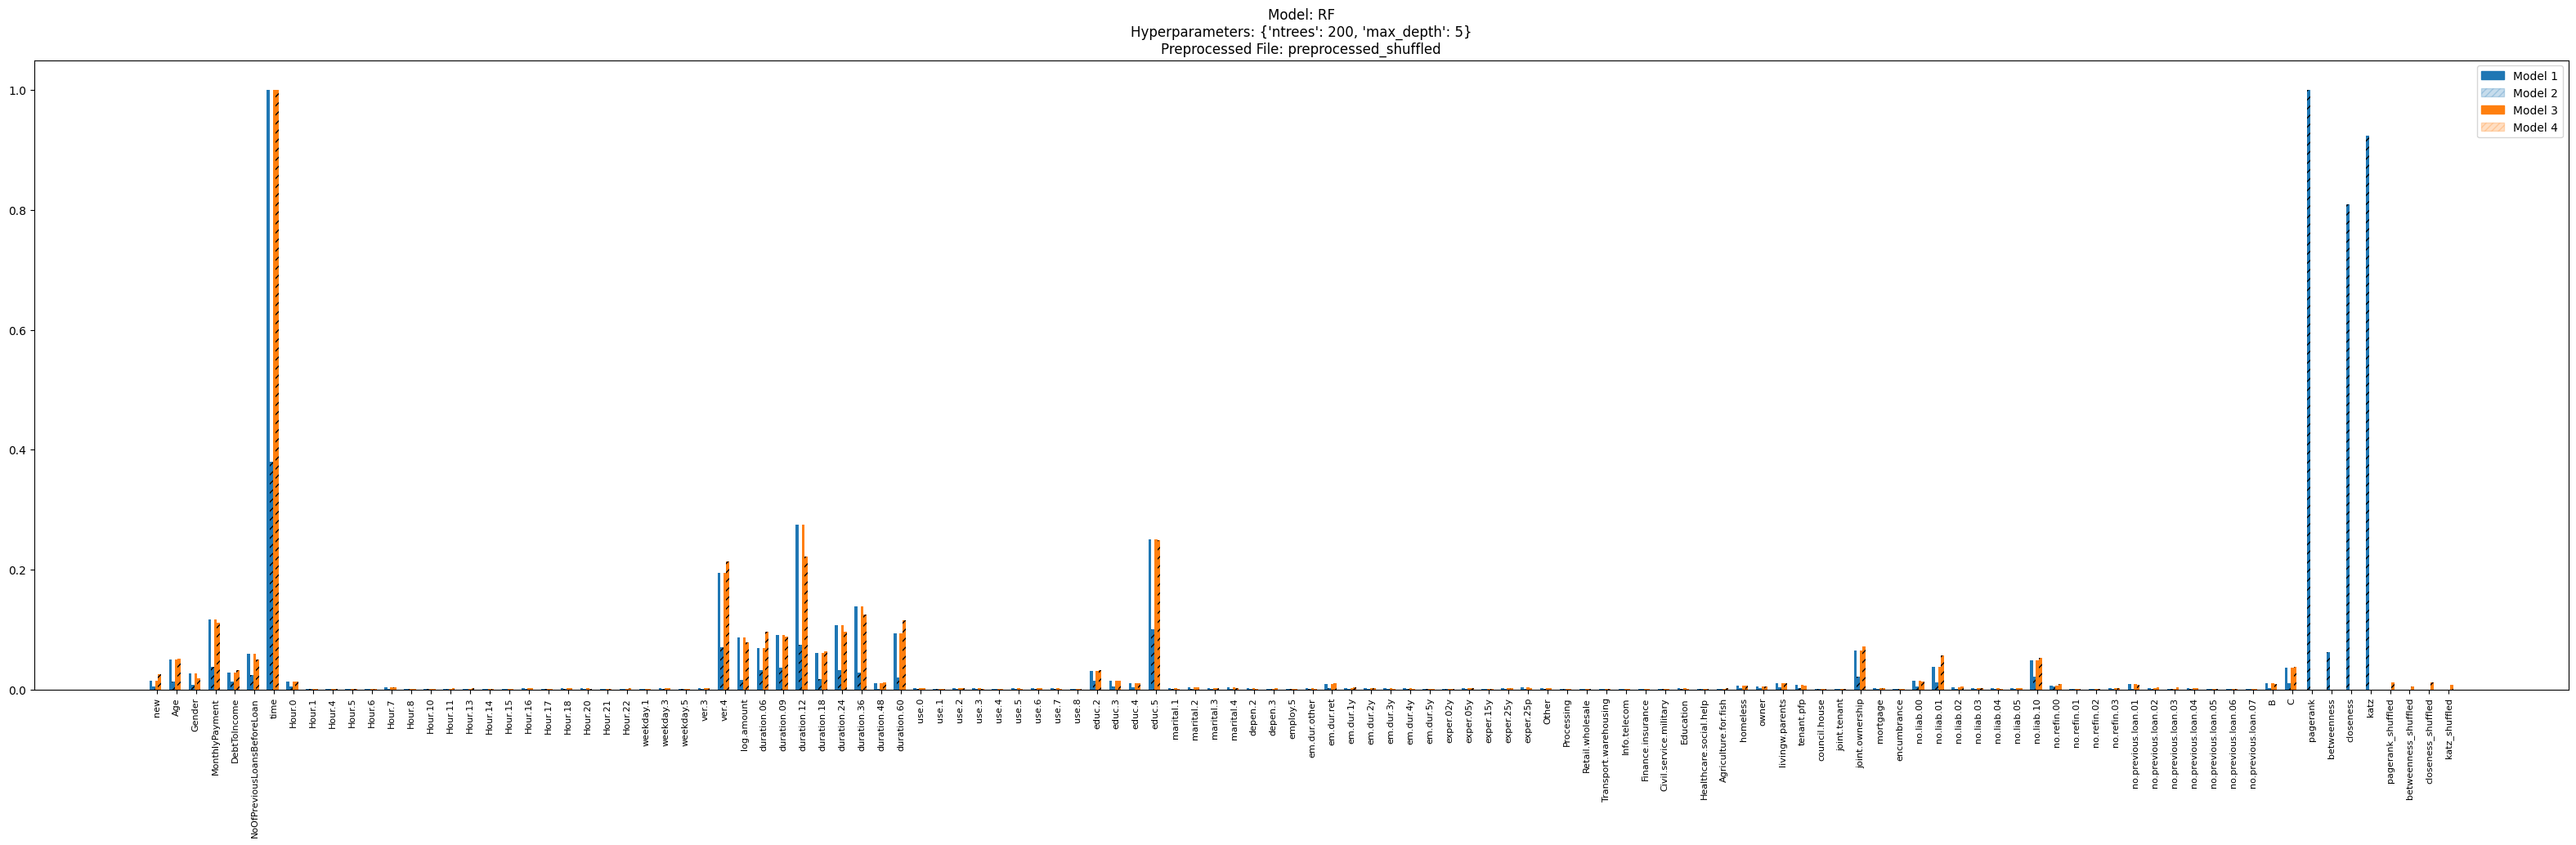

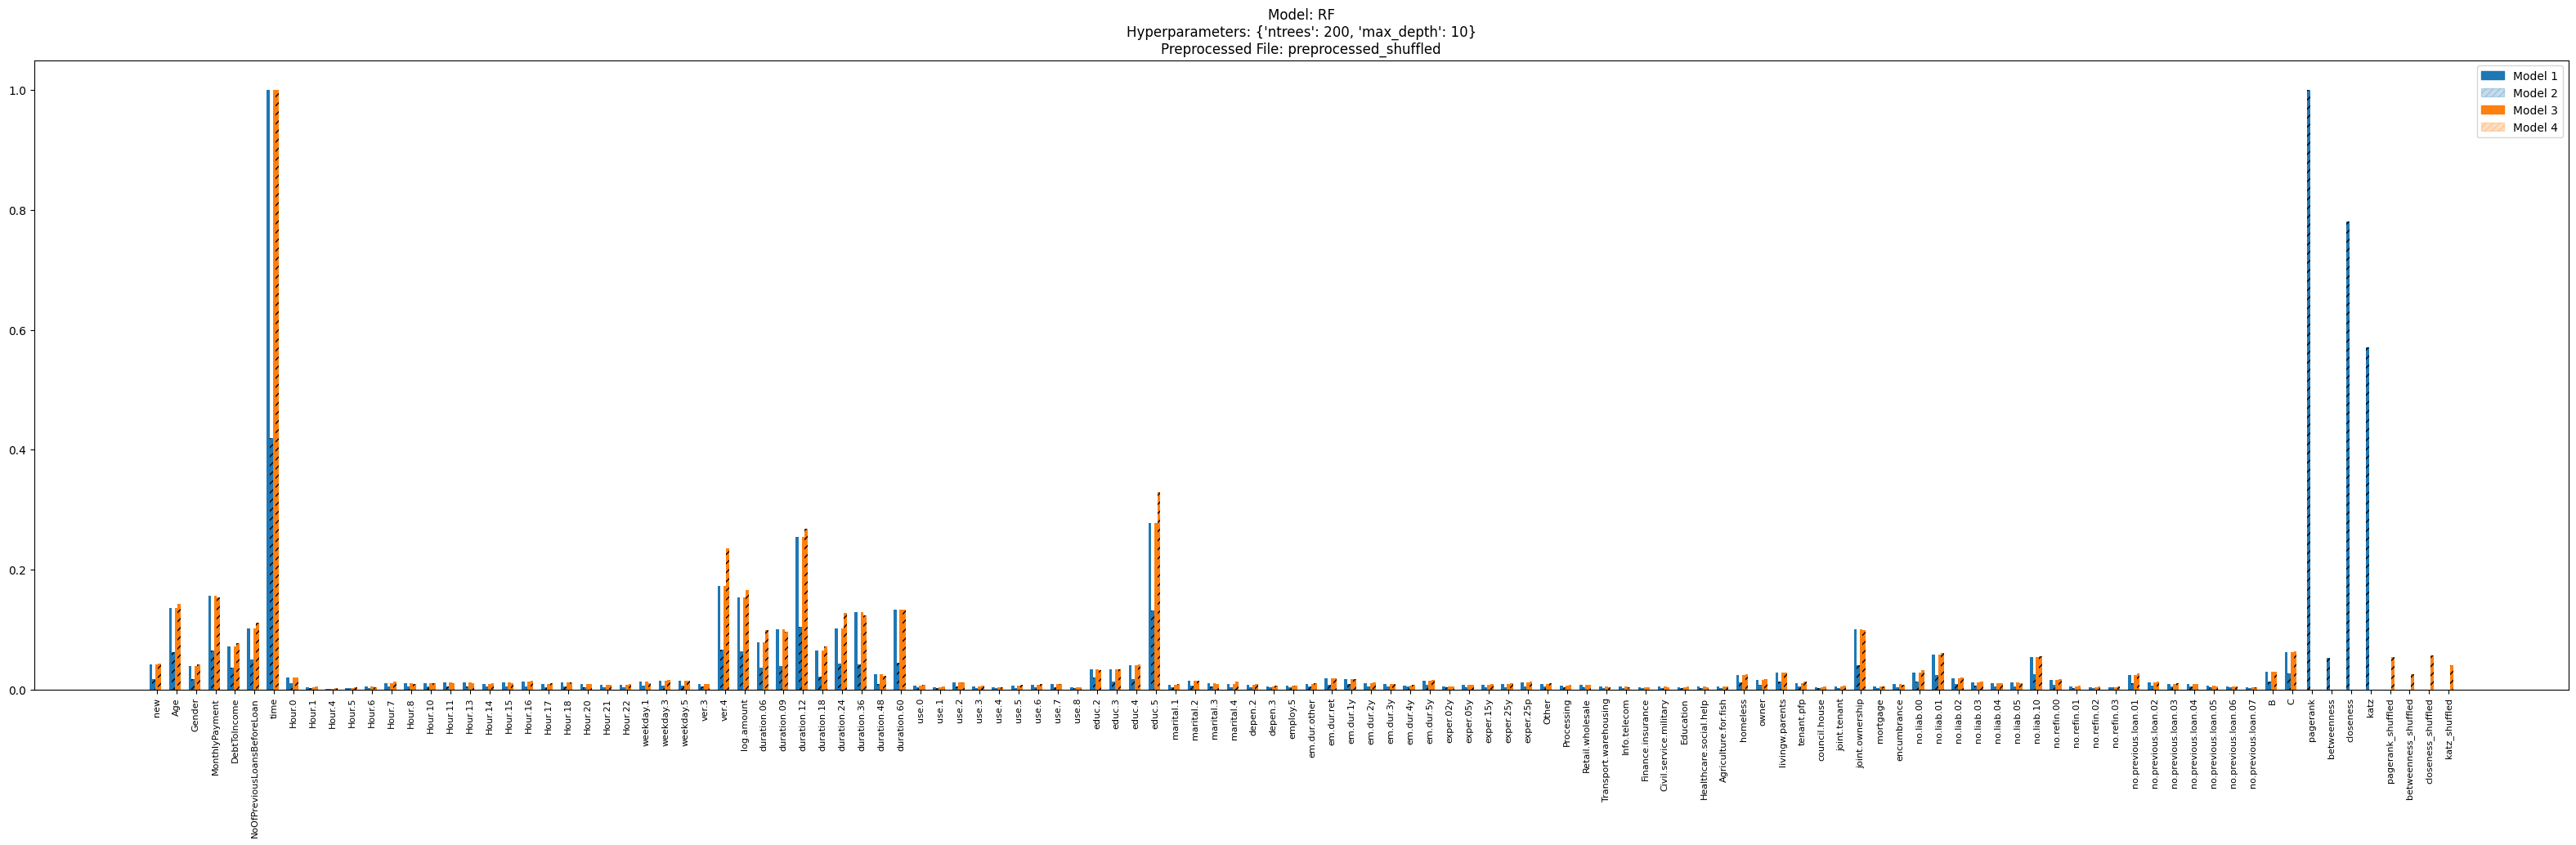

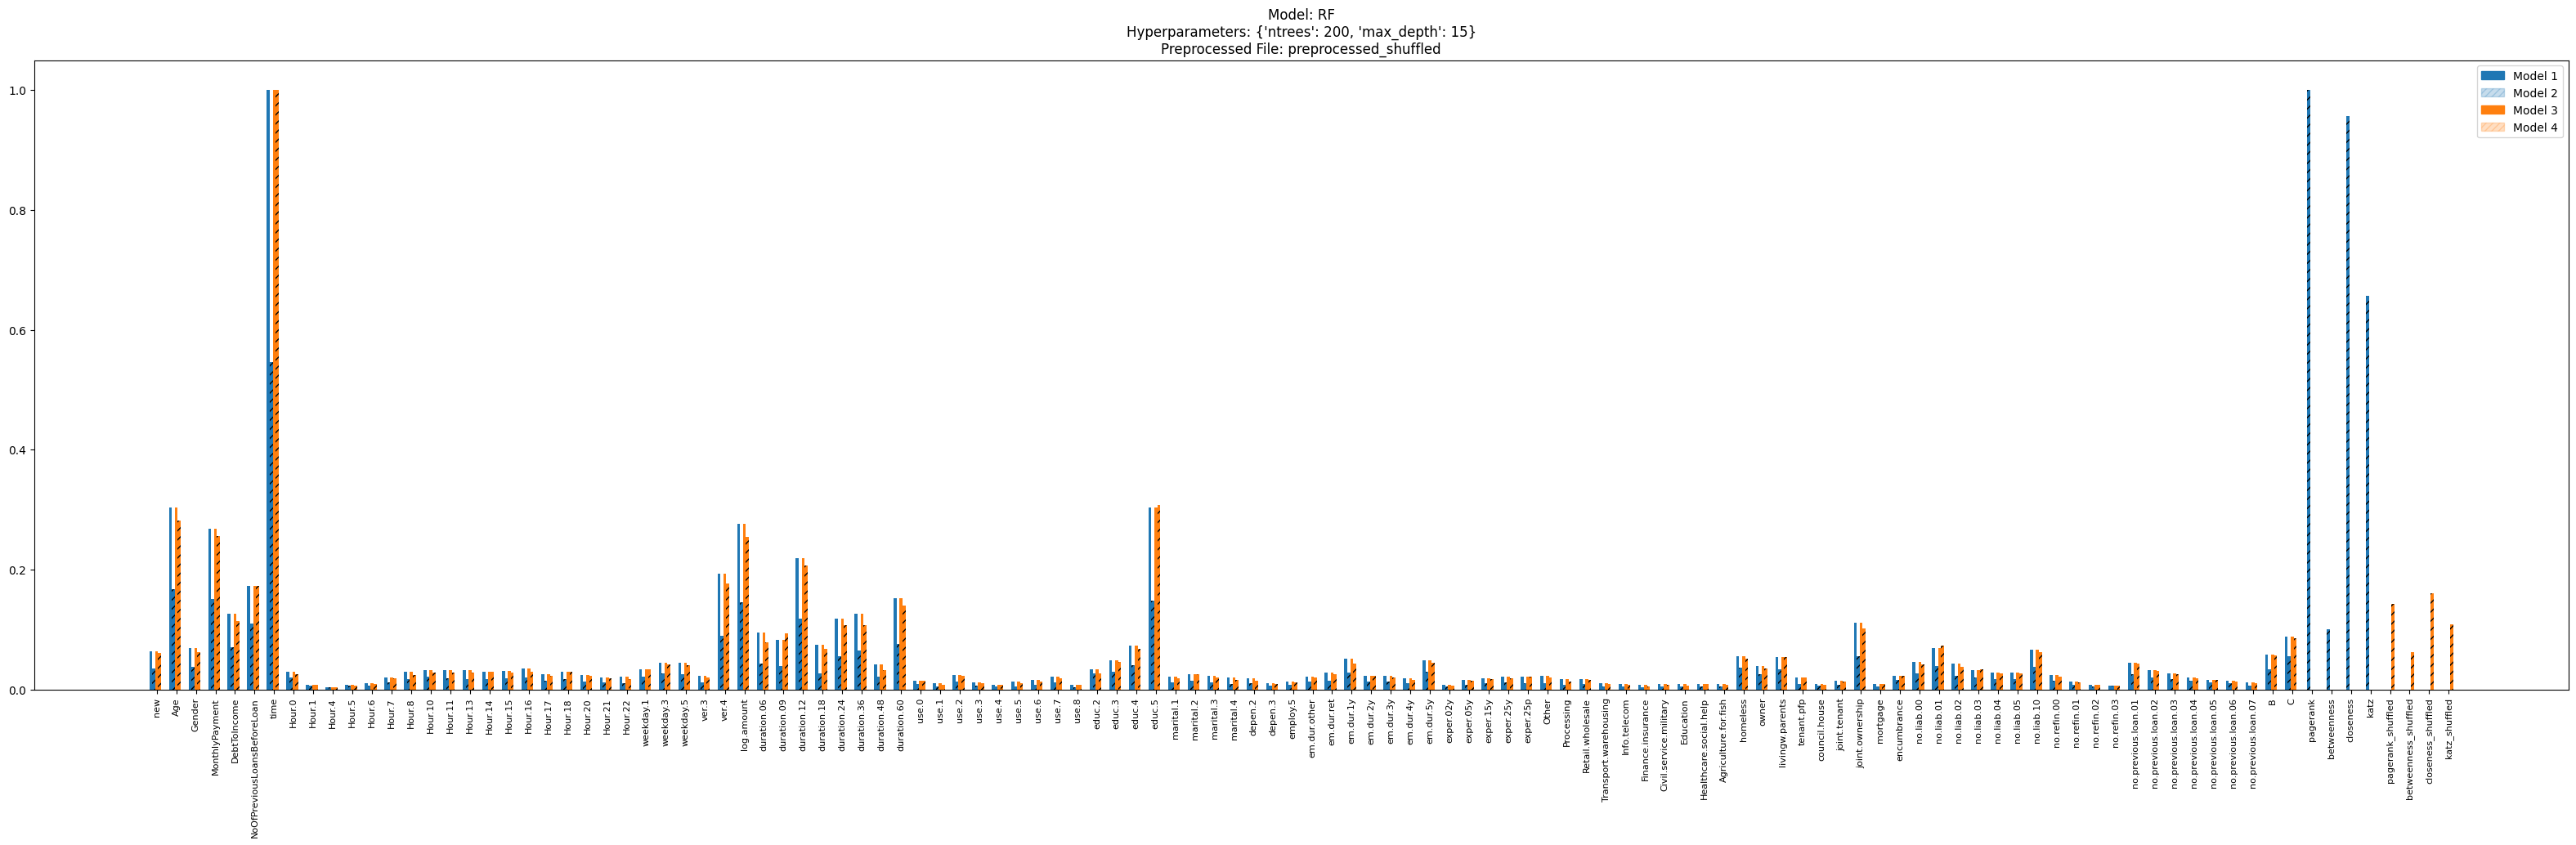

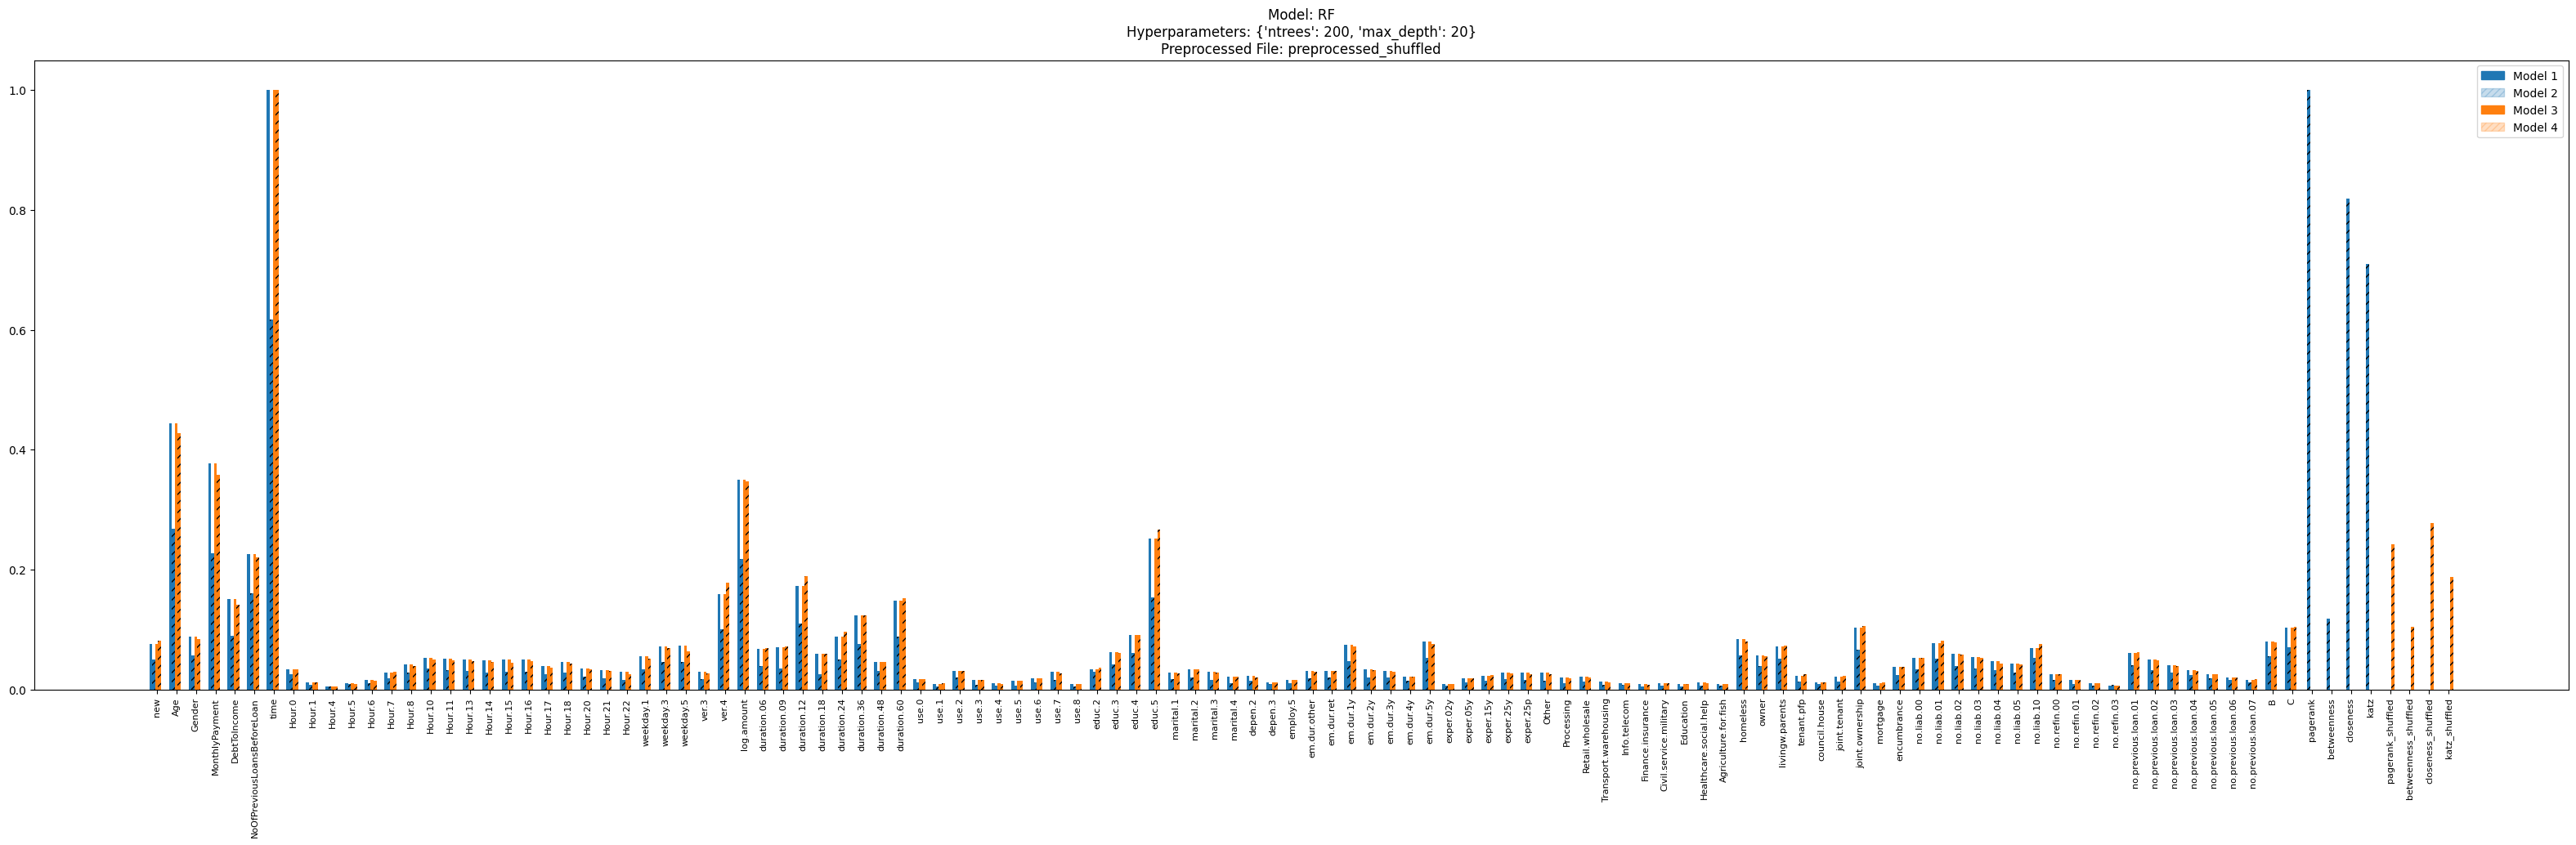

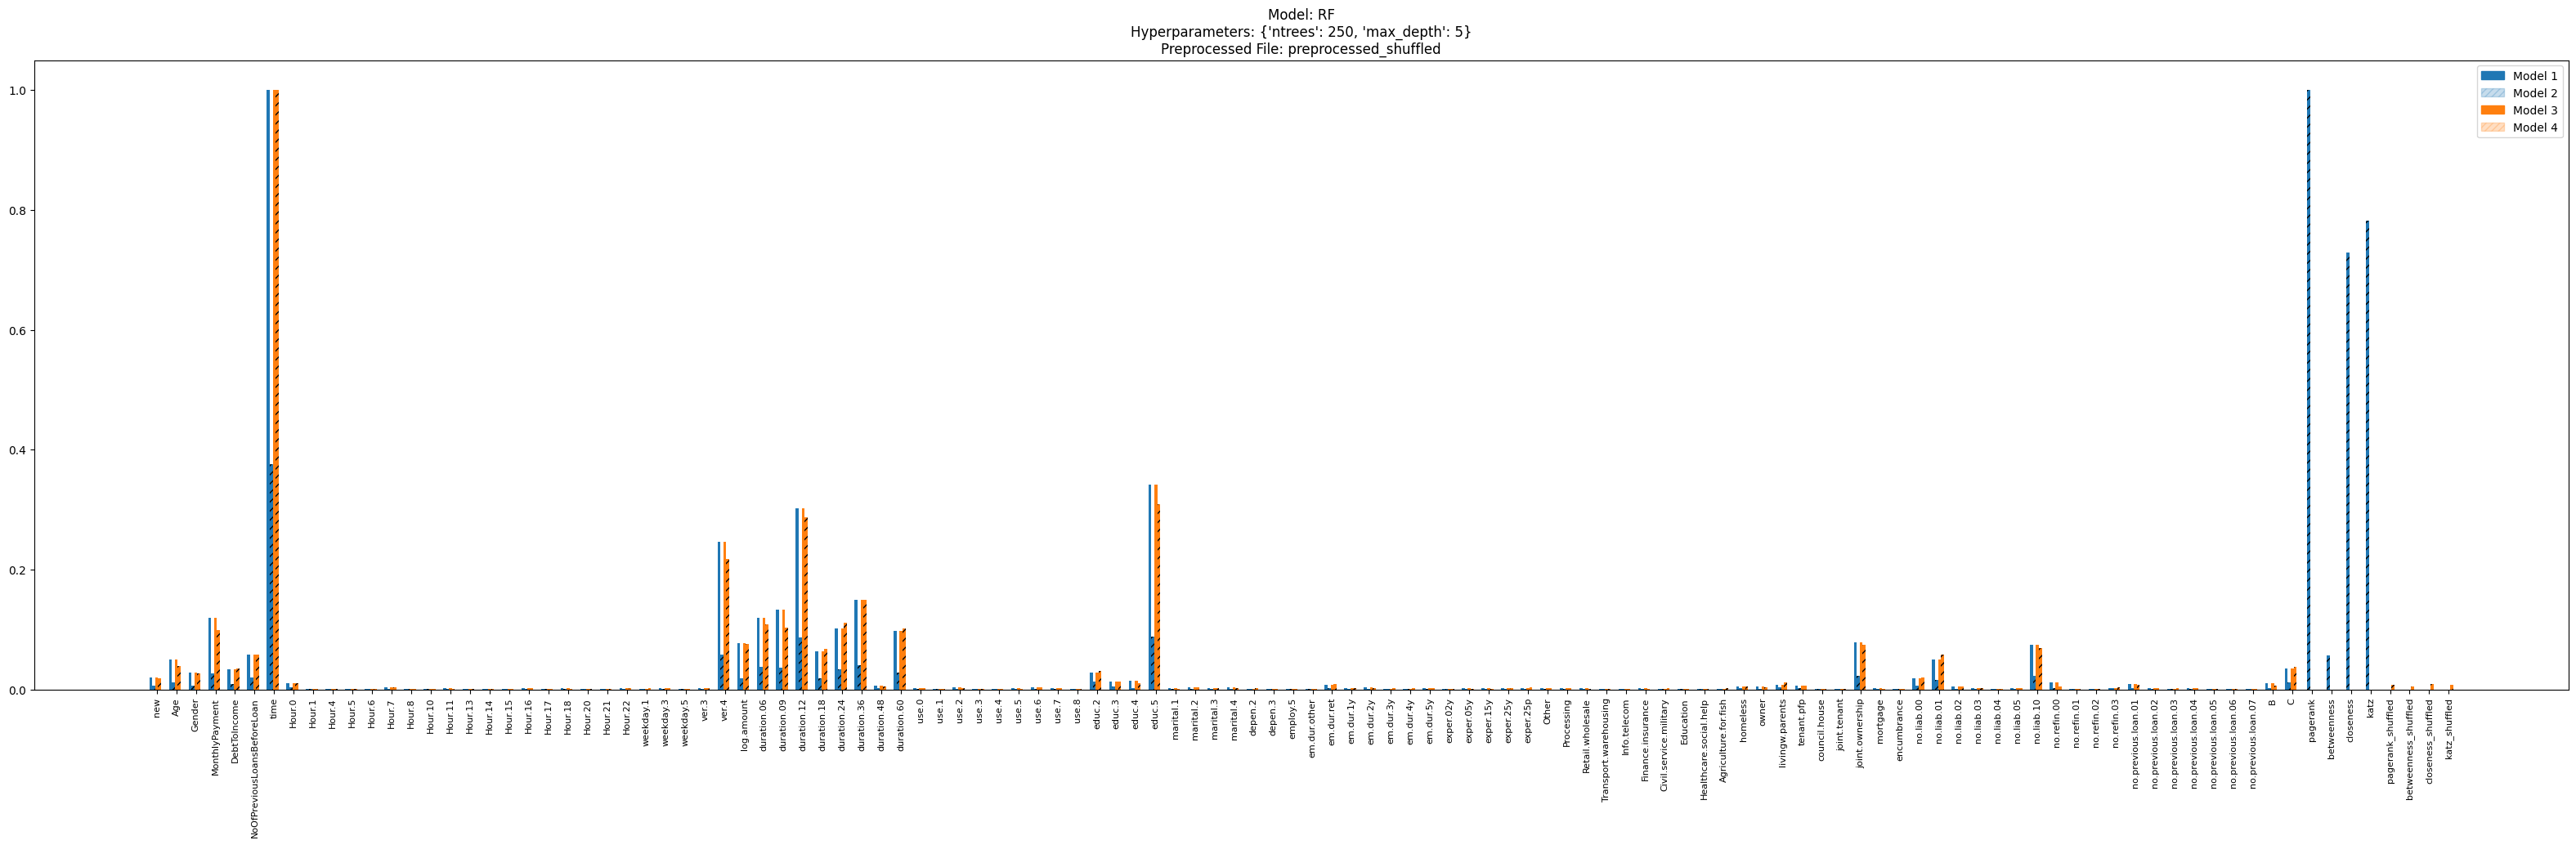

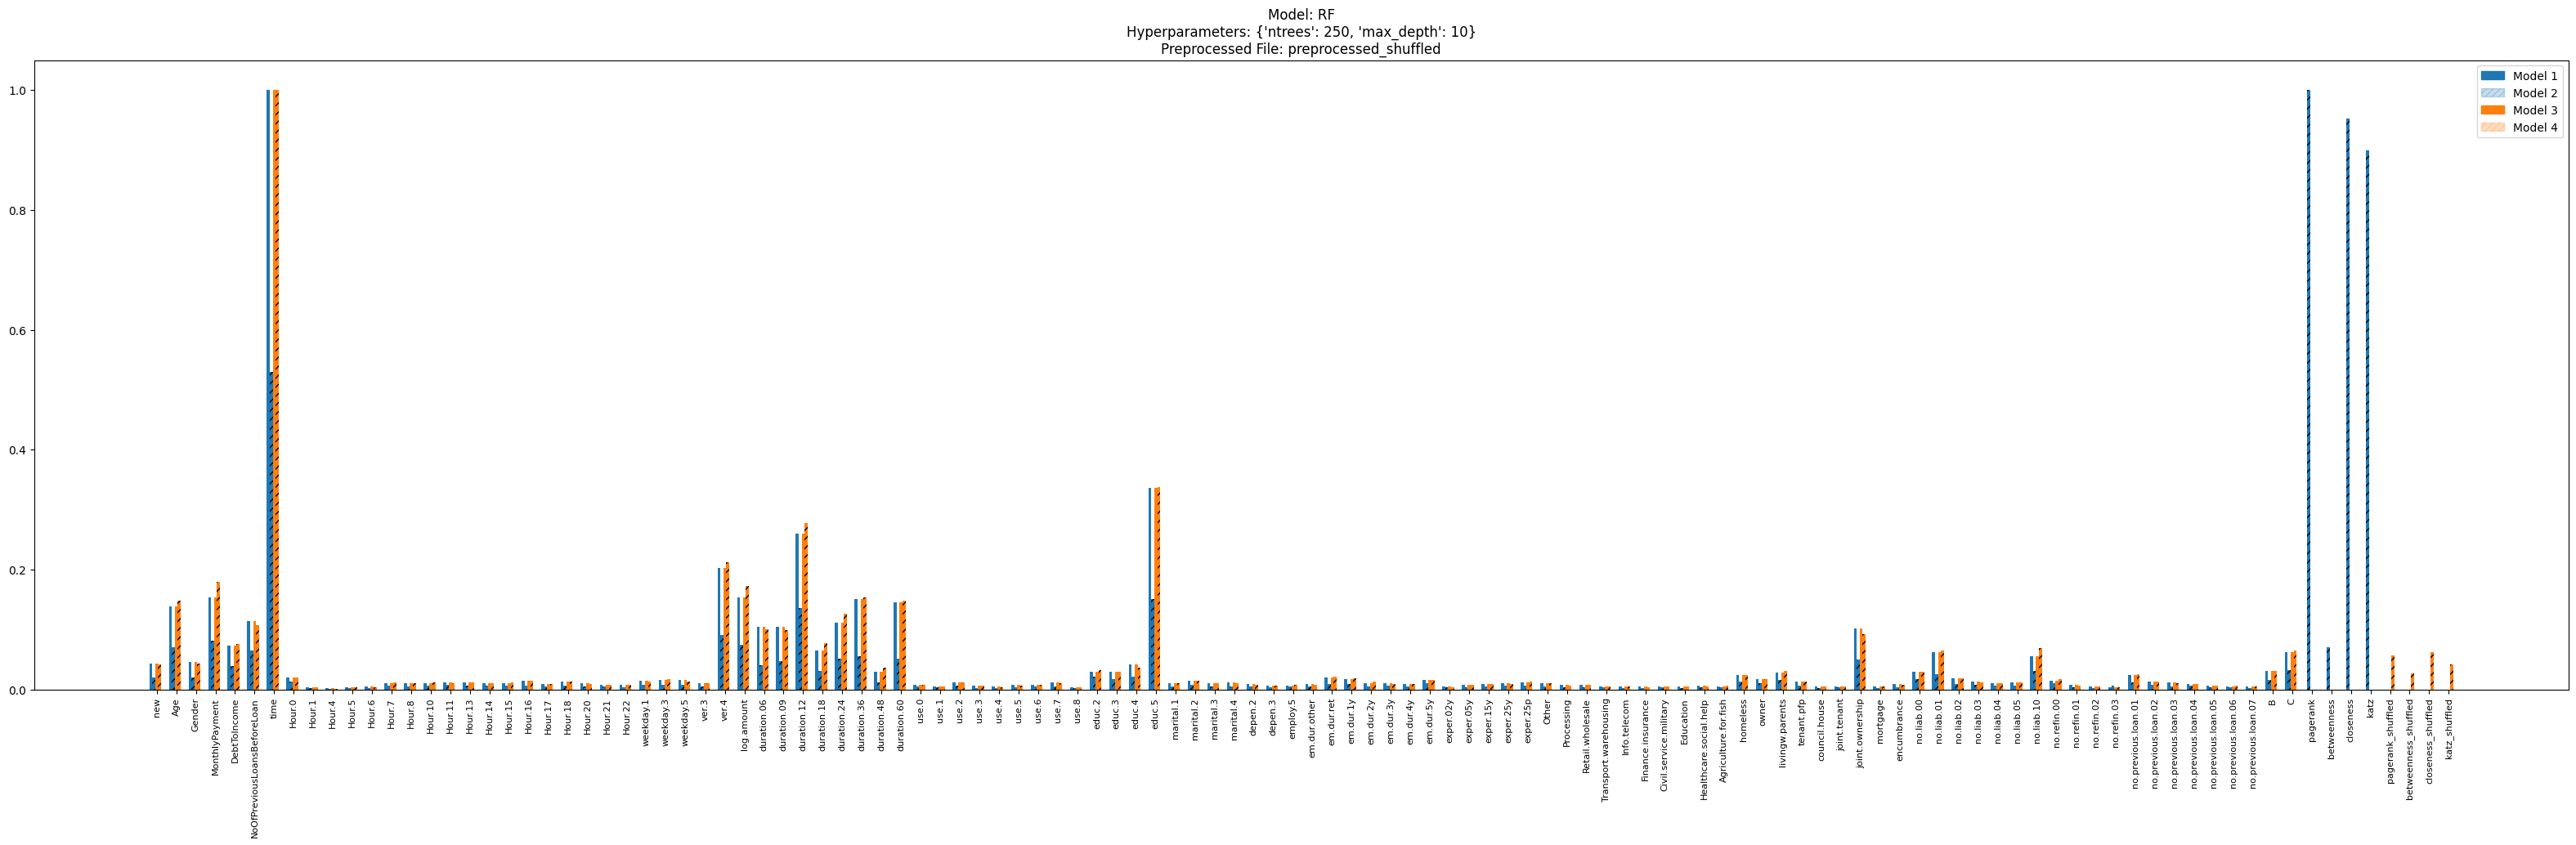

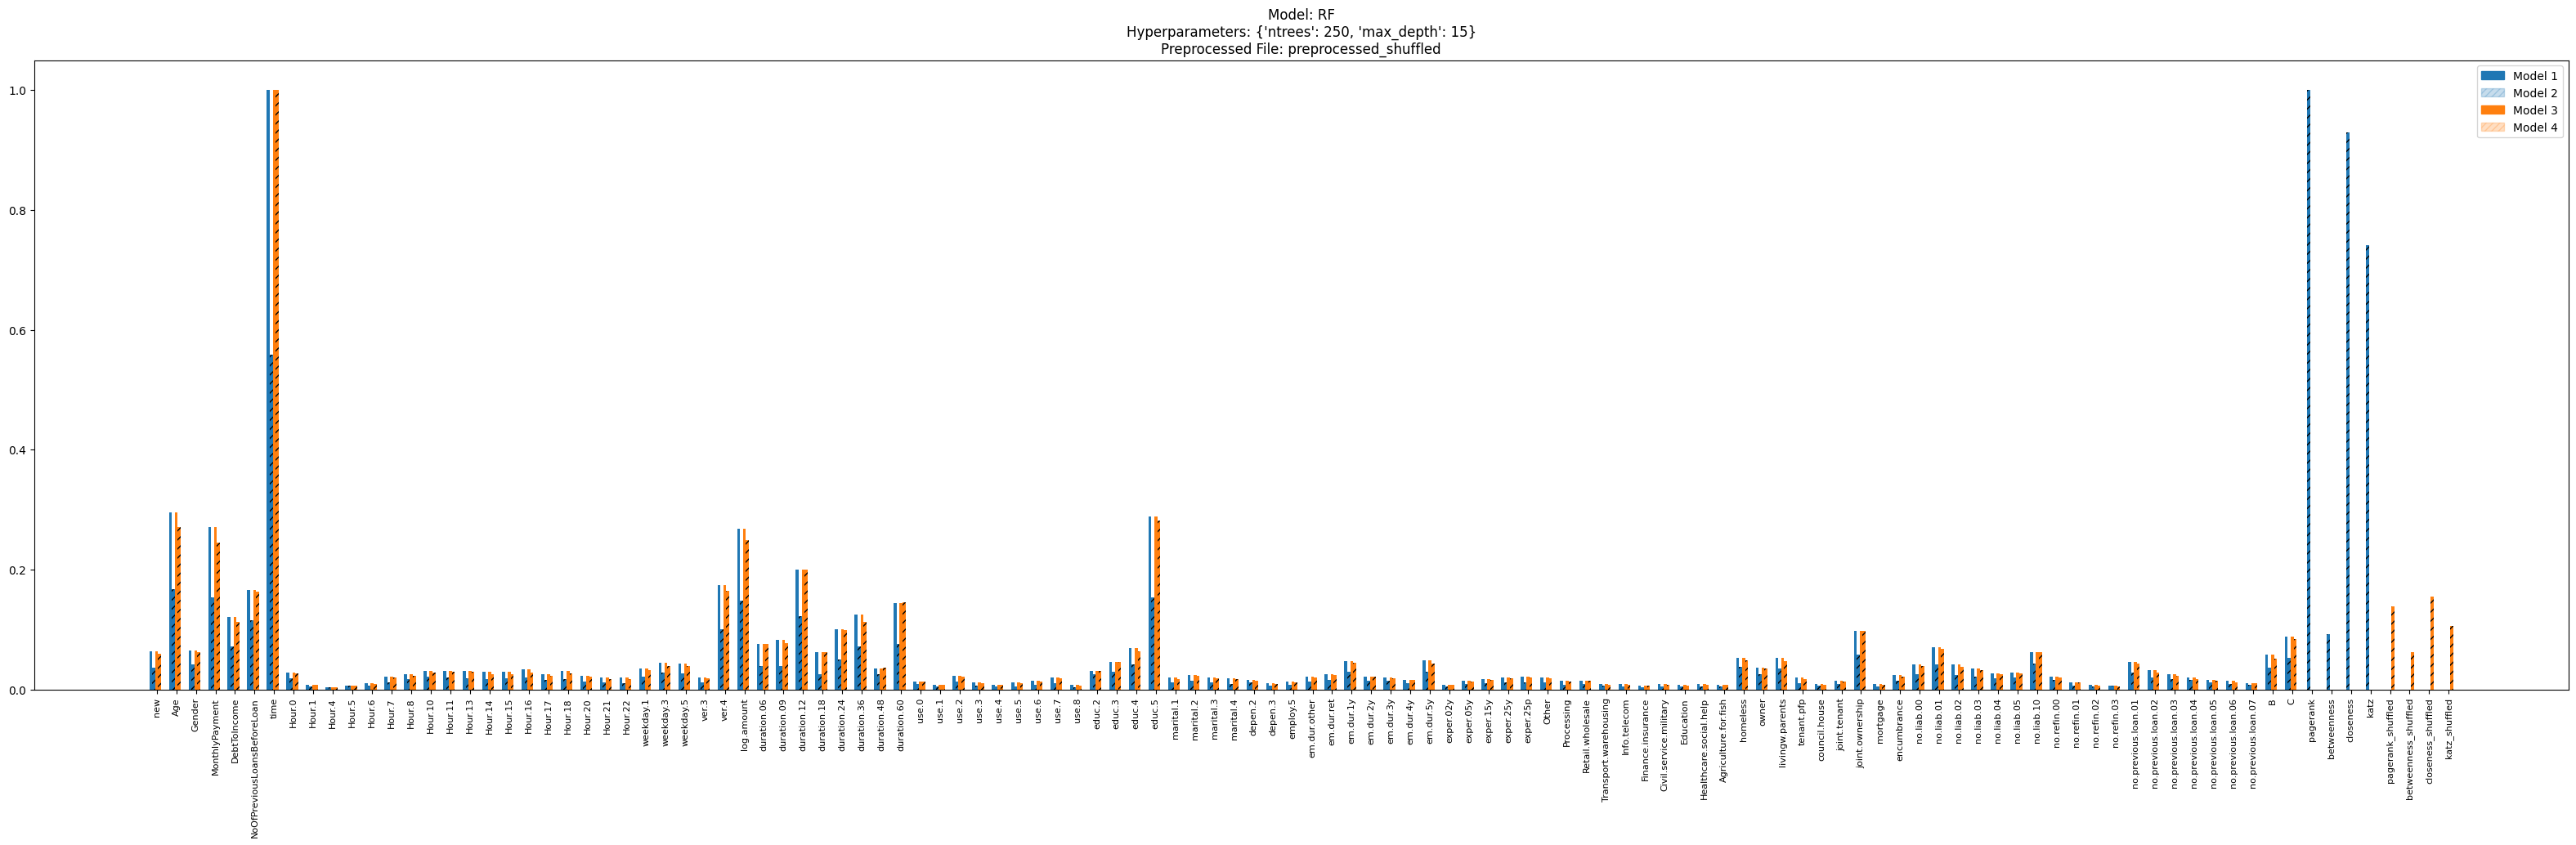

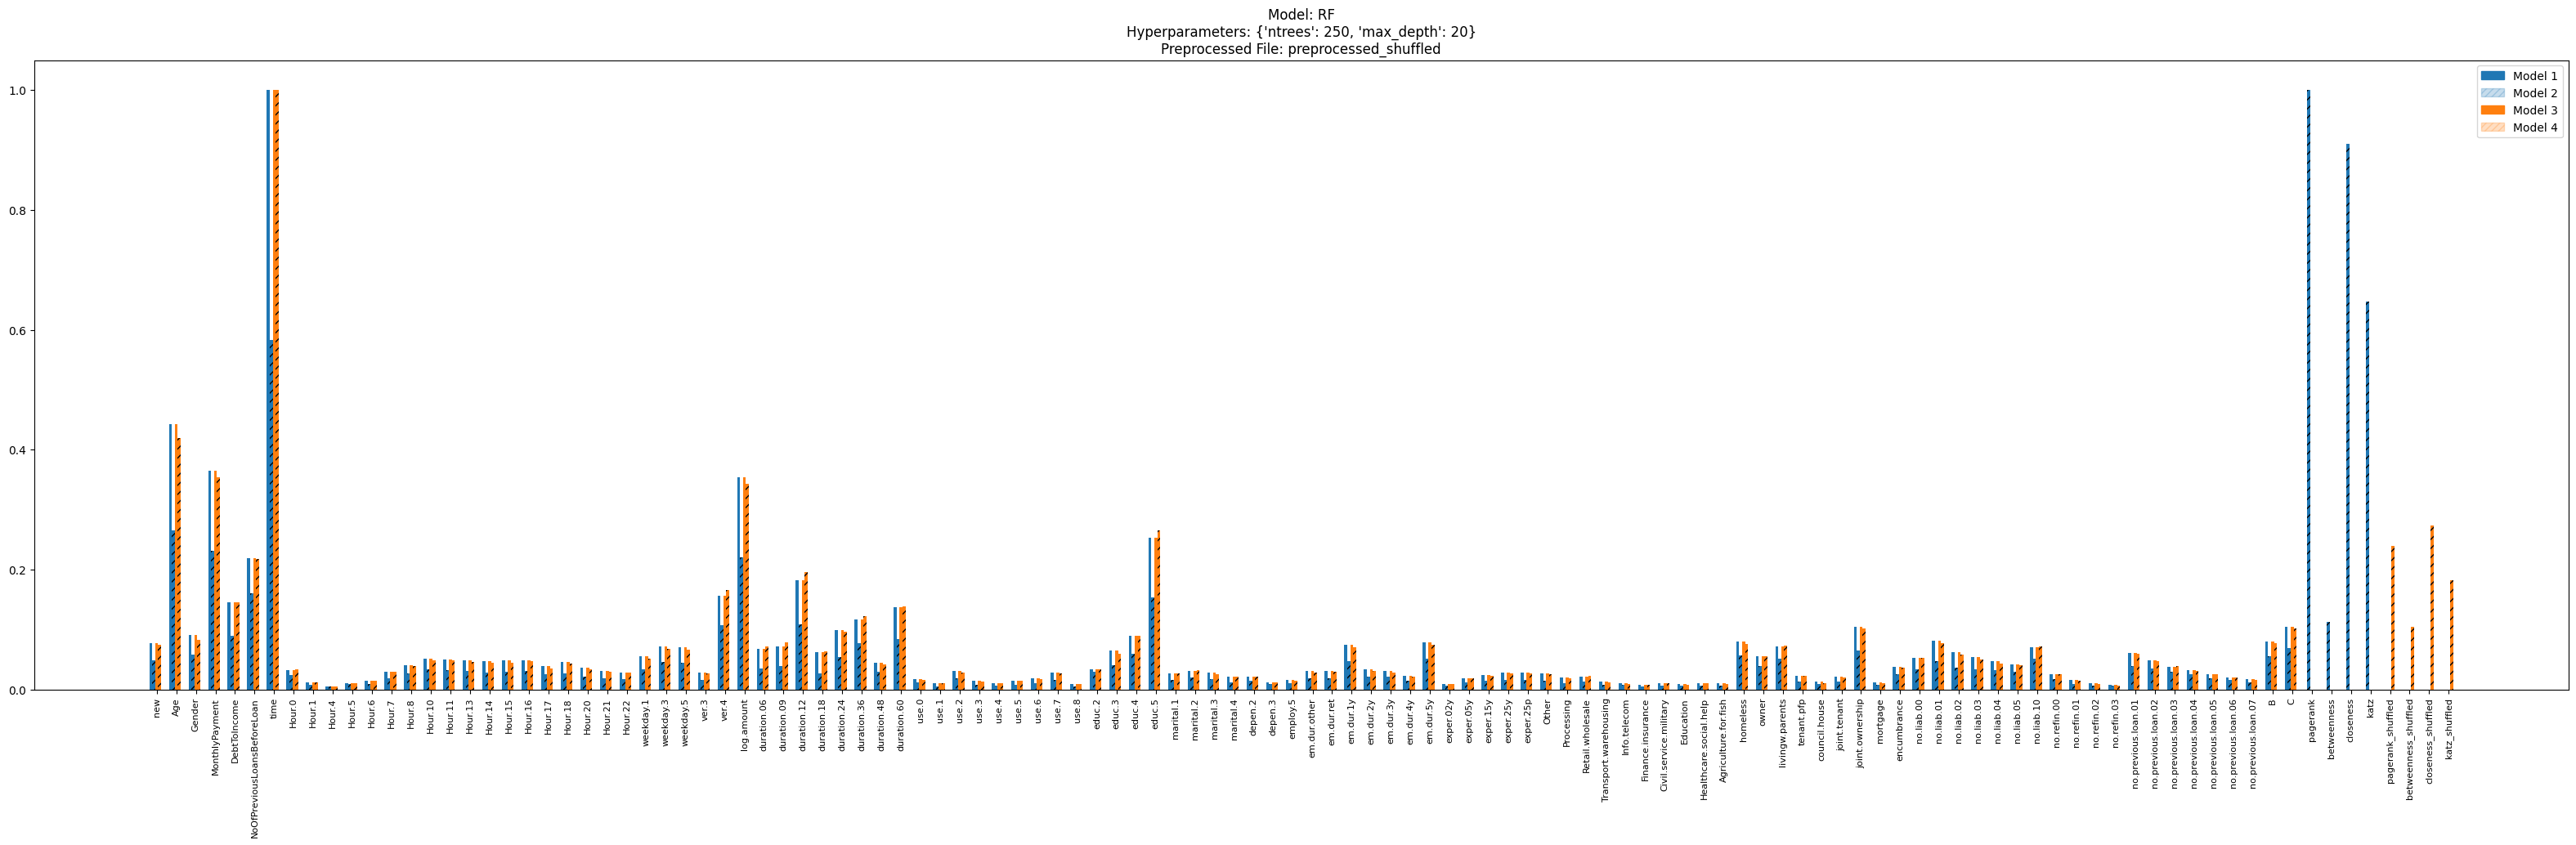

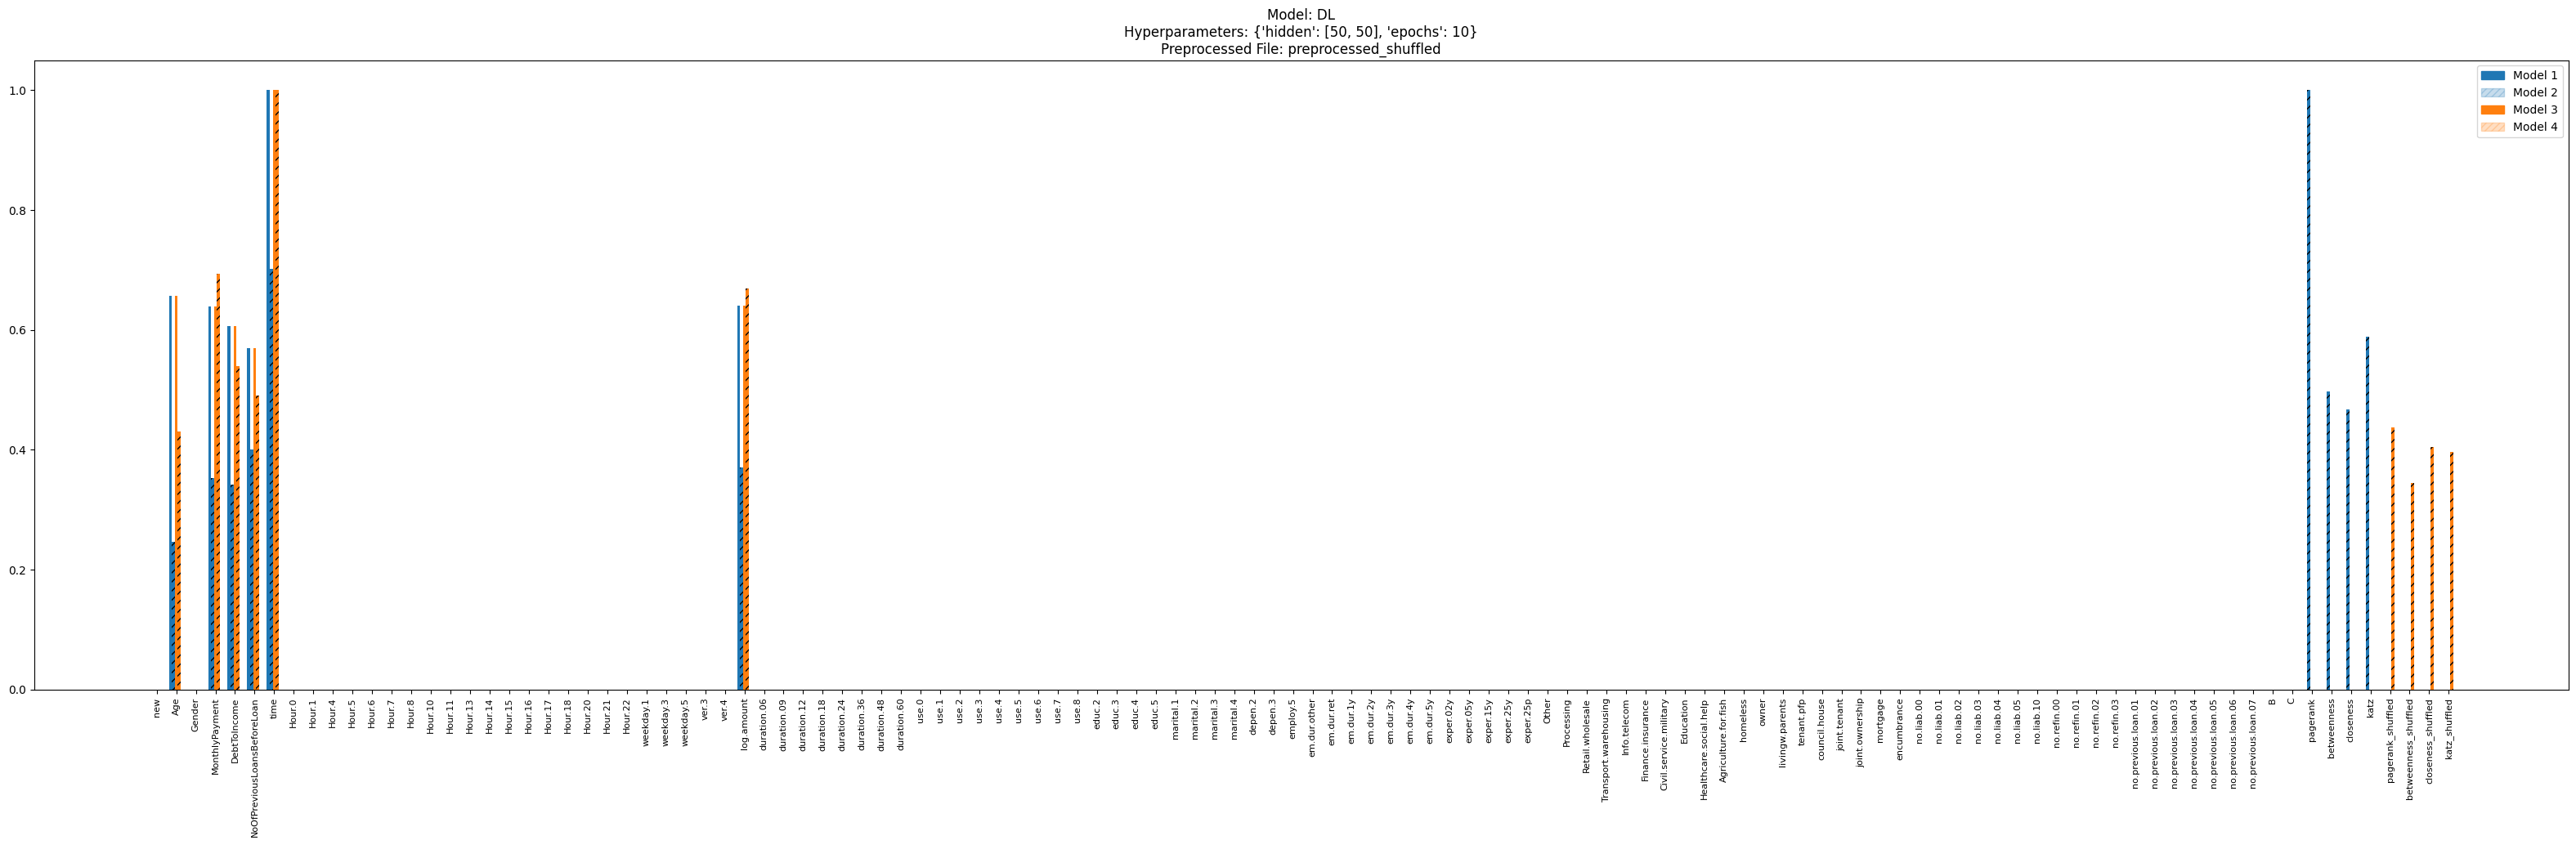

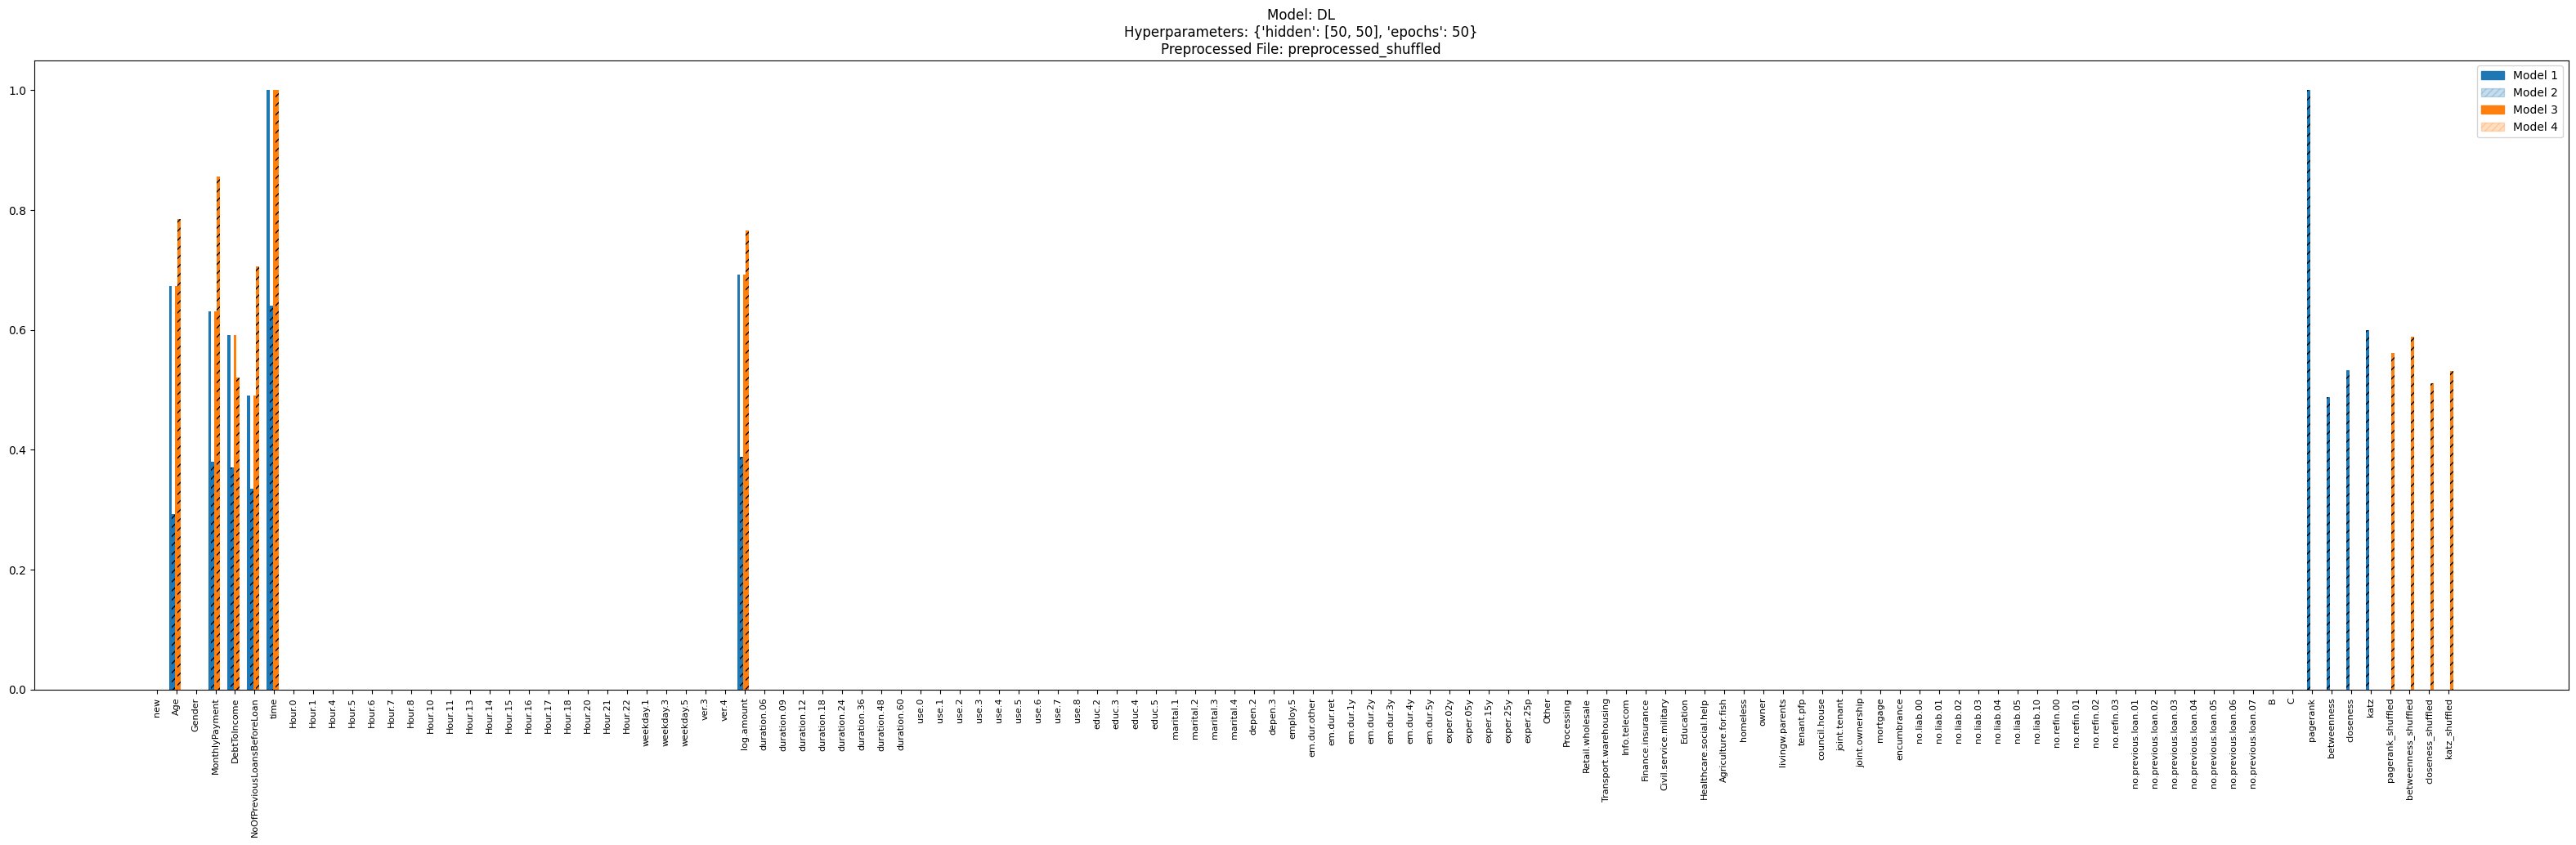

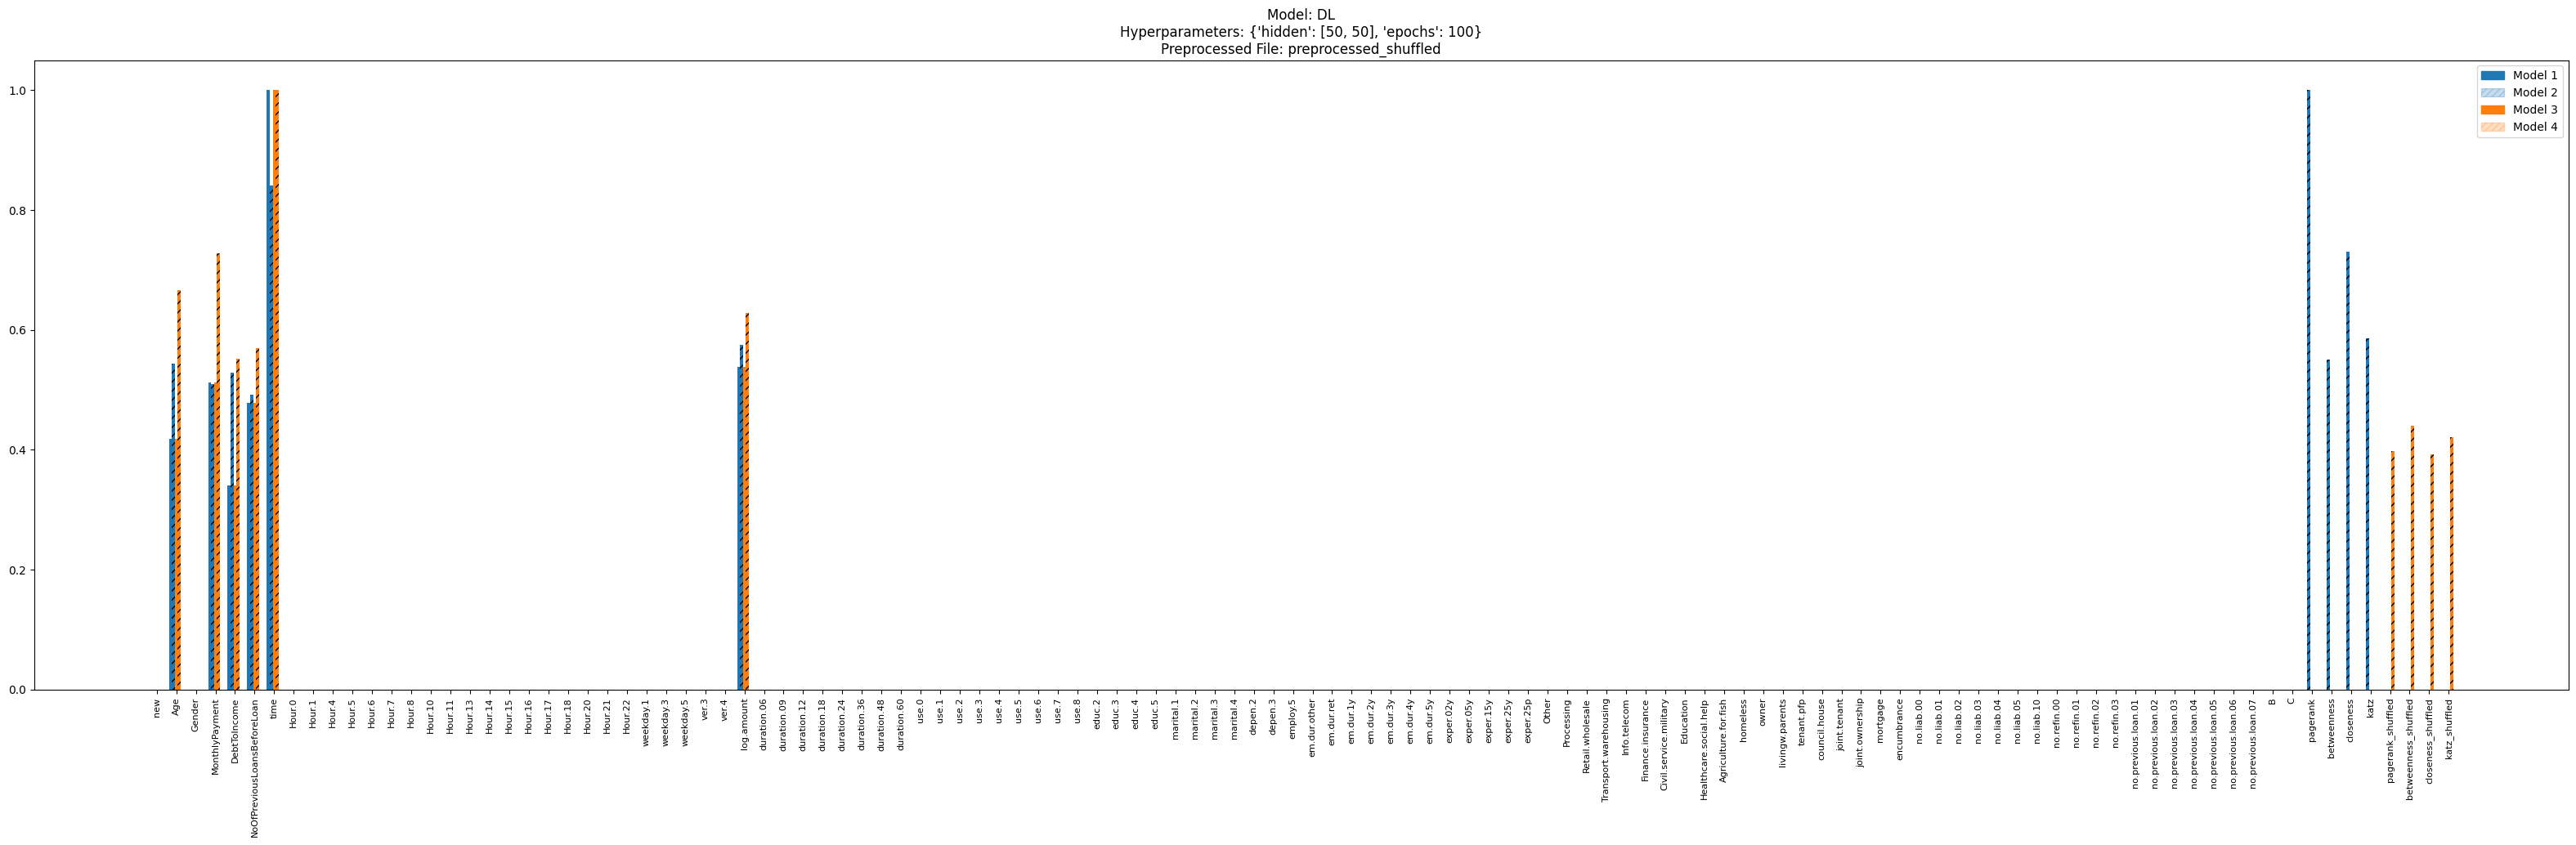

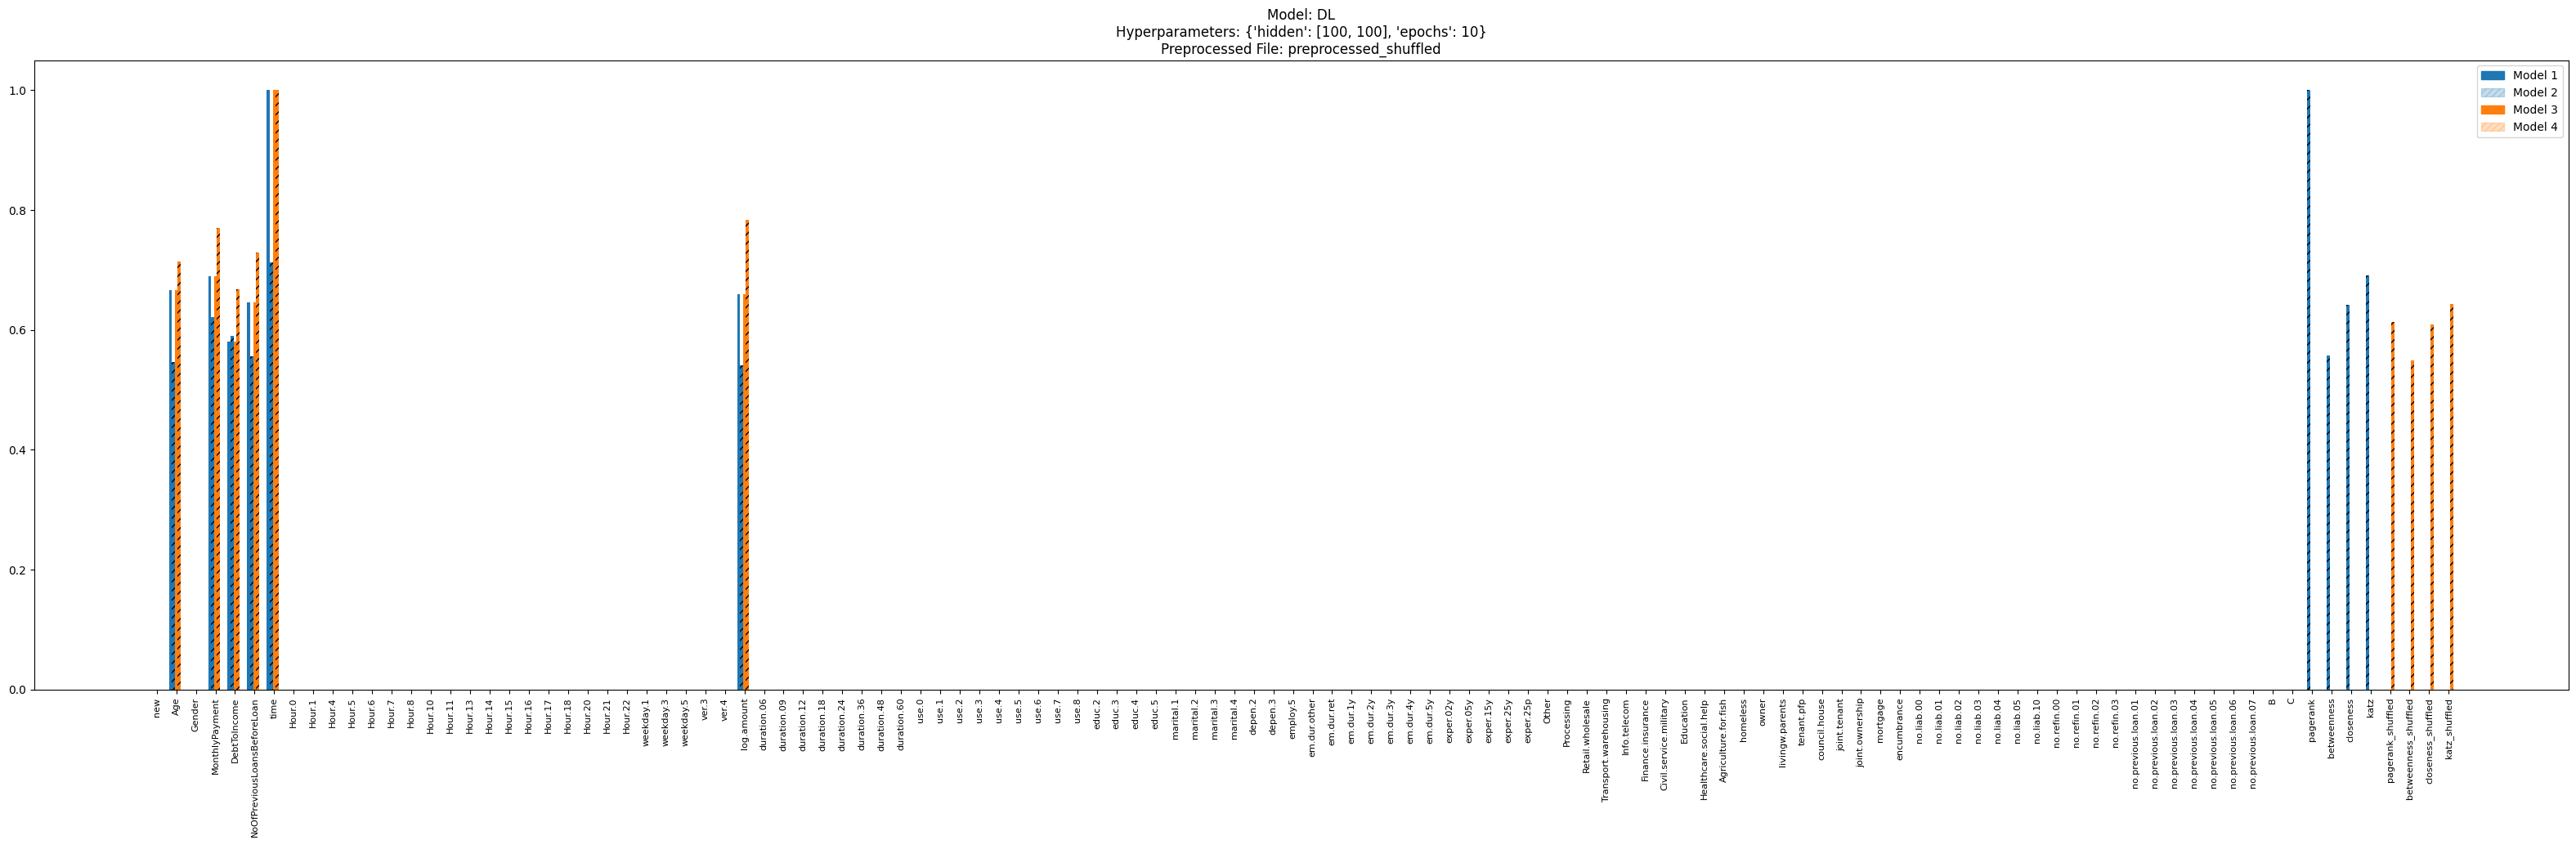

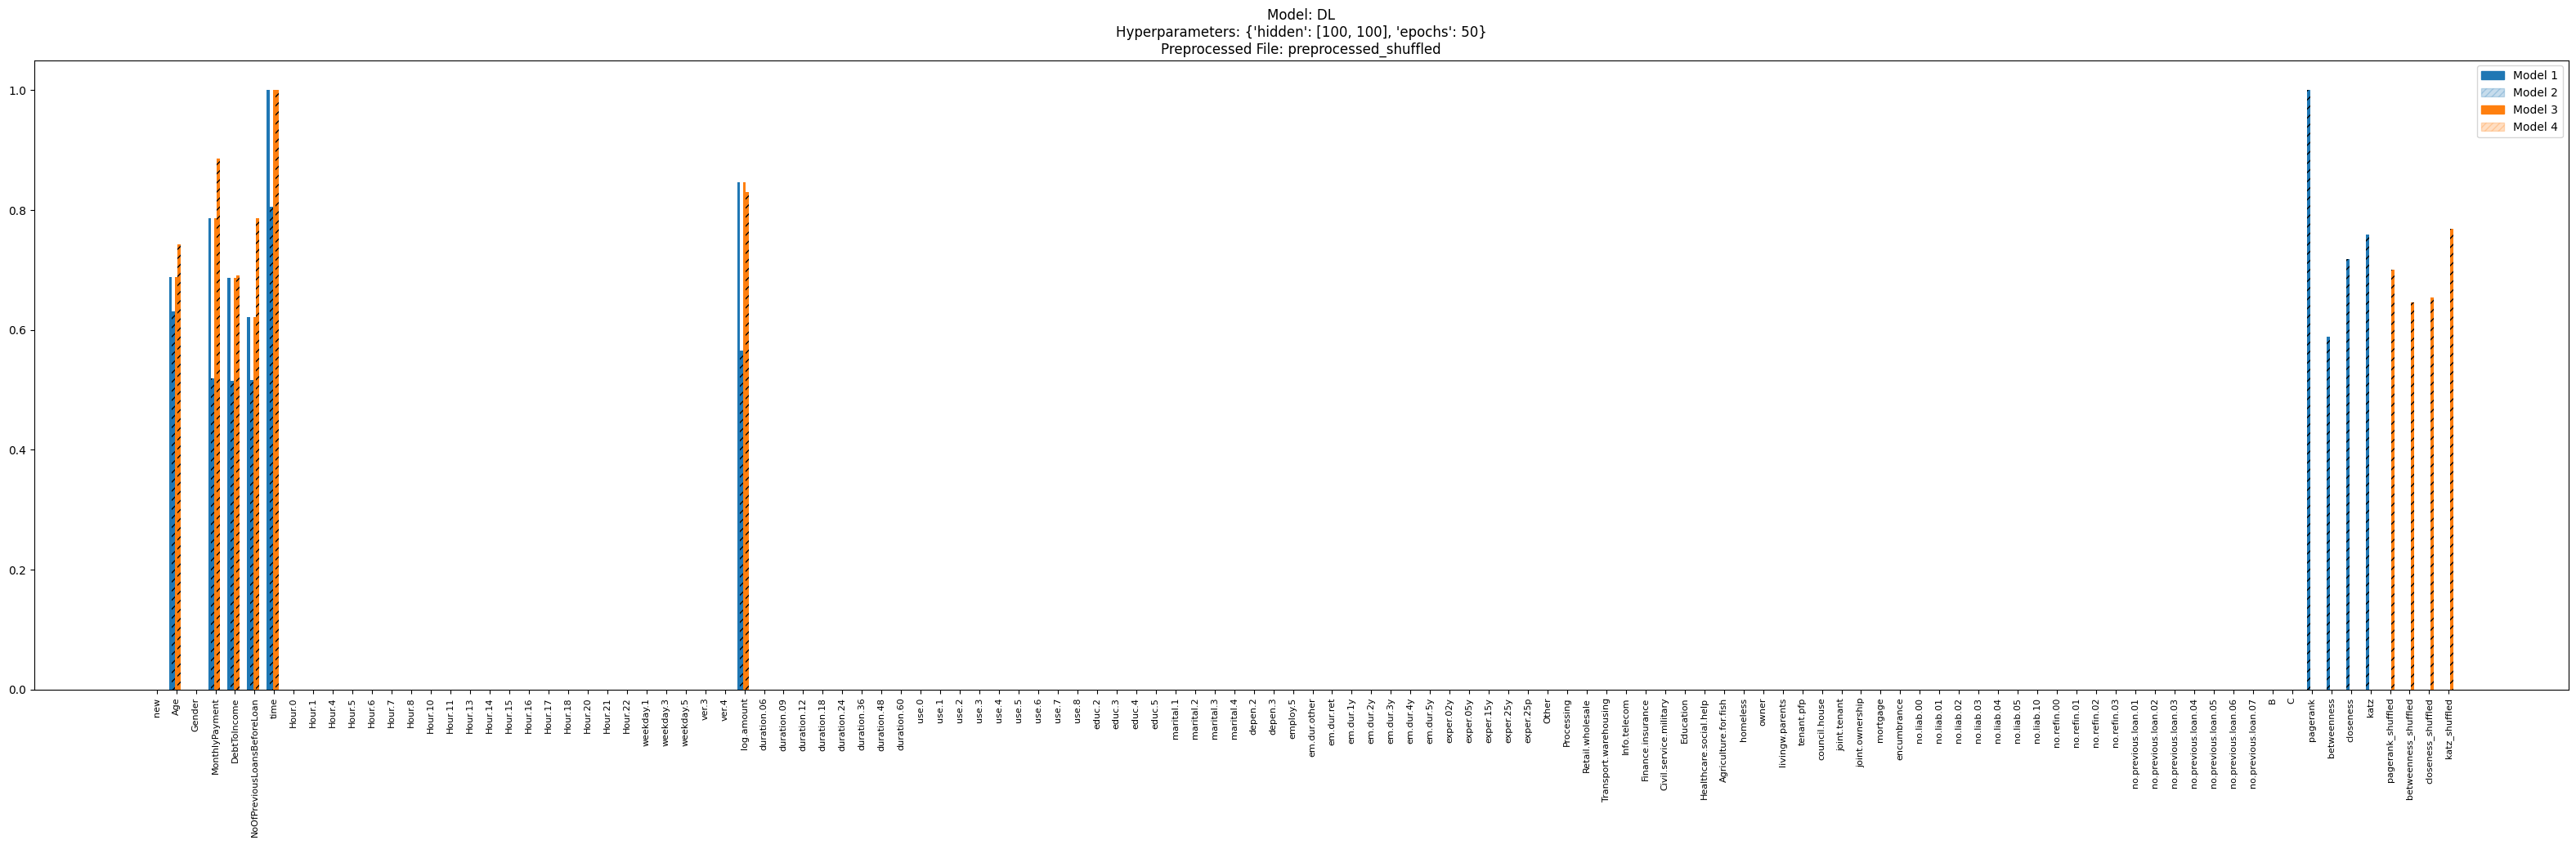

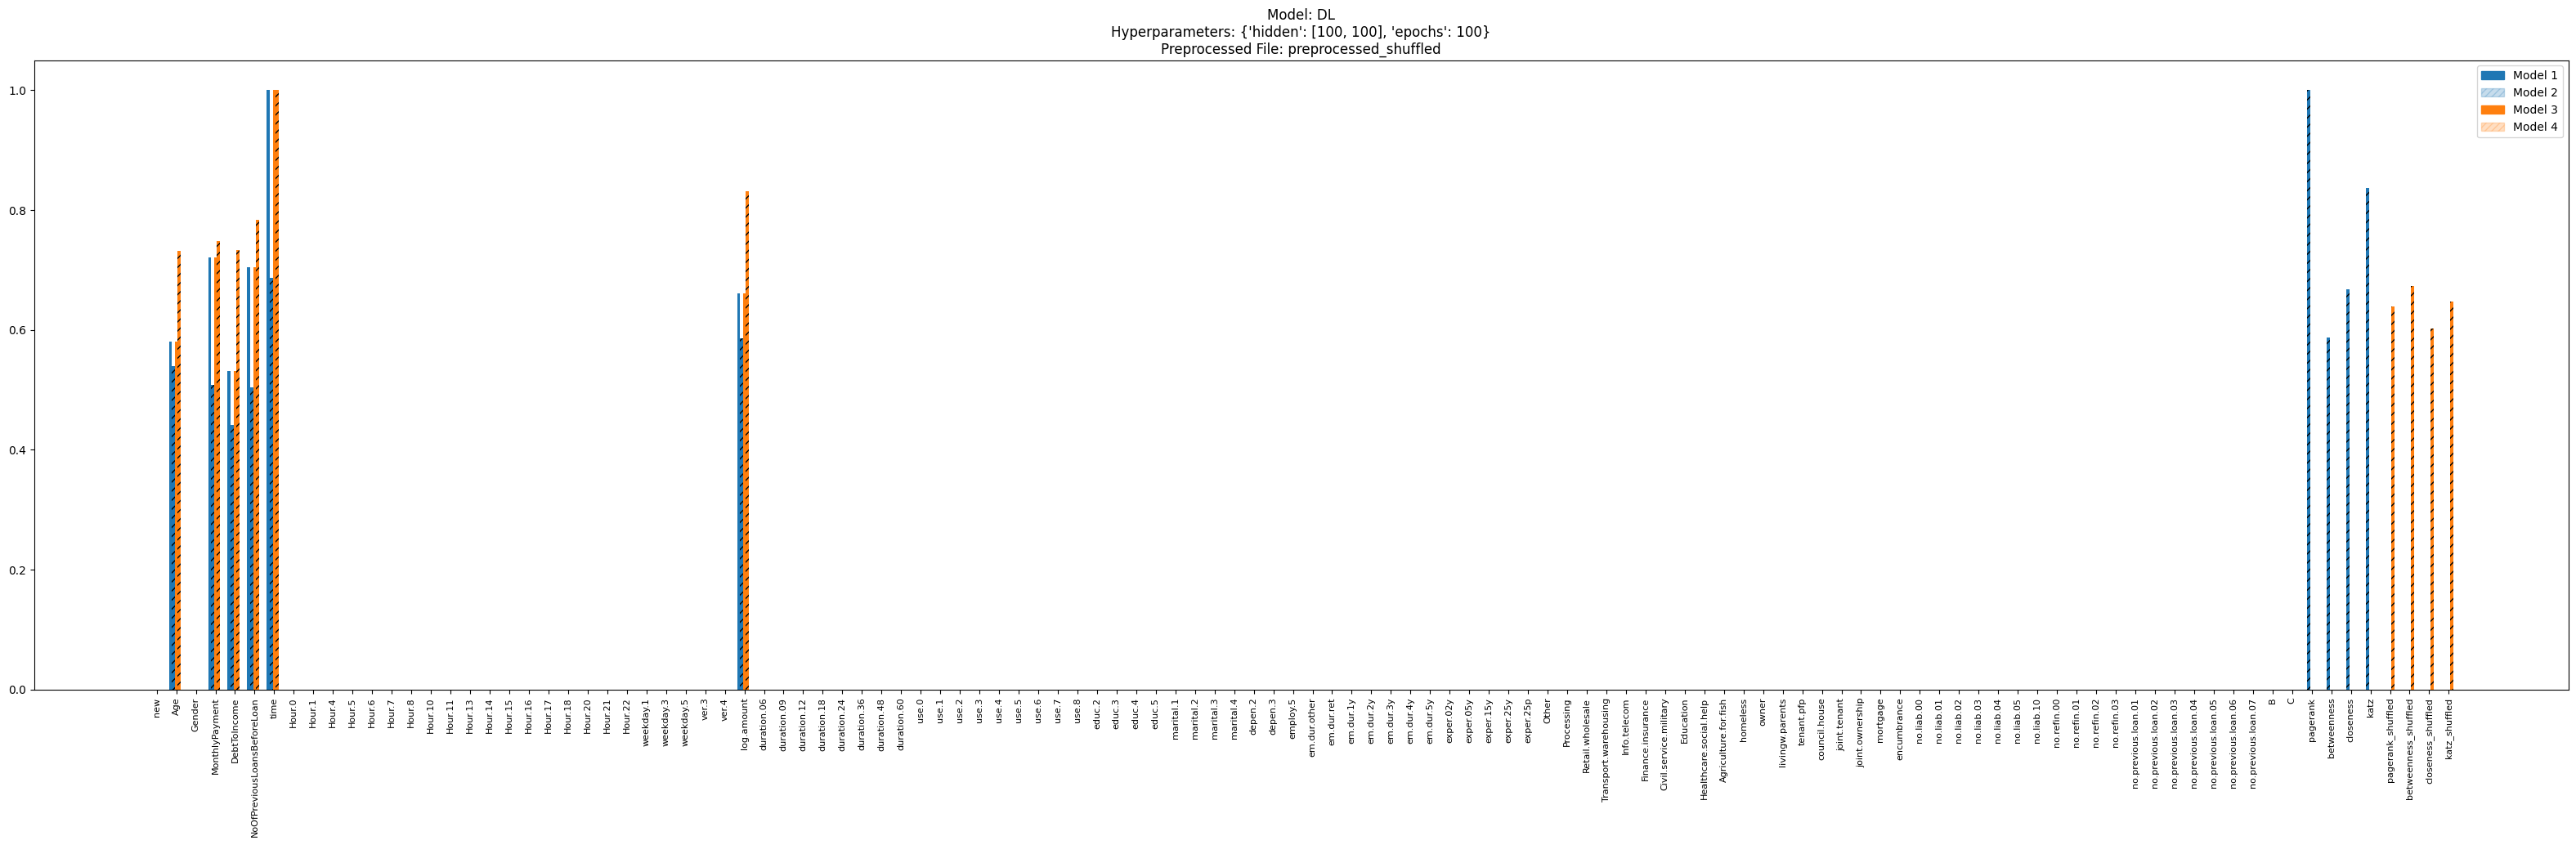

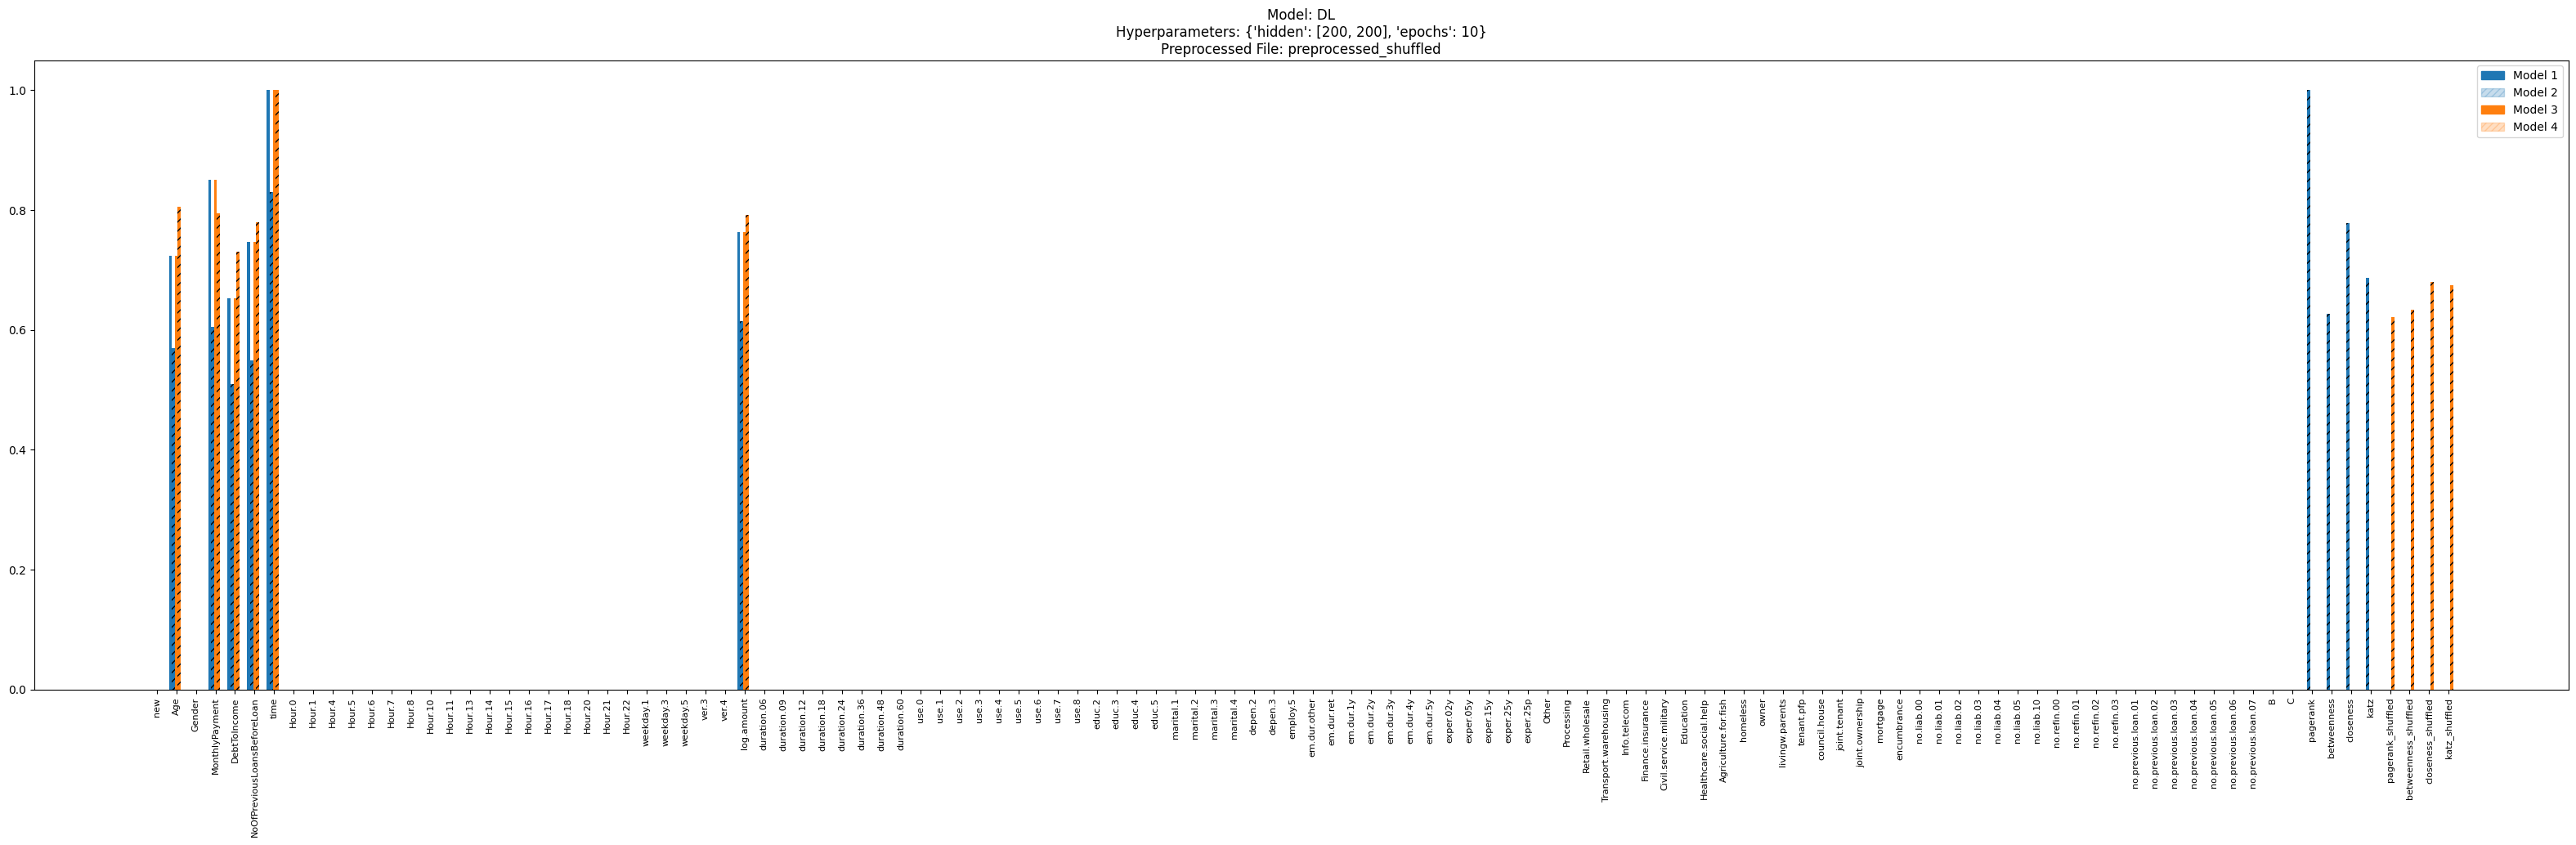

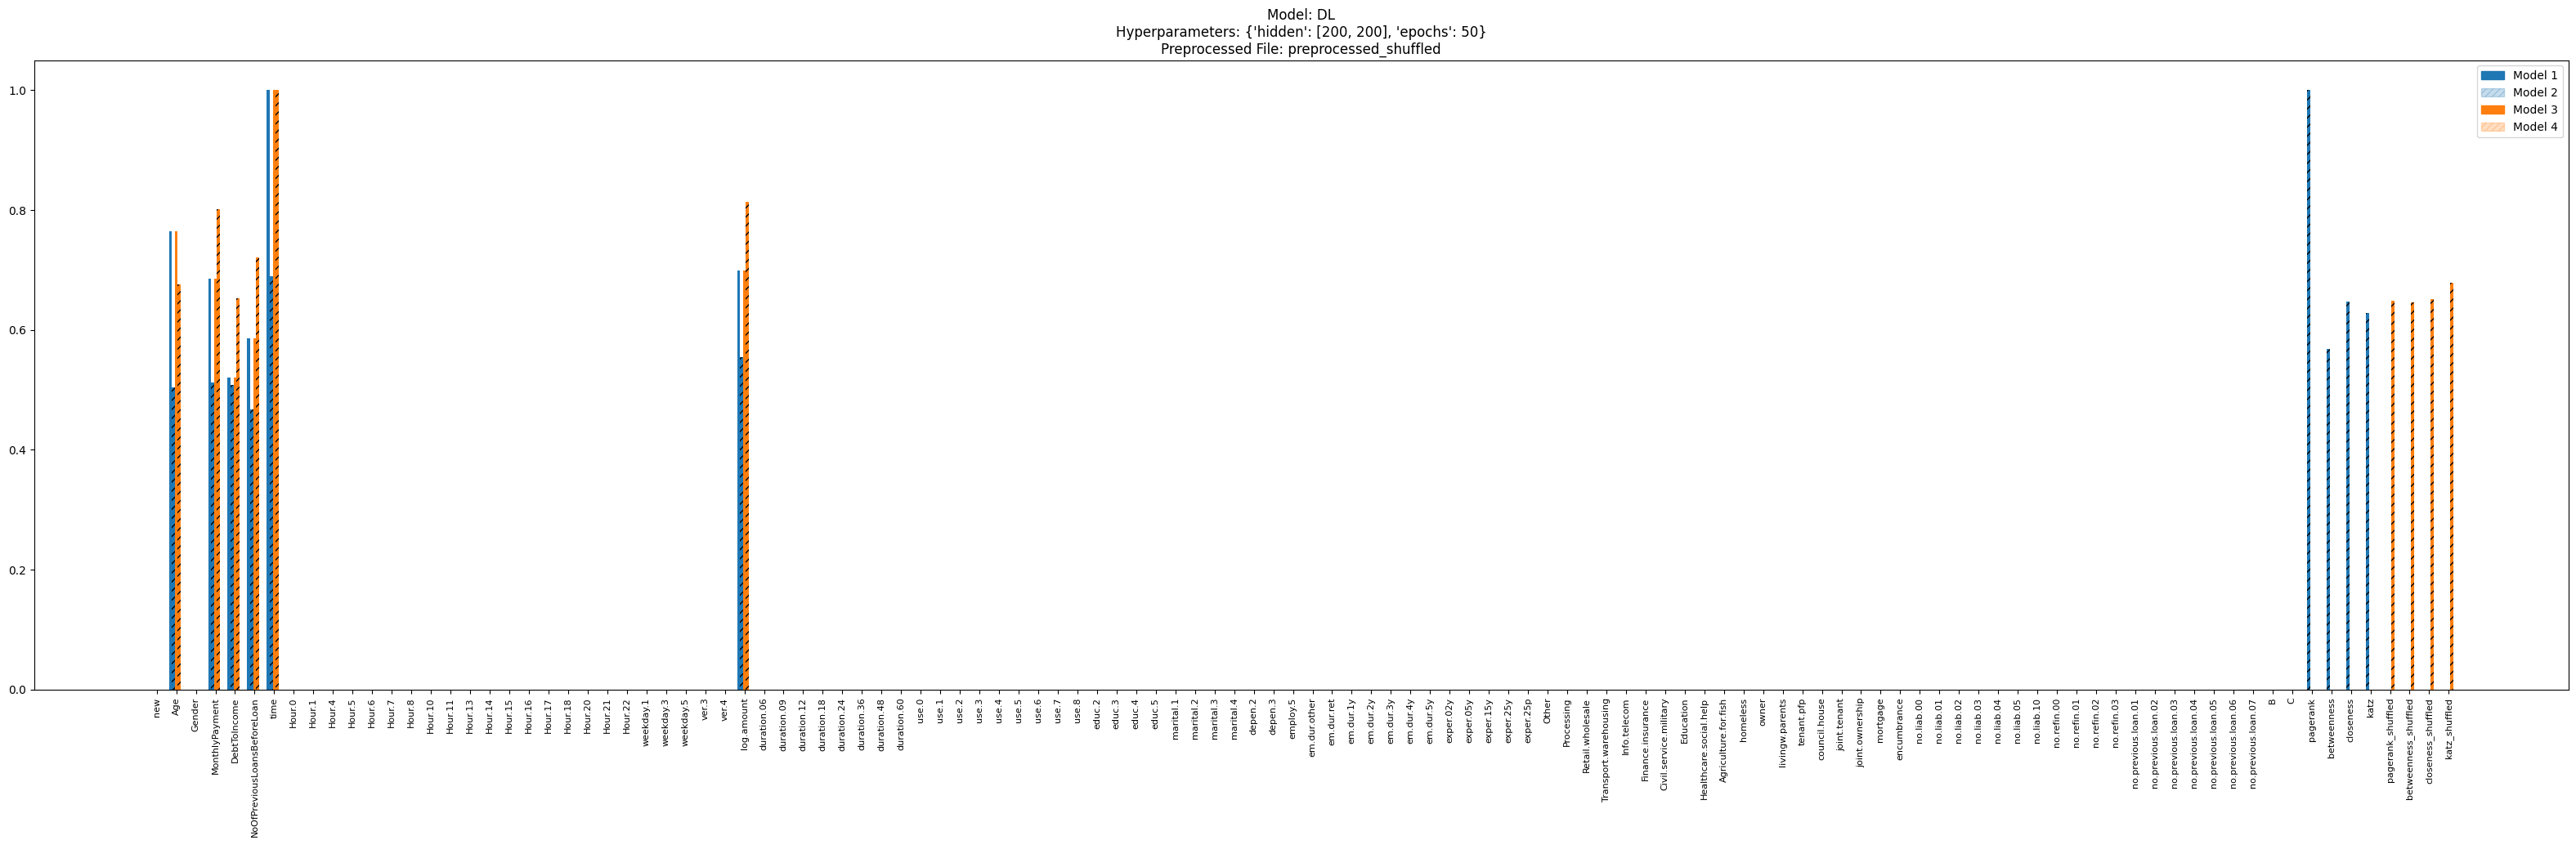

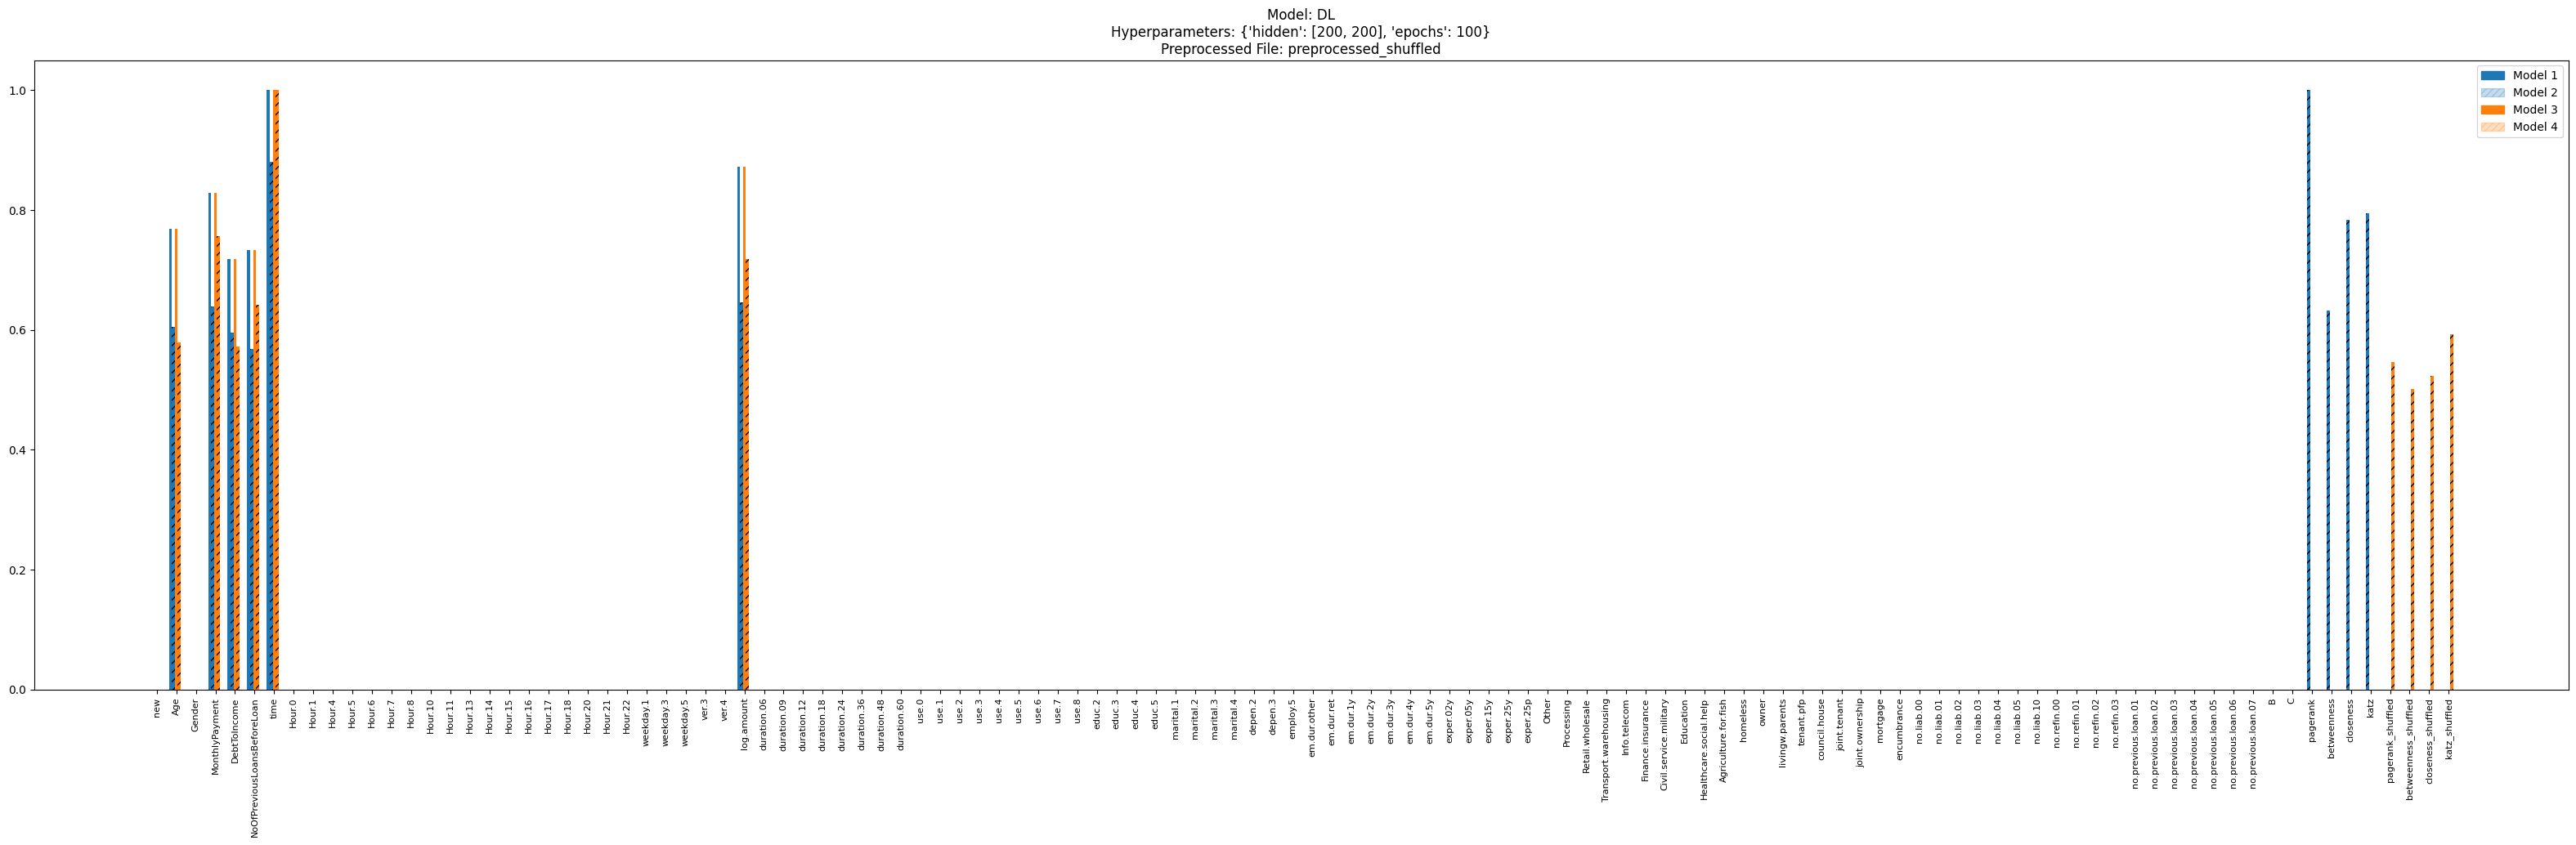

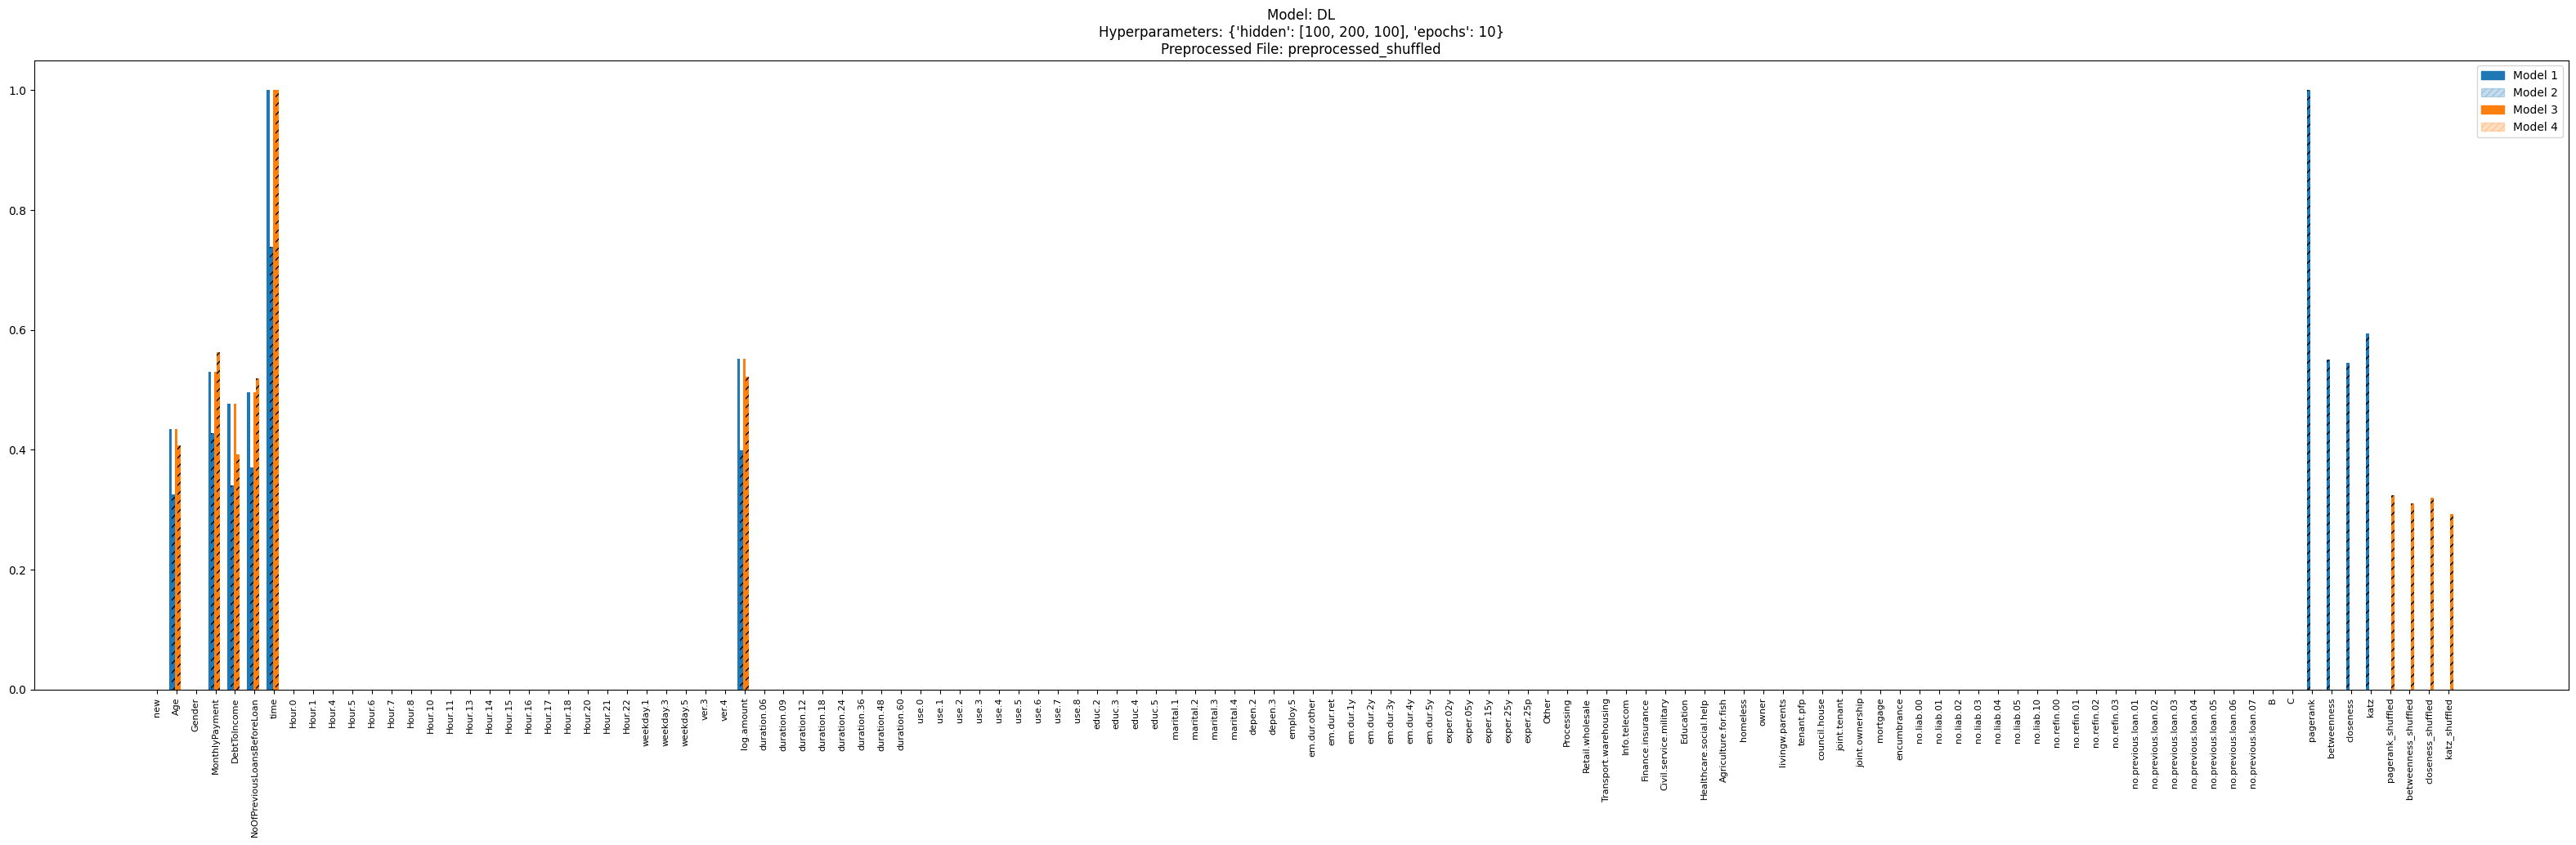

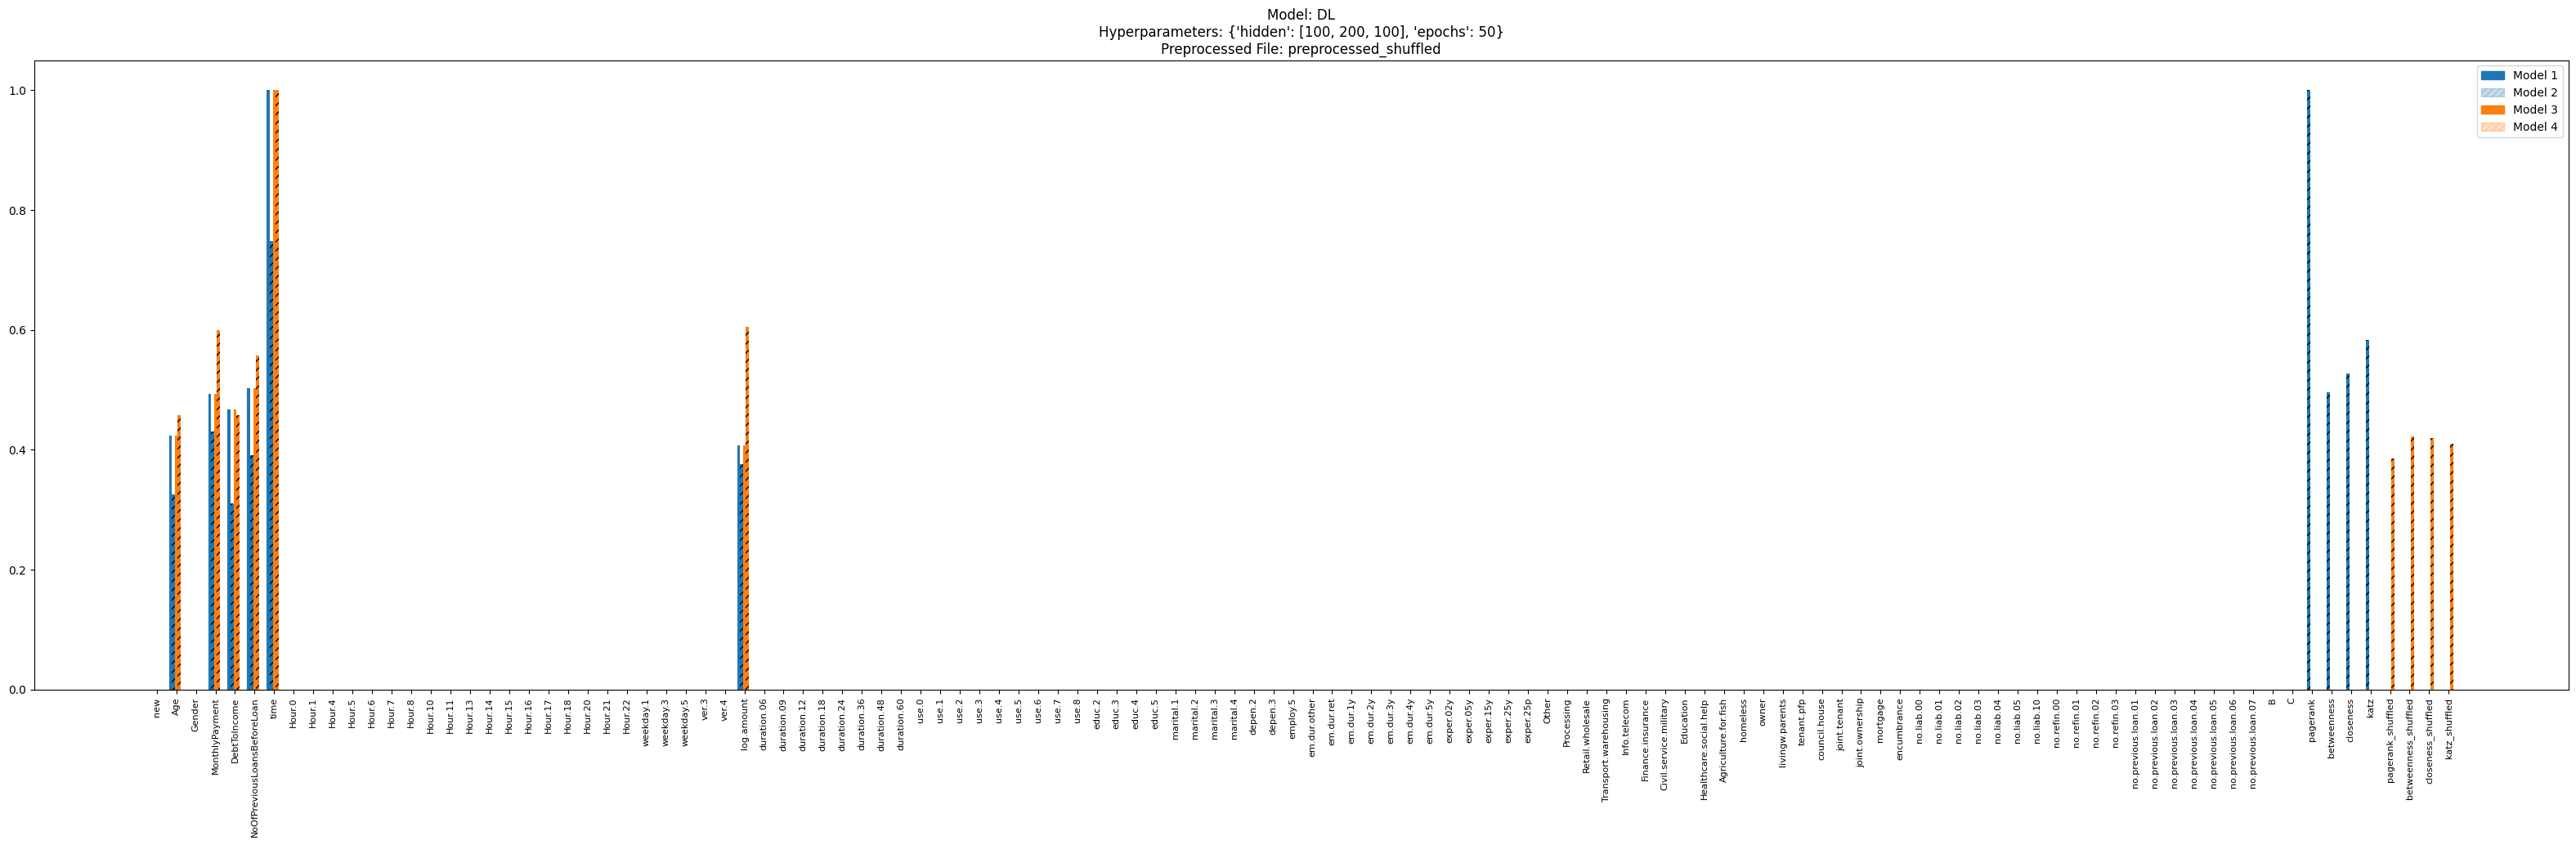

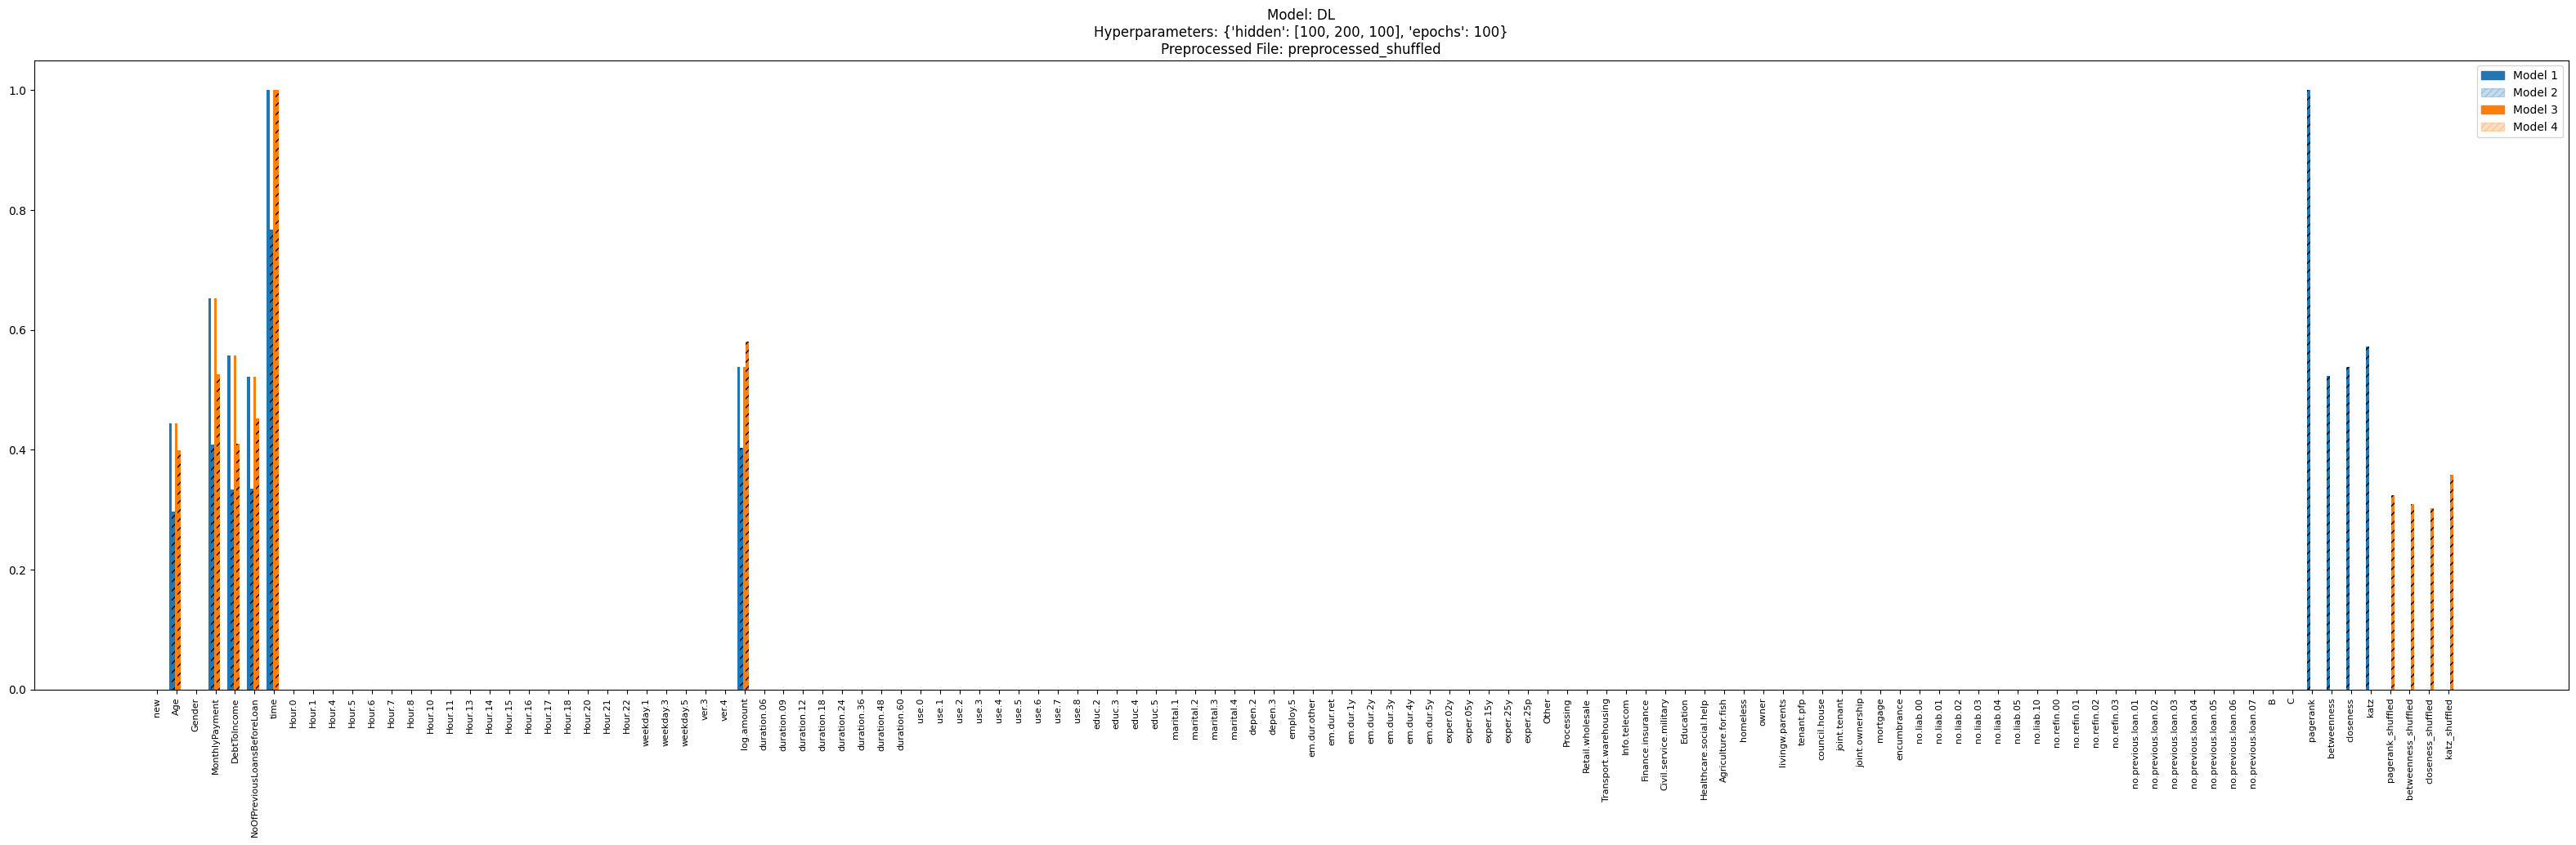

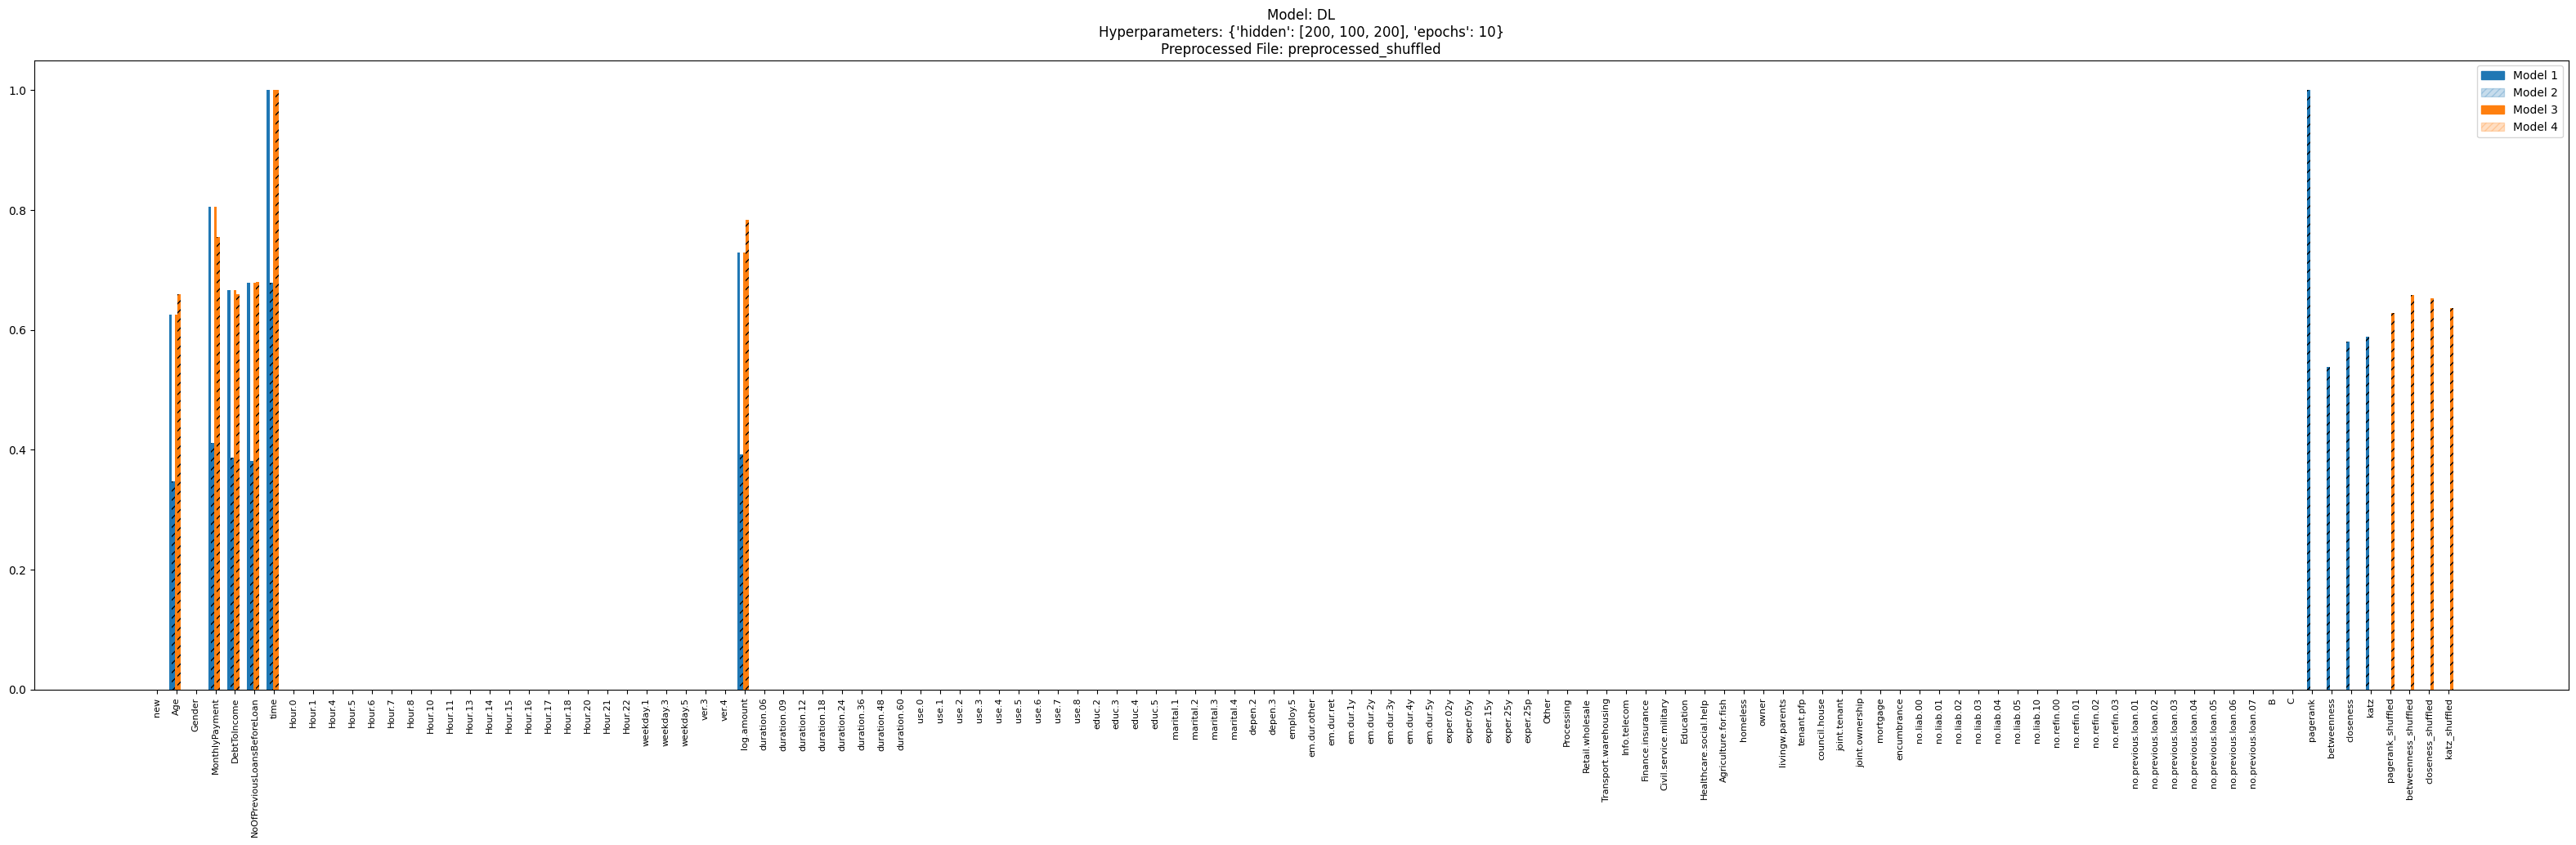

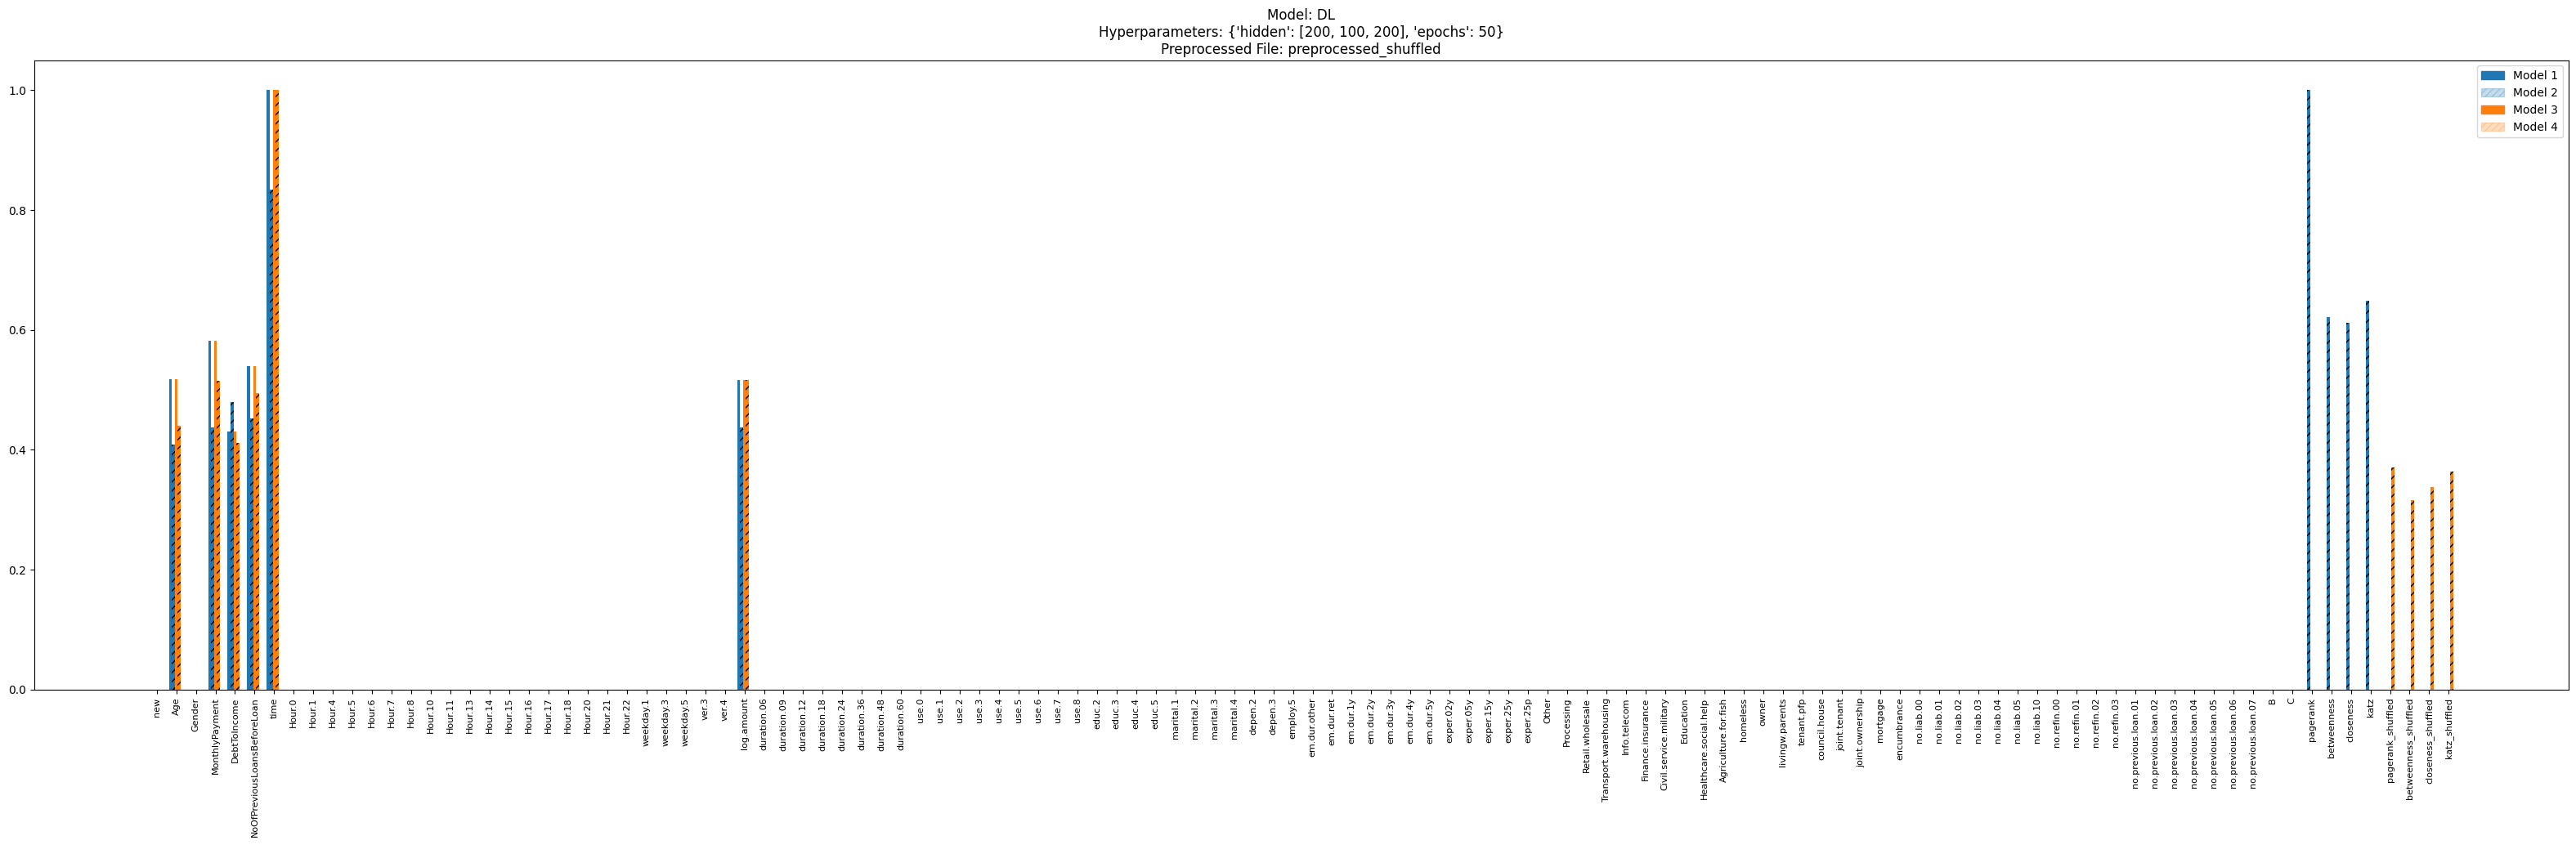

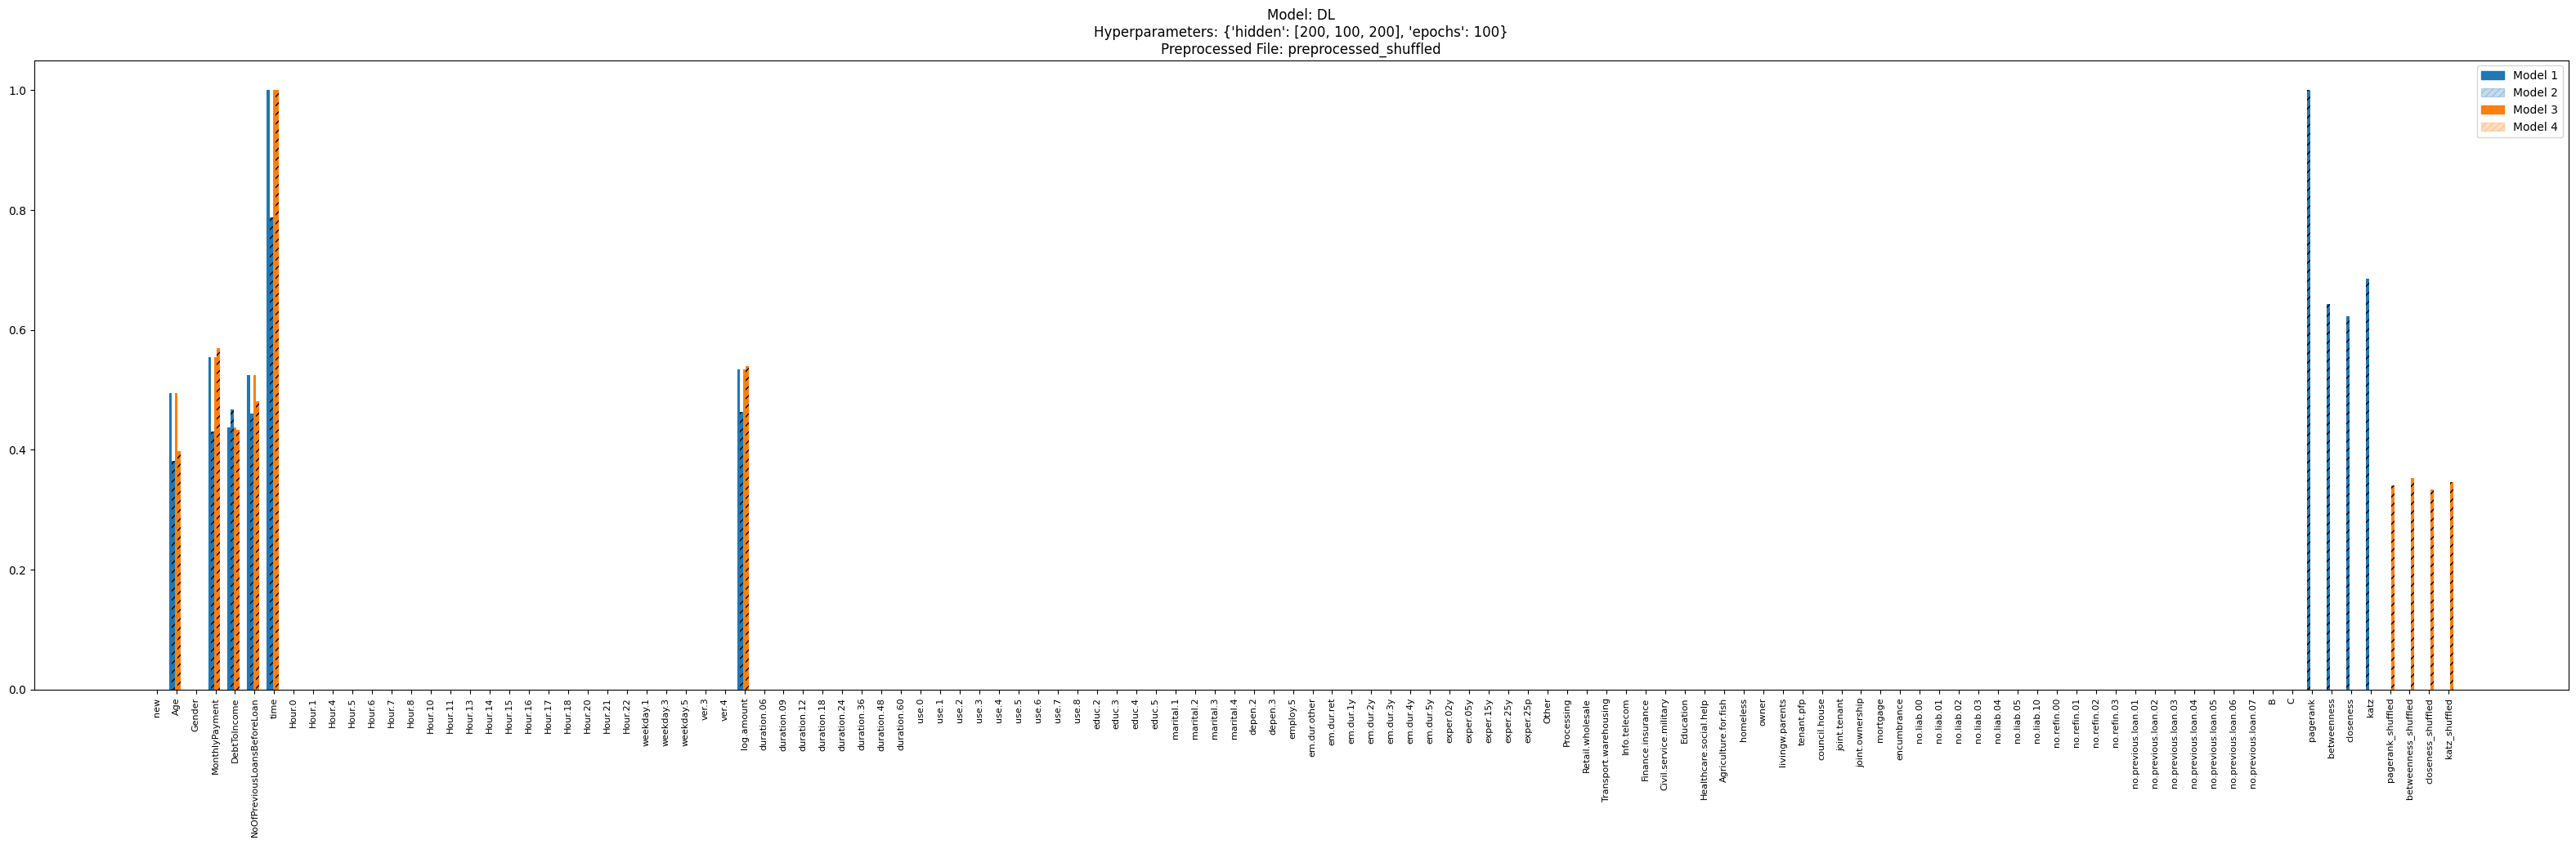

In [90]:
feature_importance(X_val,
                   y_val,
                   exclude_LIST,
                   models_and_hyperparams,
                   model_directory,
                   graph_directory,
                   model_to_analyse,
                   exclude_feature=exclude_features_distribution +
                   exclude_features_selectionMethod,
                   paired=True)

In [91]:
problematic_pairs

[]

print_model_report(X_test, y_test, exclude_LIST, models_and_hyperparams,
                       model_directory, graph_directory, model_to_analyse)